In [ ]:
srun --account=g101-2349 --mem=150G -N1 -n4 --gres=gpu:1 --time=10:00:00 --pty /bin/bash -l

singularity exec --nv -B $(pwd):/workspace -B /lu/tetyda/home/wnoskow/microboonePickled:/microboonePickled -B /lu/tetyda/home/wnoskow/praca/images:/images pytorchImage.sif /home/wnoskow/.local/bin/jupyter notebook --notebook-dir=/workspace --ip=0.0.0.0 --no-browser --allow-root --port=8383

ssh -L 8880:rysy-n7.icm.edu.pl:8384 -v -J hpc wnoskow@rysy 

SyntaxError: invalid decimal literal (2045175016.py, line 1)

In [ ]:
http://127.0.0.1:8880/tree?token=9c7b7e4028a576eb0f3cf5df4e2153521141c4edafc18de4

In [1]:
!nvidia-smi

Fri Jul  4 22:29:31 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-PCIE-16GB            Off| 00000000:1C:00.0 Off |                    0 |
| N/A   42C    P0               30W / 250W|      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
!ls /images

with_flag_0.png    with_flag_205.png  without_flag_1.png    without_flag_20.png
with_flag_10.png   with_flag_207.png  without_flag_101.png  without_flag_21.png
with_flag_100.png  with_flag_208.png  without_flag_103.png  without_flag_22.png
with_flag_102.png  with_flag_214.png  without_flag_105.png  without_flag_23.png
with_flag_104.png  with_flag_216.png  without_flag_106.png  without_flag_26.png
with_flag_109.png  with_flag_217.png  without_flag_107.png  without_flag_27.png
with_flag_11.png   with_flag_218.png  without_flag_108.png  without_flag_28.png
with_flag_113.png  with_flag_220.png  without_flag_110.png  without_flag_29.png
with_flag_115.png  with_flag_221.png  without_flag_111.png  without_flag_3.png
with_flag_118.png  with_flag_222.png  without_flag_112.png  without_flag_32.png
with_flag_120.png  with_flag_223.png  without_flag_114.png  without_flag_33.png
with_flag_121.png  with_flag_224.png  without_flag_116.png  without_flag_36.png
with_flag_122.png  with_flag_226.png  wit

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import os
import pickle
import torch.nn.functional as F
import numpy as np
import openml

In [37]:
def load_datasets(directory_path):
    """
    Loads pickled DataFrames from the given directory and concatenates them into a single DataFrame.
    Ignores files with 'nue' in the filename.
    Returns the combined DataFrame.
    """
    # List to store individual DataFrames
    dataframes = pd.DataFrame()

    # Counter to track the number of files processed
    file_count = 0

    # Iterate through all files in the directory
    for filename in os.listdir(directory_path):
        if filename.endswith('.pkl') and 'nue' not in filename:  # Ignore files with 'nue' in the name
            print(f"Loading file: {filename}")
            file_path = os.path.join(directory_path, filename)
            with open(file_path, 'rb') as f:
                df = pickle.load(f)  # Load the pickled DataFrame
                # Concatenate the new DataFrame with the existing one
                dataframes = pd.concat([dataframes, df], ignore_index=True)
            
            file_count += 1
            if file_count >= 100:  # Stop after processing 100 files
                break

    print(f"First {file_count} pickled datasets loaded and combined successfully!")
    return dataframes

In [3]:
class EventDataset(Dataset):
    def __init__(self, combined_dataset, transform=None, label_column=None):
        self.data_frame = combined_dataset
        self.transform = transform
        self.label_column = label_column  # Specify the label column

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        # Convert sparse tensors back to dense
        image = self.data_frame.iloc[idx]["plane2_sparse_tensor"].to_dense().numpy()

        if self.transform:
            image = self.transform(Image.fromarray(image))  # Convert to PIL Image for transforms

        label = self.data_frame.iloc[idx][self.label_column] if self.label_column else self.data_frame.iloc[idx, 3]
        return image, label
    

In [4]:
class EventDatasetThree(Dataset):
    def __init__(self, combined_dataset, transform=None, label_column=None):
        self.data_frame = combined_dataset
        self.transform = transform
        self.label_column = label_column  # Specify the label column

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        # Get dense images from all three planes
        plane0 = self.data_frame.iloc[idx]["plane0_sparse_tensor"].to_dense().numpy()
        plane1 = self.data_frame.iloc[idx]["plane1_sparse_tensor"].to_dense().numpy()
        plane2 = self.data_frame.iloc[idx]["plane2_sparse_tensor"].to_dense().numpy()

        # Stretch plane0 and plane1 2x in x dimension (axis=1)

        def stretch_x(img, factor):
            pil_img = Image.fromarray(img)
            new_width = img.shape[1] * factor
            pil_img = pil_img.resize((new_width, img.shape[0]), resample=Image.NEAREST)
            return np.array(pil_img)

        plane0_stretched = stretch_x(plane0, 2)
        plane1_stretched = stretch_x(plane1, 2)

        target_width = plane0_stretched.shape[1]
        pad_total = target_width - plane2.shape[1]
        pad_left = pad_total // 2
        pad_right = pad_total - pad_left
        plane2_padded = np.pad(plane2, ((0, 0), (pad_left, pad_right)), mode='constant')

        stacked = np.stack([plane0_stretched, plane1_stretched, plane2_padded], axis=0)  # shape: (3, H, W)

        if self.transform:
            stacked_img = np.transpose(stacked, (1, 2, 0))  # (H, W, 3)
            stacked_img = Image.fromarray(stacked_img.astype(np.uint8))
            image = self.transform(stacked_img)
        else:
            image = torch.tensor(stacked, dtype=torch.float32)

        label = self.data_frame.iloc[idx][self.label_column] if self.label_column else self.data_frame.iloc[idx, 3]
        return image, label

In [5]:
class SimpleCNN(nn.Module):
    def __init__(self, input_height, input_width, num_channels):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, 6, kernel_size=5, stride=1)      # 32x32 -> 28x28
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)                    # 28x28 -> 14x14
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)                # 14x14 -> 10x10
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)                    # 10x10 -> 5x5
        self.conv3 = nn.Conv2d(16, 120, kernel_size=5, stride=1)              # 5x5 -> 1x1

        # Dynamically compute the size after convolutions and poolings
        with torch.no_grad():
            dummy_input = torch.zeros(1, num_channels, input_height, input_width)
            x = F.relu(self.conv1(dummy_input))   # (1, 6, 28, 28)
            x = self.pool1(x)                     # (1, 6, 14, 14)
            x = F.relu(self.conv2(x))             # (1, 16, 10, 10)
            x = self.pool2(x)                     # (1, 16, 5, 5)
            x = F.relu(self.conv3(x))             # (1, 120, 1, 1)
            flattened_size = x.view(1, -1).size(1)
        print(f"Flattened size after convolutions: {flattened_size}")

        self.fc1 = nn.Linear(flattened_size, 84)
        self.fc2 = nn.Linear(84, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = torch.sigmoid(self.fc3(x)) 
        return x

In [6]:
class AlexCNNLayer(nn.Module):
    def __init__(self, input_height, input_width, num_channels):
        super(AlexCNNLayer, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=11, stride=4, padding=2)  # num_channels input channels
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv2 = nn.Conv2d(64, 192, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(192)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv3 = nn.Conv2d(192, 384, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(384)

        self.conv4 = nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2)

        # Dynamically compute the size after convolutions and poolings
        dummy_input = torch.zeros(1, num_channels, input_height, input_width)
        x = self.pool1(F.relu(self.bn1(self.conv1(dummy_input))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool3(F.relu(self.bn5(self.conv5(x))))
        flattened_size = x.view(1, -1).size(1)

        self.fc1 = nn.Linear(flattened_size, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 2)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool3(F.relu(self.bn5(self.conv5(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import json
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.metrics import roc_curve, auc

def train_model(
    combined_dataset,
    model_class,
    eventdataset_class,
    channels,
    num_epochs=10,
    batch_size=32,
    learning_rate=0.001,
    label_column=None,
    scale_factor=1.0,
    openml_run_name=None,
    output_dir=".",
    train_ratio=0.7,  # 70% for training
    val_ratio=0.15,   # 15% for validation
    test_ratio=0.15,  # 15% for testing
    random_state=42,
    experiment_name=None  # Add this parameter
):
    # Create experiment-specific output directory
    if experiment_name:
        output_dir = os.path.join(output_dir, experiment_name)
    os.makedirs(output_dir, exist_ok=True)
    
    # Generate timestamp for unique filenames
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
   
    # Check for GPU availability
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    if torch.cuda.is_available():
        print(f"GPU: {torch.cuda.get_device_name(0)}")

    # Split dataset into train, validation, and test
    print("Splitting dataset...")
    
    # First split: separate test set
    train_val_df, test_df = train_test_split(
        combined_dataset, 
        test_size=test_ratio, 
        random_state=random_state,
        stratify=combined_dataset[label_column] if label_column else None
    )
    
    # Second split: separate train and validation from remaining data
    val_size_adjusted = val_ratio / (train_ratio + val_ratio)  # Adjust for remaining data
    train_df, val_df = train_test_split(
        train_val_df,
        test_size=val_size_adjusted,
        random_state=random_state,
        stratify=train_val_df[label_column] if label_column else None
    )
    
    print(f"Dataset split - Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")
    
    # Print class distribution for each split
    if label_column:
        print(f"Train class distribution: {train_df[label_column].value_counts().to_dict()}")
        print(f"Val class distribution: {val_df[label_column].value_counts().to_dict()}")
        print(f"Test class distribution: {test_df[label_column].value_counts().to_dict()}")

    # Compose transform with scaling
    transform_list = []
    if scale_factor != 1.0:
        def scale_size(img):
            w, h = img.size
            return (int(w * scale_factor), int(h * scale_factor))
        transform_list.append(transforms.Lambda(lambda img: img.resize(scale_size(img), Image.NEAREST)))
    transform_list.append(transforms.ToTensor())
    transform = transforms.Compose(transform_list)

    # Create datasets
    train_dataset = eventdataset_class(
        combined_dataset=train_df,
        transform=transform,
        label_column=label_column
    )
    val_dataset = eventdataset_class(
        combined_dataset=val_df,
        transform=transform,
        label_column=label_column
    )
    test_dataset = eventdataset_class(
        combined_dataset=test_df,
        transform=transform,
        label_column=label_column
    )

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    # Infer input size from one sample
    sample_img, _ = train_dataset[0]
    input_height, input_width = sample_img.shape[1], sample_img.shape[2]
    model = model_class(input_height, input_width, channels)
    
    # Move model to GPU
    model = model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    # Initialize detailed history tracking
    detailed_history = {
        'iteration_losses': [],  # Loss for every single iteration
        'iteration_epochs': [],  # Epoch number for each iteration
        'iteration_batches': [],  # Batch number for each iteration
        'epoch_train_accuracies': [],  # Train accuracy per epoch
        'epoch_val_accuracies': [],  # Validation accuracy per epoch
        'epoch_val_losses': [],  # Validation loss per epoch
        'best_val_accuracy': 0.0,
        'test_accuracy': 0.0,
        'hyperparameters': {
            'num_epochs': num_epochs,
            'batch_size': batch_size,
            'learning_rate': learning_rate,
            'scale_factor': scale_factor,
            'model_class': model_class.__name__,
            'dataset_class': eventdataset_class.__name__
        }
    }

    # Training loop with validation
    best_val_accuracy = 0.0
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # Save loss for every iteration
            detailed_history['iteration_losses'].append(loss.item())
            detailed_history['iteration_epochs'].append(epoch + 1)
            detailed_history['iteration_batches'].append(i + 1)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)

            if (i + 1) % 20 == 0:
                avg_loss = running_loss / 20
                print(f"[{epoch + 1}, {i + 1}] loss: {avg_loss:.3f}")
                running_loss = 0.0

        train_accuracy = train_correct / train_total if train_total > 0 else 0
        detailed_history['epoch_train_accuracies'].append(train_accuracy)
        
        # Validation phase
        model.eval()
        val_correct = 0
        val_total = 0
        val_loss = 0.0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)
        
        val_accuracy = val_correct / val_total if val_total > 0 else 0
        avg_val_loss = val_loss / len(val_loader)
        
        detailed_history['epoch_val_accuracies'].append(val_accuracy)
        detailed_history['epoch_val_losses'].append(avg_val_loss)
        
        print(f"Epoch {epoch + 1}: Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}, Val Loss: {avg_val_loss:.4f}")
        
        # Save best model
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            detailed_history['best_val_accuracy'] = best_val_accuracy
            best_model_path = os.path.join(output_dir, "best_model.pth")
            torch.save(model.state_dict(), best_model_path)
            print(f"New best model saved with validation accuracy: {best_val_accuracy:.4f}")

     # Test phase with confusion matrix AND ROC curve
    print("\nEvaluating on test set...")
    model.load_state_dict(torch.load(best_model_path))
    model.eval()
    
    # Collect all predictions, probabilities, and true labels
    all_predictions = []
    all_probabilities = []  # Add this for ROC curve
    all_labels = []
    test_correct = 0
    test_total = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            
            # Get probabilities for ROC curve
            probabilities = torch.softmax(outputs, dim=1)
            all_probabilities.extend(probabilities[:, 1].cpu().numpy())  # Probability of positive class
            
            _, predicted = torch.max(outputs.data, 1)
            
            # Collect predictions and labels for confusion matrix
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)
    
    test_accuracy = test_correct / test_total if test_total > 0 else 0
    detailed_history['test_accuracy'] = test_accuracy
    print(f"Test Accuracy: {test_accuracy:.4f}")
    
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(all_labels, all_probabilities)
    roc_auc = auc(fpr, tpr)
    
    # Generate confusion matrix (existing code)
    cm = confusion_matrix(all_labels, all_predictions)
    
    # Calculate metrics (existing code)
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
    
    # Calculate additional metrics
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    # Add metrics to history (enhanced with ROC data)
    detailed_history['confusion_matrix'] = cm.tolist()
    detailed_history['roc_curve'] = {
        'fpr': fpr.tolist(),
        'tpr': tpr.tolist(),
        'thresholds': thresholds.tolist(),
        'auc': roc_auc
    }
    detailed_history['test_metrics'] = {
        'accuracy': test_accuracy,
        'precision': precision,
        'recall': recall,
        'specificity': specificity,
        'f1_score': f1_score,
        'roc_auc': roc_auc,  # Add AUC to metrics
        'true_positives': int(tp),
        'true_negatives': int(tn),
        'false_positives': int(fp),
        'false_negatives': int(fn)
    }
    
    # Create enhanced visualization with ROC curve
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    class_names = ['Non-CC νe', 'CC νe'] if label_column == 'is_cc_nue' else ['Class 0', 'Class 1']
    
    # Plot 1: Confusion Matrix with counts
    ax1 = axes[0, 0]
    im1 = ax1.imshow(cm, interpolation='nearest', cmap='Blues')
    ax1.set_title('Confusion Matrix (Counts)', fontsize=14)
    ax1.set_ylabel('True Label', fontsize=12)
    ax1.set_xlabel('Predicted Label', fontsize=12)
    
    # Add colorbar
    cbar1 = plt.colorbar(im1, ax=ax1)
    cbar1.set_label('Count', fontsize=10)
    
    # Set tick marks
    tick_marks = np.arange(len(class_names))
    ax1.set_xticks(tick_marks)
    ax1.set_yticks(tick_marks)
    ax1.set_xticklabels(class_names)
    ax1.set_yticklabels(class_names)
    
    # Add text annotations
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax1.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black",
                    fontsize=16, fontweight='bold')
    
    # Plot 2: ROC Curve
    ax2 = axes[0, 1]
    ax2.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('False Positive Rate', fontsize=12)
    ax2.set_ylabel('True Positive Rate', fontsize=12)
    ax2.set_title('ROC Curve', fontsize=14)
    ax2.legend(loc="lower right")
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Normalized Confusion Matrix
    ax3 = axes[1, 0]
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    im3 = ax3.imshow(cm_normalized, interpolation='nearest', cmap='Blues')
    ax3.set_title('Confusion Matrix (Normalized)', fontsize=14)
    ax3.set_ylabel('True Label', fontsize=12)
    ax3.set_xlabel('Predicted Label', fontsize=12)
    
    # Add colorbar
    cbar3 = plt.colorbar(im3, ax=ax3)
    cbar3.set_label('Proportion', fontsize=10)
    
    # Set tick marks
    ax3.set_xticks(tick_marks)
    ax3.set_yticks(tick_marks)
    ax3.set_xticklabels(class_names)
    ax3.set_yticklabels(class_names)
    
    # Add text annotations for normalized matrix
    thresh_norm = cm_normalized.max() / 2.
    for i in range(cm_normalized.shape[0]):
        for j in range(cm_normalized.shape[1]):
            ax3.text(j, i, format(cm_normalized[i, j], '.3f'),
                    ha="center", va="center",
                    color="white" if cm_normalized[i, j] > thresh_norm else "black",
                    fontsize=16, fontweight='bold')
    
    # Plot 4: Metrics Summary
    ax4 = axes[1, 1]
    ax4.axis('off')
    
    metrics_text = f"""
    Test Metrics Summary:
    
    Accuracy: {test_accuracy:.4f}
    Precision: {precision:.4f}
    Recall: {recall:.4f}
    Specificity: {specificity:.4f}
    F1-Score: {f1_score:.4f}
    ROC AUC: {roc_auc:.4f}
    
    True Positives: {tp}
    True Negatives: {tn}
    False Positives: {fp}
    False Negatives: {fn}
    """
    
    ax4.text(0.1, 0.5, metrics_text, fontsize=12, verticalalignment='center', 
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8))
    ax4.set_title('Performance Metrics', fontsize=14)
    
    plt.tight_layout()
    
    # Save enhanced plot with ROC curve
    enhanced_plot_path = os.path.join(output_dir, f"performance_analysis_{experiment_name}_{timestamp}.png")
    plt.savefig(enhanced_plot_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print enhanced metrics including AUC
    print(f"\nDetailed Metrics:")
    print(f"True Positives: {tp}")
    print(f"True Negatives: {tn}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall (Sensitivity): {recall:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"F1-Score: {f1_score:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print("Finished Training")
    
    # Save final model
    final_model_path = os.path.join(output_dir, "final_model.pth")
    model = model.cpu()
    torch.save(model.state_dict(), final_model_path)
    
    # Save training history with experiment-specific filename
    history_path = os.path.join(output_dir, f"training_history_{experiment_name}_{timestamp}.json")
    with open(history_path, 'w') as f:
        json.dump(detailed_history, f, indent=2)
    
    # Clean up GPU memory
    del model, optimizer, criterion
    del train_loader, val_loader, test_loader
    import gc
    gc.collect()
    torch.cuda.empty_cache()
    
    return detailed_history, history_path

In [7]:
def plot_roc_comparison(experiment_results, save_dir="analysis_plots"):
    """
    Creates ROC curve comparison plots for all experiments.
    """
    os.makedirs(save_dir, exist_ok=True)
    
    scale_factors = [0.33, 0.5, 0.66]
    models = ['SimpleCNN', 'AlexCNN']
    datasets = ['full_dataset', 'top50_dataset']
    
    # Create ROC comparison plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('ROC Curve Comparisons', fontsize=16)
    
    colors = ['blue', 'red', 'green']
    
    # Plot 1: Full Dataset ROC curves
    ax1 = axes[0, 0]
    for model in models:
        for i, scale in enumerate(scale_factors):
            exp_name = f"{model}_1ch_full_dataset_scale{scale}"
            if exp_name in experiment_results:
                roc_data = experiment_results[exp_name]['history']['roc_curve']
                fpr = roc_data['fpr']
                tpr = roc_data['tpr']
                auc_score = roc_data['auc']
                
                linestyle = '-' if model == 'SimpleCNN' else '--'
                ax1.plot(fpr, tpr, color=colors[i], linestyle=linestyle, 
                        label=f'{model}_scale{scale} (AUC={auc_score:.3f})', linewidth=2)
    
    ax1.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('ROC Curves - Full Dataset')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Top50 Dataset ROC curves
    ax2 = axes[0, 1]
    for model in models:
        for i, scale in enumerate(scale_factors):
            exp_name = f"{model}_1ch_top50_dataset_scale{scale}"
            if exp_name in experiment_results:
                roc_data = experiment_results[exp_name]['history']['roc_curve']
                fpr = roc_data['fpr']
                tpr = roc_data['tpr']
                auc_score = roc_data['auc']
                
                linestyle = '-' if model == 'SimpleCNN' else '--'
                ax2.plot(fpr, tpr, color=colors[i], linestyle=linestyle, 
                        label=f'{model}_scale{scale} (AUC={auc_score:.3f})', linewidth=2)
    
    ax2.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random')
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('ROC Curves - Top50% Dataset')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: AUC comparison by scale factor
    ax3 = axes[1, 0]
    for dataset in datasets:
        for model in models:
            aucs = []
            for scale in scale_factors:
                exp_name = f"{model}_1ch_{dataset}_scale{scale}"
                if exp_name in experiment_results:
                    auc_score = experiment_results[exp_name]['history']['roc_curve']['auc']
                    aucs.append(auc_score)
                else:
                    aucs.append(0)
            
            label = f"{model}_{dataset.split('_')[0]}"
            linestyle = '-' if 'full' in dataset else '--'
            ax3.plot(scale_factors, aucs, marker='o', linewidth=2, label=label, linestyle=linestyle)
    
    ax3.set_xlabel('Scale Factor')
    ax3.set_ylabel('ROC AUC')
    ax3.set_title('ROC AUC vs Scale Factor')
    ax3.legend()
    ax3.grid(True)
    
    # Plot 4: Best AUC comparison
    ax4 = axes[1, 1]
    best_aucs = {}
    for dataset in datasets:
        for model in models:
            best_auc = 0
            for scale in scale_factors:
                exp_name = f"{model}_1ch_{dataset}_scale{scale}"
                if exp_name in experiment_results:
                    auc_score = experiment_results[exp_name]['history']['roc_curve']['auc']
                    if auc_score > best_auc:
                        best_auc = auc_score
            best_aucs[f"{model}_{dataset}"] = best_auc
    
    labels = []
    aucs = []
    colors_bar = []
    for key, value in best_aucs.items():
        labels.append(key.replace('_', '\n'))
        aucs.append(value)
        if 'SimpleCNN' in key:
            colors_bar.append('lightblue' if 'full' in key else 'lightcoral')
        else:
            colors_bar.append('lightgreen' if 'full' in key else 'lightyellow')
    
    bars = ax4.bar(labels, aucs, color=colors_bar)
    ax4.set_ylabel('Best ROC AUC')
    ax4.set_title('Best ROC AUC by Model-Dataset')
    ax4.tick_params(axis='x', rotation=45)
    
    # Add AUC values on bars
    for bar, auc_val in zip(bars, aucs):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{auc_val:.3f}', ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'roc_curve_comparison.png'), dpi=300, bbox_inches='tight')
    plt.show()

In [38]:
def get_full_dataset(directory):
    """
    Loads, shuffles, and adds the 'is_cc_nue' column to the combined dataset.
    Returns the processed DataFrame.
    """

    combined_dataset = load_datasets(directory)
    
    csv_path = os.path.join(directory, 'parsed_data_from_dataset_bnb.csv')
    dataset = pd.read_csv(csv_path)
    
    csv_pathDos = os.path.join(directory, 'parsed_data_from_dataset_bnbdos.csv')
    dataset2 = pd.read_csv(csv_pathDos)
    
    dataset = pd.concat([dataset, dataset2], ignore_index=True)

    # Shuffle the combined_dataset randomly
    combined_dataset = combined_dataset.sample(frac=1).reset_index(drop=True)
    print("Dataset shuffled successfully!")
    
    merged = pd.merge(dataset, combined_dataset, on=['run', 'subrun', 'event'], suffixes=('_csv', '_combined'))

    # Add extra column: 1 if 'is_cc' == 1 and 'nu_pdg' == 12 or -12, else 0
    merged['is_cc_nue'] = (
        (merged['is_cc'] == 1) &
        (merged['nu_pdg'].isin([12, -12]))
    ).astype(int)

    return merged

In [14]:
def get_full_dataset_alt(directory):
    """
    Loads, shuffles, and adds the 'is_cc_nue' column to the combined dataset.
    Returns the processed DataFrame.
    """

    combined_dataset = load_datasets(directory)
    
    csv_path = os.path.join(directory, 'parsed_data_from_dataset_bnb.csv')
    dataset = pd.read_csv(csv_path)
    
    csv_pathDos = os.path.join(directory, 'parsed_data_from_dataset_bnbdos.csv')
    dataset2 = pd.read_csv(csv_pathDos)
    
    dataset = pd.concat([dataset, dataset2], ignore_index=True)

    # Shuffle the combined_dataset randomly
    combined_dataset = combined_dataset.sample(frac=1).reset_index(drop=True)
    print("Dataset shuffled successfully!")
    
    merged = pd.merge(dataset, combined_dataset, on=['run', 'subrun', 'event'], suffixes=('_csv', '_combined'))

    # Add extra column: 1 if 'is_cc' == 1 and 'nu_pdg' == 12 or -12, else 0
    merged['is_cc_nue'] = (
        (merged['is_cc'] == 1) &
        (merged['nu_pdg'].isin([12, -12]))
    ).astype(int)
    
    merged['flag2'] = (
        ((merged['nu_pdg'] == 14) | (merged['nu_pdg'] == -14)) &
        (merged['is_cc'] == 0)
    ).astype(int)
    
    filtered = merged[(merged['is_cc_nue'] == 1) | (merged['flag2'] == 1)]

    return filtered

In [15]:
def get_top50_events_dataset(directory):
    tmp = get_full_dataset(directory).copy()
    energy_threshold = tmp['lep_energy'].quantile(0.5)
    return tmp[tmp['lep_energy'] >= energy_threshold]
    

In [16]:
combined_dataset.columns

Index(['run', 'subrun', 'event', 'lep_energy', 'is_cc', 'nu_energy', 'nu_pdg',
       'plane0_file', 'plane1_file', 'plane2_file', 'plane0_sparse_tensor',
       'plane1_sparse_tensor', 'plane2_sparse_tensor', 'is_cc_nue'],
      dtype='object')

In [39]:
combined_dataset = get_full_dataset('/microboonePickled')

Loading file: processed_parsed_data_bnb_WithWire_07.pkl
Loading file: processed_parsed_data_bnb_WithWire_04.pkl
Loading file: processed_parsed_data_bnb_WithWire_14.pkl
Loading file: processed_parsed_data_bnb_WithWire_00.pkl
Loading file: processed_parsed_data_bnb_WithWire_09.pkl
Loading file: processed_parsed_data_bnb_WithWire_02.pkl
Loading file: processed_parsed_data_bnb_WithWire_06.pkl
Loading file: processed_parsed_data_bnb_WithWire_11.pkl
Loading file: processed_parsed_data_bnb_WithWire_03.pkl
Loading file: processed_parsed_data_bnb_WithWire_13.pkl
Loading file: processed_parsed_data_bnb_WithWire_12.pkl
Loading file: processed_parsed_data_bnb_WithWire_05.pkl
Loading file: processed_parsed_data_bnb_WithWire_10.pkl
Loading file: processed_parsed_data_bnb_WithWire_08.pkl
Loading file: processed_parsed_data_bnb_WithWire_01.pkl
Loading file: processed_parsed_data_bnb_WithWire_16.pkl
Loading file: processed_parsed_data_bnb_WithWire_15.pkl
Loading file: processed_parsed_data_bnb_WithWire

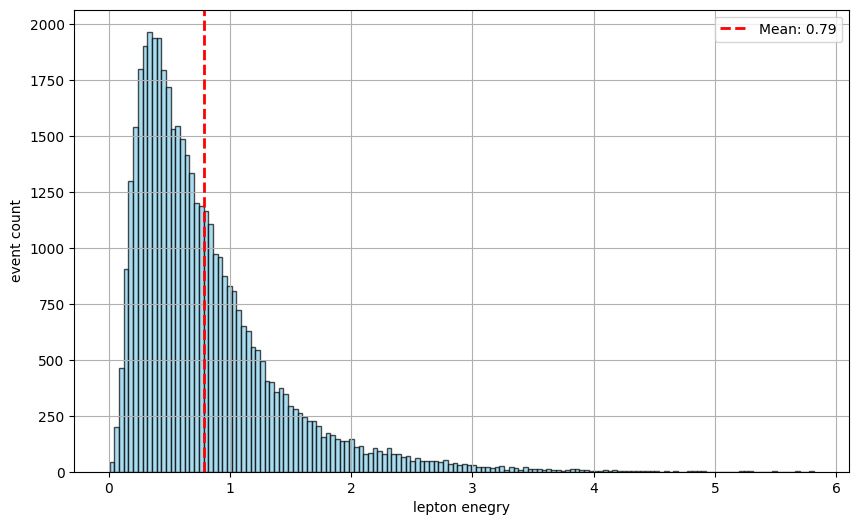

In [31]:
import matplotlib.pyplot as plt
import numpy as np

lep_energy = combined_dataset['lep_energy'].dropna()

# Calculate statistics
mean_val = lep_energy.mean()
median_val = lep_energy.median()
q25 = lep_energy.quantile(0.25)
q75 = lep_energy.quantile(0.75)

plt.figure(figsize=(10, 6))
lep_energy.hist(bins=150, alpha=0.7, color='skyblue', edgecolor='black')

# Mark average, median, 25th and 75th percentiles
plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
# plt.axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Median: {median_val:.2f}')
# plt.axvline(q25, color='orange', linestyle=':', linewidth=2, label=f'25th percentile: {q25:.2f}')
# plt.axvline(q75, color='purple', linestyle=':', linewidth=2, label=f'75th percentile: {q75:.2f}')

plt.xlabel('lepton enegry')
plt.ylabel('event count')
# plt.title('Histogram of lepton enegry for electron neutrino events')
plt.legend()
plt.show()

In [37]:
import pandas as pd
import numpy as np

# Replace with your DataFrame
df = combined_dataset

# Total events
total_events = len(df)

# Count by nu_pdg
pdg_counts = df['nu_pdg'].value_counts().sort_index()
n_mu = pdg_counts.get(14, 0)
n_mu_bar = pdg_counts.get(-14, 0)
n_e = pdg_counts.get(12, 0)
n_e_bar = pdg_counts.get(-12, 0)

# Charged-current and neutral-current
n_cc = (df['is_cc'] == 1).sum()
n_nc = (df['is_cc'] == 0).sum()

# CC subset: muon and electron flavor
cc_df = df[df['is_cc'] == 1]
cc_mu = cc_df['nu_pdg'].isin([14, -14]).sum()
cc_e = cc_df['nu_pdg'].isin([12, -12]).sum()

# Energy stats (replace 'lep_energy' with your column of interest)
energy = df['lep_energy'].dropna()
mean_e = energy.mean()
median_e = energy.median()
std_e = energy.std()
min_e = energy.min()
max_e = energy.max()
q25 = energy.quantile(0.25)
q75 = energy.quantile(0.75)

# Print results for paragraph
print(f"The sample consists of {total_events:,} events.")
print(f"Muon neutrinos (PDG 14): {n_mu:,}")
print(f"Muon antineutrinos (PDG -14): {n_mu_bar:,}")
print(f"Electron neutrinos (PDG 12): {n_e:,}")
print(f"Electron antineutrinos (PDG -12): {n_e_bar:,}")
print(f"Charged-current (CC): {n_cc:,}")
print(f"Neutral-current (NC): {n_nc:,}")
print(f"CC muon neutrino/antineutrino: {cc_mu:,}")
print(f"CC electron neutrino/antineutrino: {cc_e:,}")
print(f"lep_energy mean: {mean_e:.2f} GeV")
print(f"lep_energy median: {median_e:.2f} GeV")
print(f"lep_energy std: {std_e:.2f} GeV")
print(f"lep_energy min: {min_e:.2f} GeV")
print(f"lep_energy max: {max_e:.2f} GeV")
print(f"lep_energy IQR: {q25:.2f} to {q75:.2f} GeV")

The sample consists of 19,940 events.
Muon neutrinos (PDG 14): 0
Muon antineutrinos (PDG -14): 0
Electron neutrinos (PDG 12): 19,448
Electron antineutrinos (PDG -12): 492
Charged-current (CC): 19,940
Neutral-current (NC): 0
CC muon neutrino/antineutrino: 0
CC electron neutrino/antineutrino: 19,940
lep_energy mean: 0.91 GeV
lep_energy median: 0.73 GeV
lep_energy std: 0.67 GeV
lep_energy min: 0.01 GeV
lep_energy max: 5.82 GeV
lep_energy IQR: 0.40 to 1.24 GeV


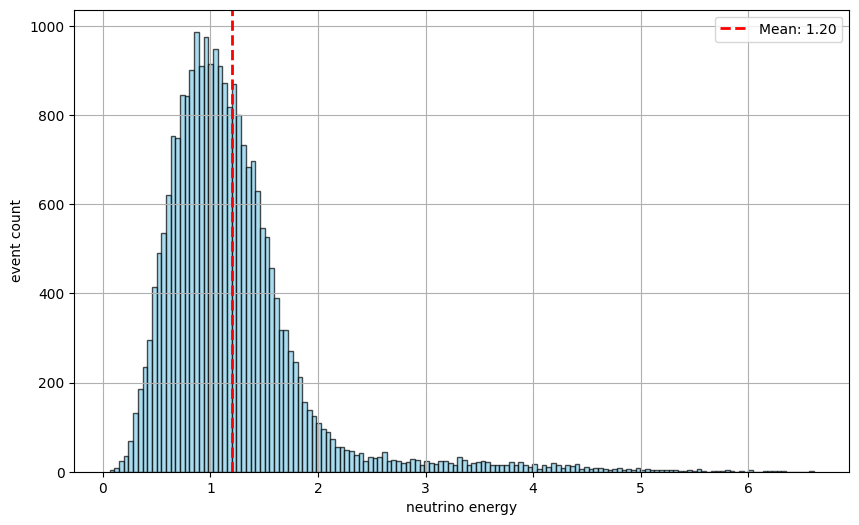

In [40]:
nu_energy = combined_dataset['nu_energy'].dropna()

# Calculate statistics
mean_val = nu_energy.mean()
median_val = nu_energy.median()
q25 = nu_energy.quantile(0.25)
q75 = nu_energy.quantile(0.75)

plt.figure(figsize=(10, 6))
nu_energy.hist(bins=150, alpha=0.7, color='skyblue', edgecolor='black')

# Mark average, median, 25th and 75th percentiles
plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
# plt.axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Median: {median_val:.2f}')
# plt.axvline(q25, color='orange', linestyle=':', linewidth=2, label=f'25th percentile: {q25:.2f}')
# plt.axvline(q75, color='purple', linestyle=':', linewidth=2, label=f'75th percentile: {q75:.2f}')

plt.xlabel('neutrino energy')
plt.ylabel('event count')
# plt.title('Histogram of neutrino energy for electron neutrino events')
plt.legend()
plt.show()

In [40]:
import os

def average_png_size(directory):
    """
    Calculates the average size (in bytes) of all PNG files in the given directory.
    """
    png_files = [f for f in os.listdir(directory) if f.lower().endswith('.png')]
    if not png_files:
        return 0
    total_size = sum(os.path.getsize(os.path.join(directory, f)) for f in png_files)
    return total_size / len(png_files)

# Example usage:
# avg_size = average_png_size('/path/to/your/directory')
# print(f"Average PNG size:

In [41]:
average_png_size('/microboonePickled')

0

In [50]:
import torch

def compare_sparse_dense_sizes(df, tensor_column='plane0_sparse_tensor'):
    """
    Calculates total memory usage (in MB) for sparse and dense tensors in the given column of the DataFrame.
    Returns (total_sparse_mb, total_dense_mb).
    """
    total_sparse_bytes = 0
    total_dense_bytes = 0

    for tensor in df[tensor_column]:
        if tensor is not None:
            # Sparse tensor memory
            tensor = tensor.coalesce()
            indices_mem = tensor.indices().numel() * tensor.indices().element_size()
            values_mem = tensor.values().numel() * tensor.values().element_size()
            total_sparse_bytes += indices_mem + values_mem

            # Dense tensor memory
            dense = tensor.to_dense()
            total_dense_bytes += dense.numel() * dense.element_size()

    total_sparse_mb = total_sparse_bytes / (1024 ** 2)
    total_dense_mb = total_dense_bytes / (1024 ** 2)
    print(f"Total sparse tensor memory: {total_sparse_mb:.2f} MB")
    print(f"Total dense tensor memory: {total_dense_mb:.2f} MB")
    return total_sparse_mb, total_dense_mb

# Example usage:
#

In [51]:
avg_sparse_mb, avg_dense_mb = compare_sparse_dense_sizes(combined_dataset, tensor_column='plane0_sparse_tensor')

Total sparse tensor memory: 5136.23 MB
Total dense tensor memory: 48696.85 MB


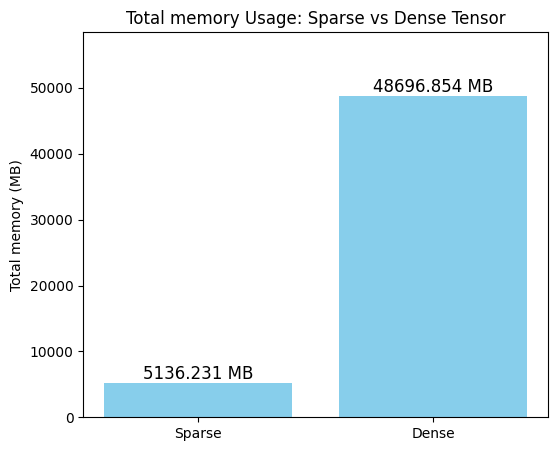

In [53]:
import matplotlib.pyplot as plt

# Data
labels = ['Sparse', 'Dense']
avg_mem = [avg_sparse_mb, avg_dense_mb]

plt.figure(figsize=(6, 5))
bars = plt.bar(labels, avg_mem, color=['skyblue', 'skyblue'])
plt.ylabel('Total memory (MB)')
plt.title('Total memory Usage: Sparse vs Dense Tensor')
plt.ylim(0, max(avg_mem) * 1.2)

# Annotate bars with values
for bar, val in zip(bars, avg_mem):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.05, f"{val:.3f} MB", 
             ha='center', va='bottom', fontsize=12)

plt.show()

In [43]:
combined_dataset.columns

Index(['run', 'subrun', 'event', 'lep_energy', 'is_cc', 'nu_energy', 'nu_pdg',
       'plane0_file', 'plane1_file', 'plane2_file', 'plane0_sparse_tensor',
       'plane1_sparse_tensor', 'plane2_sparse_tensor', 'is_cc_nue'],
      dtype='object')

In [37]:

train_model(
    combined_dataset=combined_dataset,
    model_class=AlexCNNLayer,
    eventdataset_class=EventDataset,
    channels=1,
    scale_factor=0.5,
    label_column='is_cc_nue',
    # output_dir="output_SimpleCNN_1ch_balanced_all_events_dataset"
)

Using device: cuda
GPU: Tesla V100-PCIE-16GB
Splitting dataset...
Dataset split - Train: 30990, Val: 6641, Test: 6641
Train class distribution: {0: 16957, 1: 14033}
Val class distribution: {0: 3634, 1: 3007}
Test class distribution: {0: 3634, 1: 3007}
[1, 20] loss: 0.890
[1, 40] loss: 1.047
[1, 60] loss: 0.988
[1, 80] loss: 0.770
[1, 100] loss: 0.740
[1, 120] loss: 0.731
[1, 140] loss: 0.702
[1, 160] loss: 0.714
[1, 180] loss: 0.696
[1, 200] loss: 0.702
[1, 220] loss: 0.709
[1, 240] loss: 0.713
[1, 260] loss: 0.691
[1, 280] loss: 0.678
[1, 300] loss: 0.681
[1, 320] loss: 0.689
[1, 340] loss: 0.687
[1, 360] loss: 0.680
[1, 380] loss: 0.691
[1, 400] loss: 0.687
[1, 420] loss: 0.684
[1, 440] loss: 0.674
[1, 460] loss: 0.682
[1, 480] loss: 0.696
[1, 500] loss: 0.660
[1, 520] loss: 0.703
[1, 540] loss: 0.681
[1, 560] loss: 0.671
[1, 580] loss: 0.655
[1, 600] loss: 0.670
[1, 620] loss: 0.684
[1, 640] loss: 0.677
[1, 660] loss: 0.675
[1, 680] loss: 0.662
[1, 700] loss: 0.676
[1, 720] loss: 0.

{'train_losses': [5.565371513366699,
  5.082619339227676,
  4.490948796272278,
  4.716954916715622,
  4.357471406459808,
  3.6137425899505615,
  3.337564691901207,
  3.206538110971451,
  3.4655248820781708,
  3.2231093794107437],
 'val_accuracies': [0.6765547357325704,
  0.6899563318777293,
  0.6261105255232645,
  0.7760879385634694,
  0.783315765697937,
  0.6017166089444361,
  0.767504893841289,
  0.7903930131004366,
  0.7790995332028309,
  0.7938563469357025],
 'best_val_accuracy': 0.7938563469357025,
 'test_accuracy': 0.7931034482758621}

In [10]:
def run_scale_factor_experiments(output_base_dir="experiments"):
    """
    Runs training experiments for different scale factors, models, and datasets.
    """
    scale_factors = [0.33, 0.5]
    model_classes = [SimpleCNN]
    model_names = ["LeNET"]
    
    # Define dataset configurations
    dataset_configs = {
        'full': {
            'name': 'full_dataset',
            'loader_func': get_full_dataset,
            'description': 'All events'
        },
        'top50': {
            'name': 'top50_dataset', 
            'loader_func': get_top50_events_dataset,
            'description': 'Top 50% energy events'
        }
    }
    
    experiment_results = {}
    
    # Load datasets once
    print("Loading datasets...")
    datasets = {}
    for dataset_key, config in dataset_configs.items():
        print(f"Loading {config['description']}...")
        datasets[dataset_key] = config['loader_func']('/microboonePickled')
        print(f"{config['description']} loaded: {len(datasets[dataset_key])} samples")
        print(f"Class distribution: {datasets[dataset_key]['is_cc_nue'].value_counts().to_dict()}")
    
    # Run experiments for each combination
    for dataset_key, dataset in datasets.items():
        dataset_name = dataset_configs[dataset_key]['name']
        
        for scale_factor in scale_factors:
            for model_class, model_name in zip(model_classes, model_names):
                experiment_name = f"{model_name}_1ch_{dataset_name}_scale{scale_factor}"
                print(f"\n{'='*80}")
                print(f"Starting experiment: {experiment_name}")
                print(f"Dataset: {dataset_configs[dataset_key]['description']}")
                print(f"Model: {model_name}, Scale: {scale_factor}")
                print(f"{'='*80}")
                
                try:
                    history, history_path = train_model(
                        combined_dataset=dataset,
                        model_class=model_class,
                        eventdataset_class=EventDataset,
                        channels=1,
                        scale_factor=scale_factor,
                        label_column='is_cc_nue',
                        output_dir=output_base_dir,
                        experiment_name=experiment_name,
                        num_epochs=10,
                        batch_size=32
                    )
                    
                    experiment_results[experiment_name] = {
                        'history': history,
                        'history_path': history_path,
                        'scale_factor': scale_factor,
                        'model_name': model_name,
                        'dataset_name': dataset_name,
                        'dataset_size': len(dataset)
                    }
                    
                    print(f"Experiment {experiment_name} completed successfully!")
                    print(f"Test accuracy: {history['test_accuracy']:.4f}")
                    
                    # Clear GPU memory between experiments
                    import gc
                    gc.collect()
                    torch.cuda.empty_cache()
                    
                except Exception as e:
                    print(f"Experiment {experiment_name} failed with error: {e}")
                    continue
    
    return experiment_results, datasets

In [12]:
def plot_experiment_comparison_multi_dataset(experiment_results, save_dir="analysis_plots"):
    """
    Creates comparison plots for all experiments across datasets.
    """
    os.makedirs(save_dir, exist_ok=True)
    
    scale_factors = [0.33, 0.5]
    models = ['SimpleCNN', 'AlexCNN']
    datasets = ['full_dataset', 'top50_dataset']
    
    # Create a comprehensive comparison plot
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Model Performance Comparison Across Datasets and Scale Factors', fontsize=16)
    
    # Plot 1: Test Accuracy by Scale Factor for Full Dataset
    ax1 = axes[0, 0]
    for model in models:
        accuracies = []
        for scale in scale_factors:
            exp_name = f"{model}_1ch_full_dataset_scale{scale}"
            if exp_name in experiment_results:
                accuracies.append(experiment_results[exp_name]['history']['test_accuracy'])
            else:
                accuracies.append(0)
        ax1.plot(scale_factors, accuracies, marker='o', linewidth=2, label=model)
    ax1.set_xlabel('Scale Factor')
    ax1.set_ylabel('Test Accuracy')
    ax1.set_title('Full Dataset - Test Accuracy vs Scale Factor')
    ax1.legend()
    ax1.grid(True)
    
    # Plot 2: Test Accuracy by Scale Factor for Top50 Dataset
    ax2 = axes[0, 1]
    for model in models:
        accuracies = []
        for scale in scale_factors:
            exp_name = f"{model}_1ch_top50_dataset_scale{scale}"
            if exp_name in experiment_results:
                accuracies.append(experiment_results[exp_name]['history']['test_accuracy'])
            else:
                accuracies.append(0)
        ax2.plot(scale_factors, accuracies, marker='s', linewidth=2, label=model)
    ax2.set_xlabel('Scale Factor')
    ax2.set_ylabel('Test Accuracy')
    ax2.set_title('Top50 Dataset - Test Accuracy vs Scale Factor')
    ax2.legend()
    ax2.grid(True)
    
    # Plot 3: Side-by-side comparison for best scale factor
    ax3 = axes[0, 2]
    best_results = {}
    for dataset in datasets:
        for model in models:
            best_acc = 0
            best_scale = 0
            for scale in scale_factors:
                exp_name = f"{model}_1ch_{dataset}_scale{scale}"
                if exp_name in experiment_results:
                    acc = experiment_results[exp_name]['history']['test_accuracy']
                    if acc > best_acc:
                        best_acc = acc
                        best_scale = scale
            best_results[f"{model}_{dataset}"] = {'accuracy': best_acc, 'scale': best_scale}
    
    labels = []
    accuracies = []
    colors = []
    for key, value in best_results.items():
        labels.append(key.replace('_', '\n'))
        accuracies.append(value['accuracy'])
        if 'SimpleCNN' in key:
            colors.append('lightblue' if 'full' in key else 'lightcoral')
        else:
            colors.append('lightgreen' if 'full' in key else 'lightyellow')
    
    bars = ax3.bar(labels, accuracies, color=colors)
    ax3.set_ylabel('Best Test Accuracy')
    ax3.set_title('Best Performance by Model-Dataset Combination')
    ax3.tick_params(axis='x', rotation=45)
    
    # Add accuracy values on bars
    for bar, acc in zip(bars, accuracies):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
                f'{acc:.3f}', ha='center', va='bottom', fontsize=10)
    
    # Plot 4: Validation accuracy comparison
    ax4 = axes[1, 0]
    for dataset in datasets:
        for model in models:
            val_accs = []
            for scale in scale_factors:
                exp_name = f"{model}_1ch_{dataset}_scale{scale}"
                if exp_name in experiment_results:
                    val_accs.append(max(experiment_results[exp_name]['history']['epoch_val_accuracies']))
                else:
                    val_accs.append(0)
            label = f"{model}_{dataset.split('_')[0]}"
            linestyle = '-' if 'full' in dataset else '--'
            ax4.plot(scale_factors, val_accs, marker='o', linewidth=2, label=label, linestyle=linestyle)
    ax4.set_xlabel('Scale Factor')
    ax4.set_ylabel('Best Validation Accuracy')
    ax4.set_title('Validation Accuracy Comparison')
    ax4.legend()
    ax4.grid(True)
    
    # Plot 5: F1-Score comparison
    ax5 = axes[1, 1]
    x = np.arange(len(scale_factors))
    width = 0.2
    
    for i, dataset in enumerate(datasets):
        for j, model in enumerate(models):
            f1_scores = []
            for scale in scale_factors:
                exp_name = f"{model}_1ch_{dataset}_scale{scale}"
                if exp_name in experiment_results:
                    f1_scores.append(experiment_results[exp_name]['history']['test_metrics']['f1_score'])
                else:
                    f1_scores.append(0)
            
            offset = (i * len(models) + j - 1.5) * width
            label = f"{model}_{dataset.split('_')[0]}"
            ax5.bar(x + offset, f1_scores, width, label=label, alpha=0.8)
    
    ax5.set_xlabel('Scale Factor')
    ax5.set_ylabel('F1-Score')
    ax5.set_title('F1-Score by Scale Factor')
    ax5.set_xticks(x)
    ax5.set_xticklabels(scale_factors)
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    # Plot 6: Summary statistics table
    ax6 = axes[1, 2]
    ax6.axis('off')
    
    # Create summary table data
    table_data = [['Model-Dataset', 'Best Acc', 'Best Scale', 'Avg F1']]
    
    for dataset in datasets:
        for model in models:
            best_acc = 0
            best_scale = 0
            f1_scores = []
            
            for scale in scale_factors:
                exp_name = f"{model}_1ch_{dataset}_scale{scale}"
                if exp_name in experiment_results:
                    acc = experiment_results[exp_name]['history']['test_accuracy']
                    f1 = experiment_results[exp_name]['history']['test_metrics']['f1_score']
                    f1_scores.append(f1)
                    if acc > best_acc:
                        best_acc = acc
                        best_scale = scale
            
            avg_f1 = np.mean(f1_scores) if f1_scores else 0
            row_name = f"{model}_{dataset.split('_')[0]}"
            table_data.append([row_name, f'{best_acc:.3f}', f'{best_scale}', f'{avg_f1:.3f}'])
    
    table = ax6.table(cellText=table_data, cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 1.5)
    ax6.set_title('Performance Summary')
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'multi_dataset_experiment_comparison.png'), dpi=300, bbox_inches='tight')
    plt.show()

def plot_dataset_comparison(experiment_results, save_dir="analysis_plots"):
    """
    Creates plots specifically comparing performance between full and top50 datasets.
    """
    os.makedirs(save_dir, exist_ok=True)
    
    scale_factors = [0.33, 0.5]
    models = ['AlexCNN']
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Dataset Comparison: Full vs Top50% Energy Events', fontsize=16)
    
    for i, model in enumerate(models):
        # Test Accuracy comparison
        ax1 = axes[i, 0]
        
        full_accs = []
        top50_accs = []
        
        for scale in scale_factors:
            full_exp = f"{model}_1ch_full_dataset_scale{scale}"
            top50_exp = f"{model}_1ch_top50_dataset_scale{scale}"
            
            full_acc = experiment_results[full_exp]['history']['test_accuracy'] if full_exp in experiment_results else 0
            top50_acc = experiment_results[top50_exp]['history']['test_accuracy'] if top50_exp in experiment_results else 0
            
            full_accs.append(full_acc)
            top50_accs.append(top50_acc)
        
        ax1.plot(scale_factors, full_accs, marker='o', linewidth=2, label='Full Dataset', color='blue')
        ax1.plot(scale_factors, top50_accs, marker='s', linewidth=2, label='Top50% Dataset', color='red')
        ax1.set_xlabel('Scale Factor')
        ax1.set_ylabel('Test Accuracy')
        ax1.set_title(f'{model} - Test Accuracy Comparison')
        ax1.legend()
        ax1.grid(True)
        
        # F1-Score comparison
        ax2 = axes[i, 1]
        
        full_f1s = []
        top50_f1s = []
        
        for scale in scale_factors:
            full_exp = f"{model}_1ch_full_dataset_scale{scale}"
            top50_exp = f"{model}_1ch_top50_dataset_scale{scale}"
            
            full_f1 = experiment_results[full_exp]['history']['test_metrics']['f1_score'] if full_exp in experiment_results else 0
            top50_f1 = experiment_results[top50_exp]['history']['test_metrics']['f1_score'] if top50_exp in experiment_results else 0
            
            full_f1s.append(full_f1)
            top50_f1s.append(top50_f1)
        
        ax2.plot(scale_factors, full_f1s, marker='o', linewidth=2, label='Full Dataset', color='blue')
        ax2.plot(scale_factors, top50_f1s, marker='s', linewidth=2, label='Top50% Dataset', color='red')
        ax2.set_xlabel('Scale Factor')
        ax2.set_ylabel('F1-Score')
        ax2.set_title(f'{model} - F1-Score Comparison')
        ax2.legend()
        ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'dataset_comparison.png'), dpi=300, bbox_inches='tight')
    plt.show()

In [13]:
def plot_individual_training_curves(experiment_results, save_dir="analysis_plots"):
    """
    Plots training curves for each individual experiment.
    """
    os.makedirs(save_dir, exist_ok=True)
    
    for exp_name, exp_data in experiment_results.items():
        history = exp_data['history']
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle(f'Training Analysis: {exp_name}', fontsize=16)
        
        # Plot 1: Loss curves
        axes[0, 0].plot(history['epoch_train_accuracies'], label='Train Accuracy')
        axes[0, 0].plot(history['epoch_val_accuracies'], label='Validation Accuracy')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Accuracy')
        axes[0, 0].set_title('Accuracy per Epoch')
        axes[0, 0].legend()
        axes[0, 0].grid(True)
        
        # Plot 2: Validation loss
        axes[0, 1].plot(history['epoch_val_losses'], label='Validation Loss', color='red')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Loss')
        axes[0, 1].set_title('Validation Loss per Epoch')
        axes[0, 1].legend()
        axes[0, 1].grid(True)
        
        # Plot 3: Iteration losses (smoothed)
        iteration_losses = history['iteration_losses']
        window_size = min(50, len(iteration_losses) // 10)
        if window_size > 1:
            smoothed_losses = np.convolve(iteration_losses, np.ones(window_size)/window_size, mode='valid')
            axes[1, 0].plot(smoothed_losses)
        else:
            axes[1, 0].plot(iteration_losses)
        axes[1, 0].set_xlabel('Iteration')
        axes[1, 0].set_ylabel('Loss')
        axes[1, 0].set_title('Training Loss (Smoothed)')
        axes[1, 0].grid(True)
        
        # Plot 4: Metrics summary
        axes[1, 1].axis('off')
        metrics_text = f"""
        Final Test Accuracy: {history['test_accuracy']:.4f}
        Best Validation Accuracy: {history['best_val_accuracy']:.4f}
        Scale Factor: {exp_data['scale_factor']}
        Model: {exp_data['model_name']}
        
        Test Metrics:
        Precision: {history['test_metrics']['precision']:.4f}
        Recall: {history['test_metrics']['recall']:.4f}
        F1-Score: {history['test_metrics']['f1_score']:.4f}
        """
        axes[1, 1].text(0.1, 0.5, metrics_text, fontsize=12, verticalalignment='center')
        axes[1, 1].set_title('Summary Metrics')
        
        plt.tight_layout()
        plot_path = os.path.join(save_dir, f'training_curves_{exp_name}.png')
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        plt.show()

In [14]:
def main():
    print("Starting multi-dataset scale factor experiments...")
    
    # Run all experiments
    experiment_results, datasets = run_scale_factor_experiments(
        output_base_dir="multi_dataset_experiments"
    )
    
    # Print dataset info
    for dataset_key, dataset in datasets.items():
        print(f"\n{dataset_key.upper()} DATASET INFO:")
        print(f"Size: {len(dataset)} samples")
        print(f"Class distribution: {dataset['is_cc_nue'].value_counts().to_dict()}")
    
    # Create analysis plots
    print("\nCreating multi-dataset comparison plots...")
    plot_experiment_comparison_multi_dataset(experiment_results, save_dir="analysis_plots")
    
    print("Creating dataset comparison plots...")
    plot_dataset_comparison(experiment_results, save_dir="analysis_plots")
    
    print("Creating ROC curve comparison plots...")
    plot_roc_comparison(experiment_results, save_dir="analysis_plots")  # Add this line
    
    print("Creating individual training curve plots...")
    plot_individual_training_curves(experiment_results, save_dir="analysis_plots")
    
    # Save comprehensive experiment summary
    # In the main function, update the summary creation:
    summary = {}
    for exp_name, exp_data in experiment_results.items():
        summary[exp_name] = {
            'test_accuracy': exp_data['history']['test_accuracy'],
            'best_val_accuracy': exp_data['history']['best_val_accuracy'],
            'scale_factor': exp_data['scale_factor'],
            'model_name': exp_data['model_name'],
            'dataset_name': exp_data['dataset_name'],
            'dataset_size': exp_data['dataset_size'],
            'precision': exp_data['history']['test_metrics']['precision'],
            'recall': exp_data['history']['test_metrics']['recall'],
            'f1_score': exp_data['history']['test_metrics']['f1_score'],
            'roc_auc': exp_data['history']['test_metrics']['roc_auc']  # Add this line
        }
    
    with open('multi_dataset_experiment_summary.json', 'w') as f:
        json.dump(summary, f, indent=2)
    
    # Find and print best configurations
    best_overall = max(summary.items(), key=lambda x: x[1]['test_accuracy'])
    best_full = max([item for item in summary.items() if 'full_dataset' in item[0]], 
                   key=lambda x: x[1]['test_accuracy'])
    best_top50 = max([item for item in summary.items() if 'top50_dataset' in item[0]], 
                    key=lambda x: x[1]['test_accuracy'])
    
    print("\n" + "="*80)
    print("EXPERIMENT RESULTS SUMMARY")
    print("="*80)
    print(f"Best overall: {best_overall[0]} - Test Accuracy: {best_overall[1]['test_accuracy']:.4f}")
    print(f"Best full dataset: {best_full[0]} - Test Accuracy: {best_full[1]['test_accuracy']:.4f}")
    print(f"Best top50 dataset: {best_top50[0]} - Test Accuracy: {best_top50[1]['test_accuracy']:.4f}")
    
    print("\nAll experiments completed!")
    print("Results saved in:")
    print("- multi_dataset_experiments/ (individual experiment data)")
    print("- analysis_plots/ (comparison plots)")
    print("- multi_dataset_experiment_summary.json (summary metrics)")
    
    return experiment_results, summary

# experiment_results, summary = main()

Starting multi-dataset scale factor experiments...
Loading datasets...
Loading All events...
Loading file: processed_parsed_data_nue_WithWire_15.pkl
Loading file: processed_parsed_data_nue_WithWire_01.pkl
Loading file: processed_parsed_data_bnb_WithWire_07.pkl
Loading file: processed_parsed_data_bnb_WithWire_04.pkl
Loading file: processed_parsed_data_nue_WithWire_09.pkl
Loading file: processed_parsed_data_nue_WithWire_10.pkl
Loading file: processed_parsed_data_nue_WithWire_17.pkl
Loading file: processed_parsed_data_nue_WithWire_03.pkl
Loading file: processed_parsed_data_bnb_WithWire_14.pkl
Loading file: processed_parsed_data_nue_WithWire_11.pkl
Loading file: processed_parsed_data_bnb_WithWire_00.pkl
Loading file: processed_parsed_data_nue_WithWire_12.pkl
Loading file: processed_parsed_data_bnb_WithWire_09.pkl
Loading file: processed_parsed_data_nue_WithWire_13.pkl
Loading file: processed_parsed_data_bnb_WithWire_02.pkl
Loading file: processed_parsed_data_bnb_WithWire_06.pkl
Loading fil

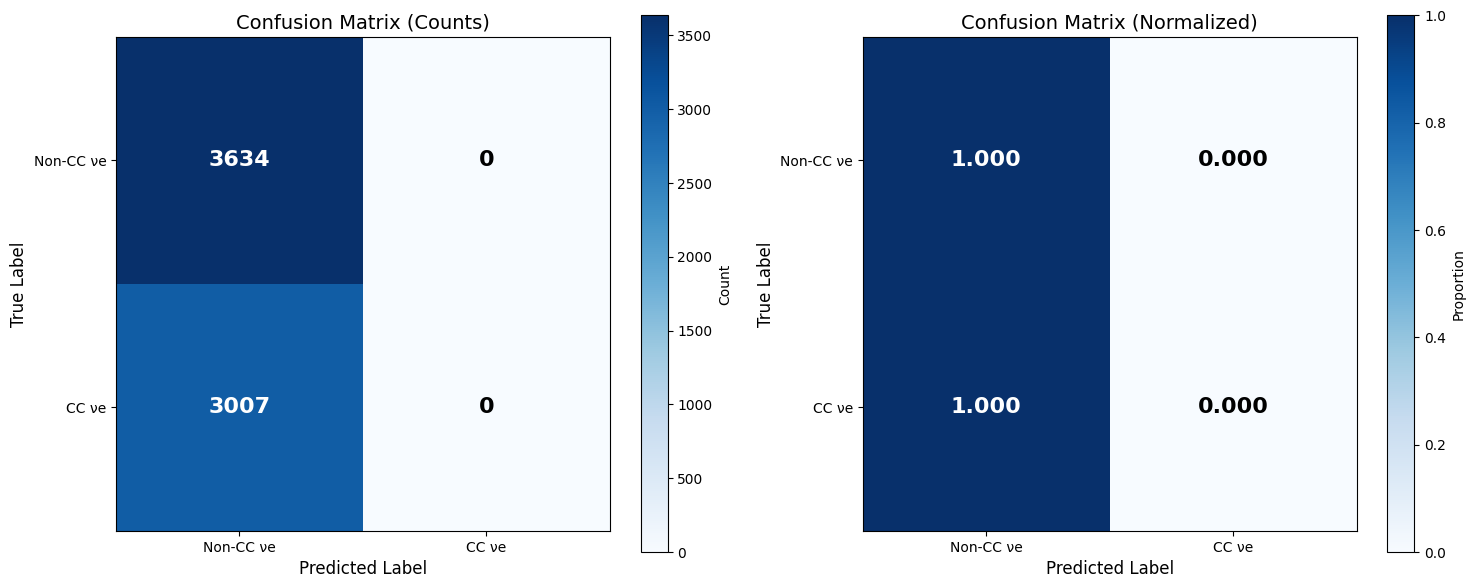


Classification Report:
              precision    recall  f1-score   support

   Non-CC νe       0.55      1.00      0.71      3634
       CC νe       0.00      0.00      0.00      3007

    accuracy                           0.55      6641
   macro avg       0.27      0.50      0.35      6641
weighted avg       0.30      0.55      0.39      6641


Detailed Metrics:
True Positives: 0
True Negatives: 3634
False Positives: 0
False Negatives: 3007
Precision: 0.0000
Recall (Sensitivity): 0.0000
Specificity: 1.0000
F1-Score: 0.0000
Finished Training


/home/wnoskow/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/wnoskow/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/wnoskow/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Experiment SimpleCNN_1ch_full_dataset_scale0.33 completed successfully!
Test accuracy: 0.5472

Starting experiment: AlexCNN_1ch_full_dataset_scale0.33
Dataset: All events
Model: AlexCNN, Scale: 0.33
Using device: cuda
GPU: Tesla V100-PCIE-16GB
Splitting dataset...
Dataset split - Train: 30990, Val: 6641, Test: 6641
Train class distribution: {0: 16957, 1: 14033}
Val class distribution: {0: 3634, 1: 3007}
Test class distribution: {0: 3634, 1: 3007}
[1, 20] loss: 0.770
[1, 40] loss: 1.082
[1, 60] loss: 0.747
[1, 80] loss: 0.765
[1, 100] loss: 0.747
[1, 120] loss: 0.725
[1, 140] loss: 0.714
[1, 160] loss: 0.718
[1, 180] loss: 0.716
[1, 200] loss: 0.738
[1, 220] loss: 0.706
[1, 240] loss: 0.692
[1, 260] loss: 0.692
[1, 280] loss: 0.689
[1, 300] loss: 0.703
[1, 320] loss: 0.678
[1, 340] loss: 0.696
[1, 360] loss: 0.700
[1, 380] loss: 0.707
[1, 400] loss: 0.674
[1, 420] loss: 0.711
[1, 440] loss: 0.683
[1, 460] loss: 0.667
[1, 480] loss: 0.688
[1, 500] loss: 0.702
[1, 520] loss: 0.692
[1, 540

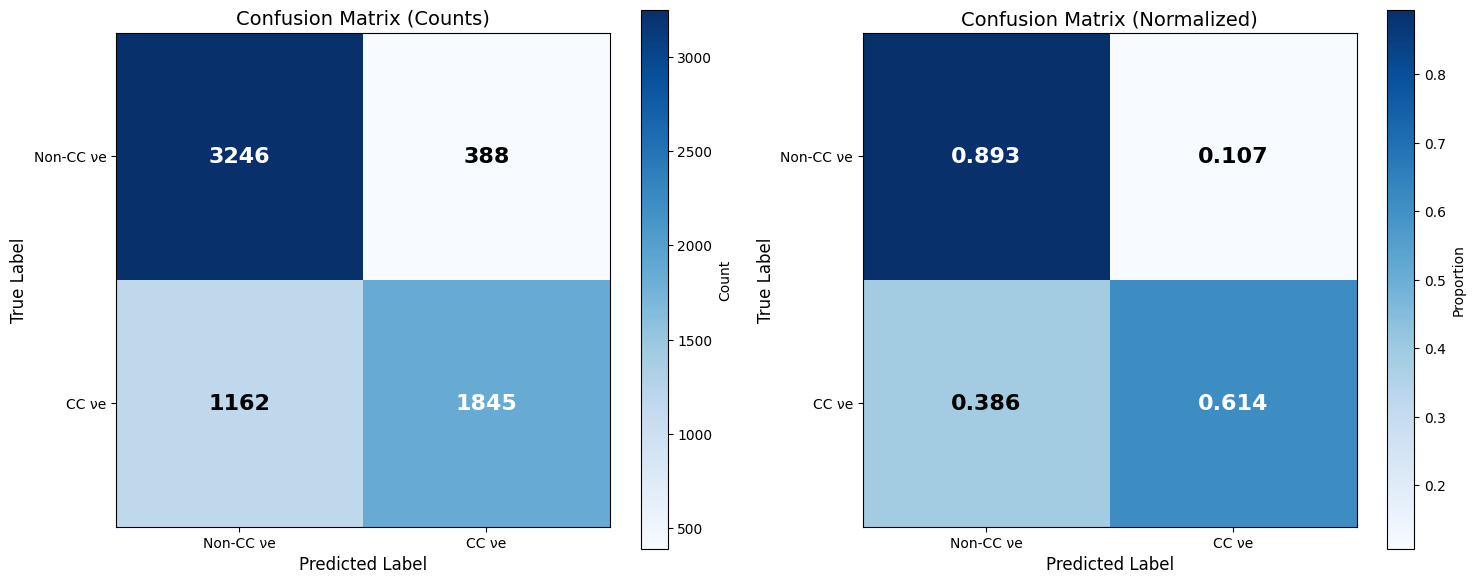


Classification Report:
              precision    recall  f1-score   support

   Non-CC νe       0.74      0.89      0.81      3634
       CC νe       0.83      0.61      0.70      3007

    accuracy                           0.77      6641
   macro avg       0.78      0.75      0.76      6641
weighted avg       0.78      0.77      0.76      6641


Detailed Metrics:
True Positives: 1845
True Negatives: 3246
False Positives: 388
False Negatives: 1162
Precision: 0.8262
Recall (Sensitivity): 0.6136
Specificity: 0.8932
F1-Score: 0.7042
Finished Training
Experiment AlexCNN_1ch_full_dataset_scale0.33 completed successfully!
Test accuracy: 0.7666

Starting experiment: SimpleCNN_1ch_full_dataset_scale0.5
Dataset: All events
Model: SimpleCNN, Scale: 0.5
Using device: cuda
GPU: Tesla V100-PCIE-16GB
Splitting dataset...
Dataset split - Train: 30990, Val: 6641, Test: 6641
Train class distribution: {0: 16957, 1: 14033}
Val class distribution: {0: 3634, 1: 3007}
Test class distribution: {0: 3634, 1

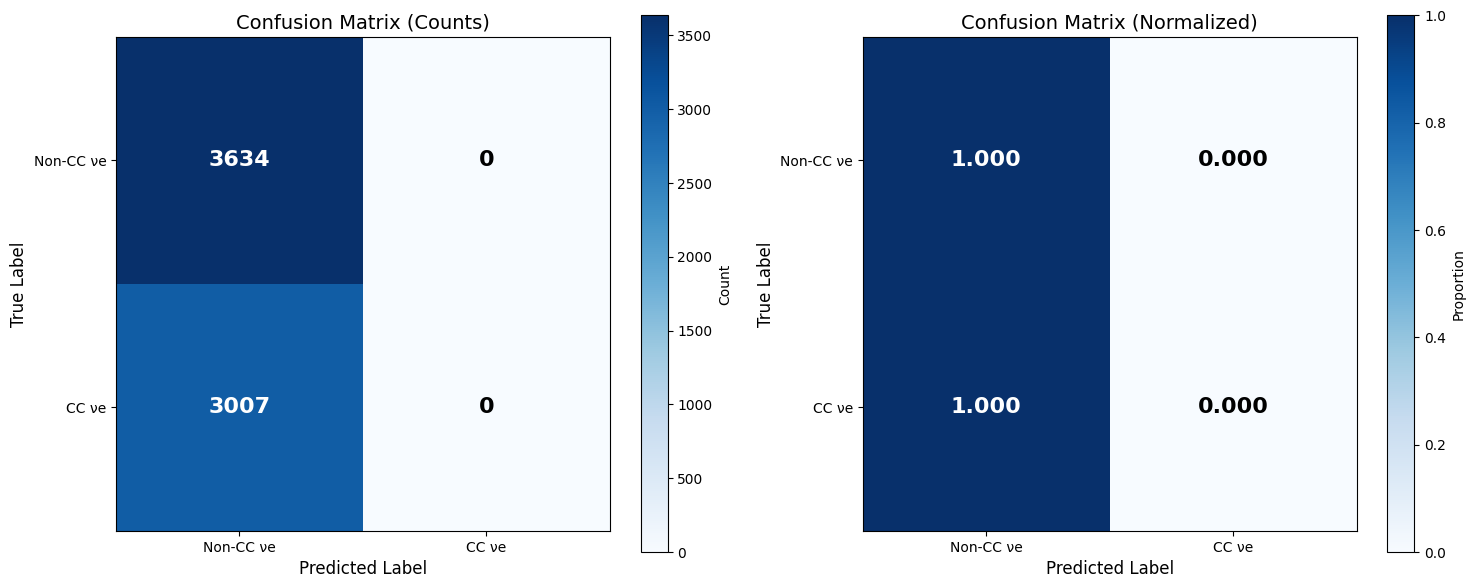


Classification Report:
              precision    recall  f1-score   support

   Non-CC νe       0.55      1.00      0.71      3634
       CC νe       0.00      0.00      0.00      3007

    accuracy                           0.55      6641
   macro avg       0.27      0.50      0.35      6641
weighted avg       0.30      0.55      0.39      6641


Detailed Metrics:
True Positives: 0
True Negatives: 3634
False Positives: 0
False Negatives: 3007
Precision: 0.0000
Recall (Sensitivity): 0.0000
Specificity: 1.0000
F1-Score: 0.0000
Finished Training


/home/wnoskow/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/wnoskow/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/wnoskow/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Experiment SimpleCNN_1ch_full_dataset_scale0.5 completed successfully!
Test accuracy: 0.5472

Starting experiment: AlexCNN_1ch_full_dataset_scale0.5
Dataset: All events
Model: AlexCNN, Scale: 0.5
Using device: cuda
GPU: Tesla V100-PCIE-16GB
Splitting dataset...
Dataset split - Train: 30990, Val: 6641, Test: 6641
Train class distribution: {0: 16957, 1: 14033}
Val class distribution: {0: 3634, 1: 3007}
Test class distribution: {0: 3634, 1: 3007}
[1, 20] loss: 0.805
[1, 40] loss: 1.293
[1, 60] loss: 0.998
[1, 80] loss: 0.777
[1, 100] loss: 0.757
[1, 120] loss: 0.754
[1, 140] loss: 0.763
[1, 160] loss: 0.705
[1, 180] loss: 0.713
[1, 200] loss: 0.699
[1, 220] loss: 0.681
[1, 240] loss: 0.708
[1, 260] loss: 0.731
[1, 280] loss: 0.700
[1, 300] loss: 0.682
[1, 320] loss: 0.684
[1, 340] loss: 0.689
[1, 360] loss: 0.684
[1, 380] loss: 0.683
[1, 400] loss: 0.679
[1, 420] loss: 0.685
[1, 440] loss: 0.688
[1, 460] loss: 0.668
[1, 480] loss: 0.688
[1, 500] loss: 0.674
[1, 520] loss: 0.693
[1, 540] l

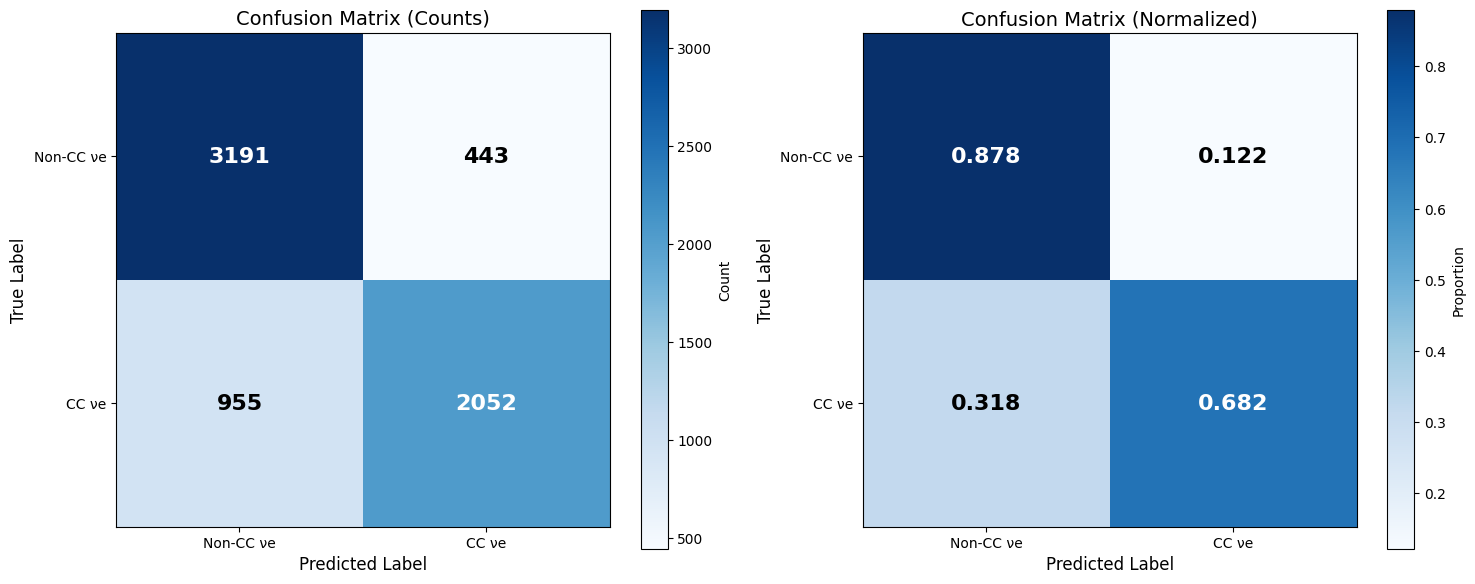


Classification Report:
              precision    recall  f1-score   support

   Non-CC νe       0.77      0.88      0.82      3634
       CC νe       0.82      0.68      0.75      3007

    accuracy                           0.79      6641
   macro avg       0.80      0.78      0.78      6641
weighted avg       0.79      0.79      0.79      6641


Detailed Metrics:
True Positives: 2052
True Negatives: 3191
False Positives: 443
False Negatives: 955
Precision: 0.8224
Recall (Sensitivity): 0.6824
Specificity: 0.8781
F1-Score: 0.7459
Finished Training
Experiment AlexCNN_1ch_full_dataset_scale0.5 completed successfully!
Test accuracy: 0.7895

Starting experiment: SimpleCNN_1ch_full_dataset_scale0.66
Dataset: All events
Model: SimpleCNN, Scale: 0.66
Using device: cuda
GPU: Tesla V100-PCIE-16GB
Splitting dataset...
Dataset split - Train: 30990, Val: 6641, Test: 6641
Train class distribution: {0: 16957, 1: 14033}
Val class distribution: {0: 3634, 1: 3007}
Test class distribution: {0: 3634, 1

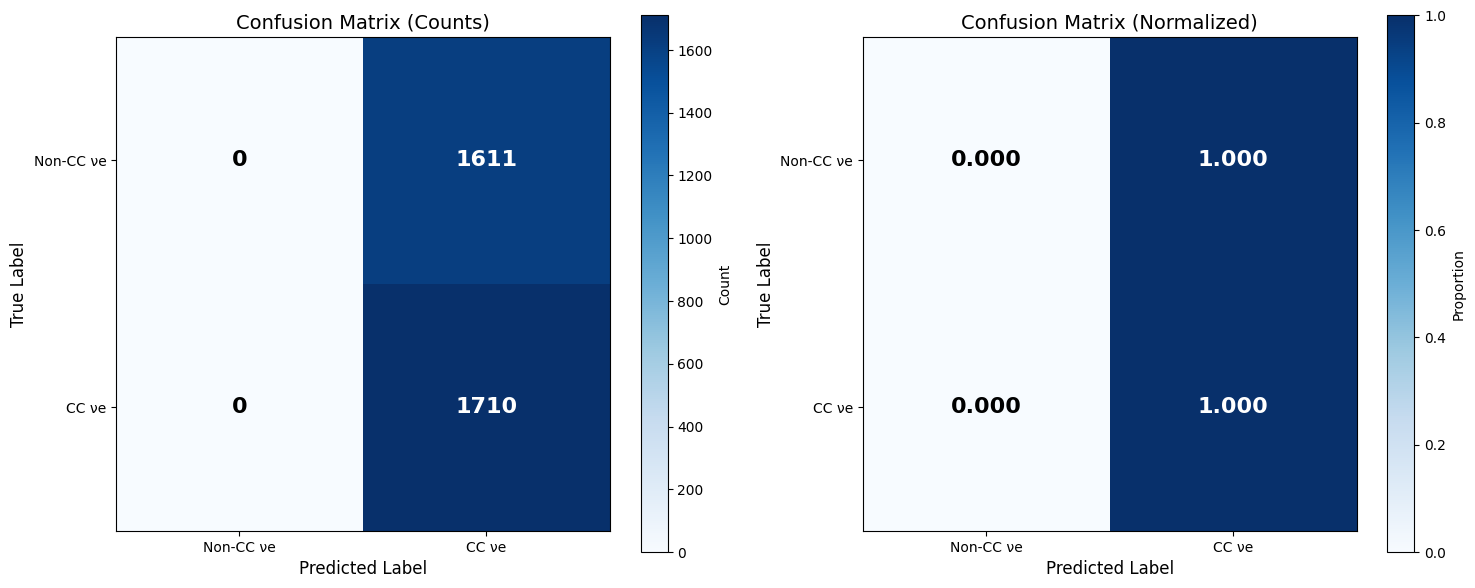


Classification Report:
              precision    recall  f1-score   support

   Non-CC νe       0.00      0.00      0.00      1611
       CC νe       0.51      1.00      0.68      1710

    accuracy                           0.51      3321
   macro avg       0.26      0.50      0.34      3321
weighted avg       0.27      0.51      0.35      3321


Detailed Metrics:
True Positives: 1710
True Negatives: 0
False Positives: 1611
False Negatives: 0
Precision: 0.5149
Recall (Sensitivity): 1.0000
Specificity: 0.0000
F1-Score: 0.6798
Finished Training


/home/wnoskow/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/wnoskow/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/wnoskow/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Experiment SimpleCNN_1ch_top50_dataset_scale0.33 completed successfully!
Test accuracy: 0.5149

Starting experiment: AlexCNN_1ch_top50_dataset_scale0.33
Dataset: Top 50% energy events
Model: AlexCNN, Scale: 0.33
Using device: cuda
GPU: Tesla V100-PCIE-16GB
Splitting dataset...
Dataset split - Train: 15494, Val: 3321, Test: 3321
Train class distribution: {1: 7977, 0: 7517}
Val class distribution: {1: 1710, 0: 1611}
Test class distribution: {1: 1710, 0: 1611}
[1, 20] loss: 0.738
[1, 40] loss: 0.976
[1, 60] loss: 0.999
[1, 80] loss: 0.746
[1, 100] loss: 0.732
[1, 120] loss: 0.691
[1, 140] loss: 0.735
[1, 160] loss: 0.713
[1, 180] loss: 0.731
[1, 200] loss: 0.722
[1, 220] loss: 0.701
[1, 240] loss: 0.680
[1, 260] loss: 0.658
[1, 280] loss: 0.675
[1, 300] loss: 0.651
[1, 320] loss: 0.662
[1, 340] loss: 0.692
[1, 360] loss: 0.648
[1, 380] loss: 0.617
[1, 400] loss: 0.641
[1, 420] loss: 0.605
[1, 440] loss: 0.607
[1, 460] loss: 0.629
[1, 480] loss: 0.628
Epoch 1: Train Acc: 0.5895, Val Acc: 0

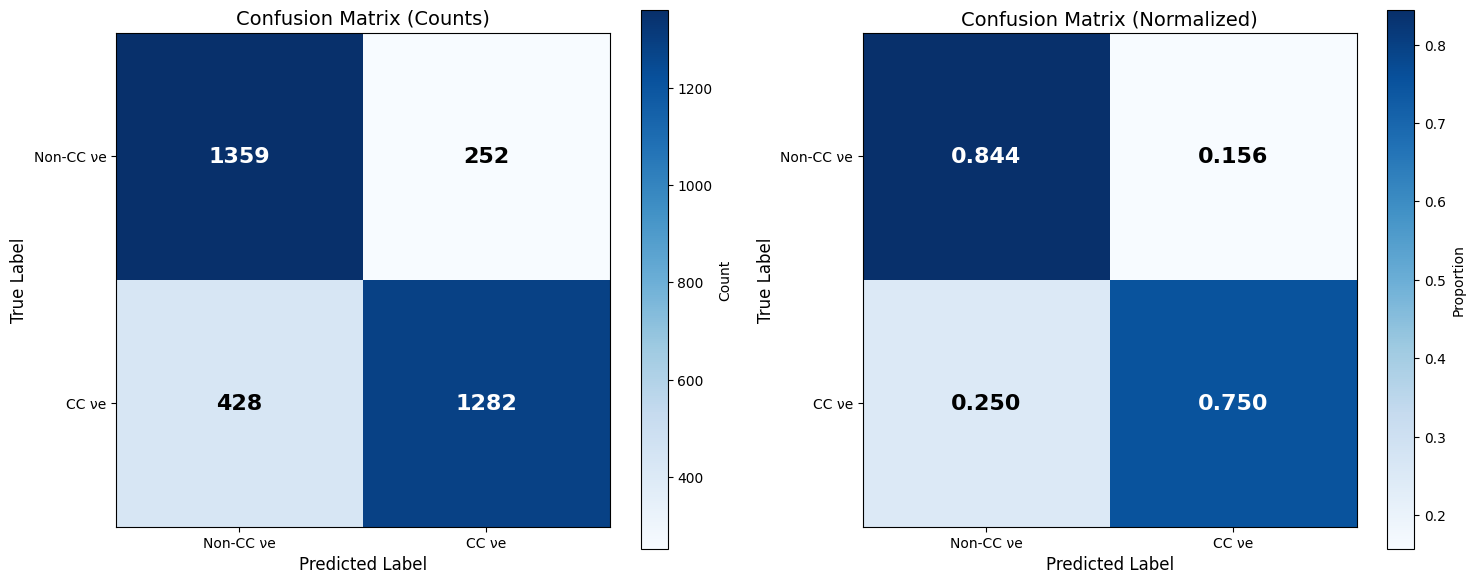


Classification Report:
              precision    recall  f1-score   support

   Non-CC νe       0.76      0.84      0.80      1611
       CC νe       0.84      0.75      0.79      1710

    accuracy                           0.80      3321
   macro avg       0.80      0.80      0.80      3321
weighted avg       0.80      0.80      0.79      3321


Detailed Metrics:
True Positives: 1282
True Negatives: 1359
False Positives: 252
False Negatives: 428
Precision: 0.8357
Recall (Sensitivity): 0.7497
Specificity: 0.8436
F1-Score: 0.7904
Finished Training
Experiment AlexCNN_1ch_top50_dataset_scale0.33 completed successfully!
Test accuracy: 0.7952

Starting experiment: SimpleCNN_1ch_top50_dataset_scale0.5
Dataset: Top 50% energy events
Model: SimpleCNN, Scale: 0.5
Using device: cuda
GPU: Tesla V100-PCIE-16GB
Splitting dataset...
Dataset split - Train: 15494, Val: 3321, Test: 3321
Train class distribution: {1: 7977, 0: 7517}
Val class distribution: {1: 1710, 0: 1611}
Test class distribution: {

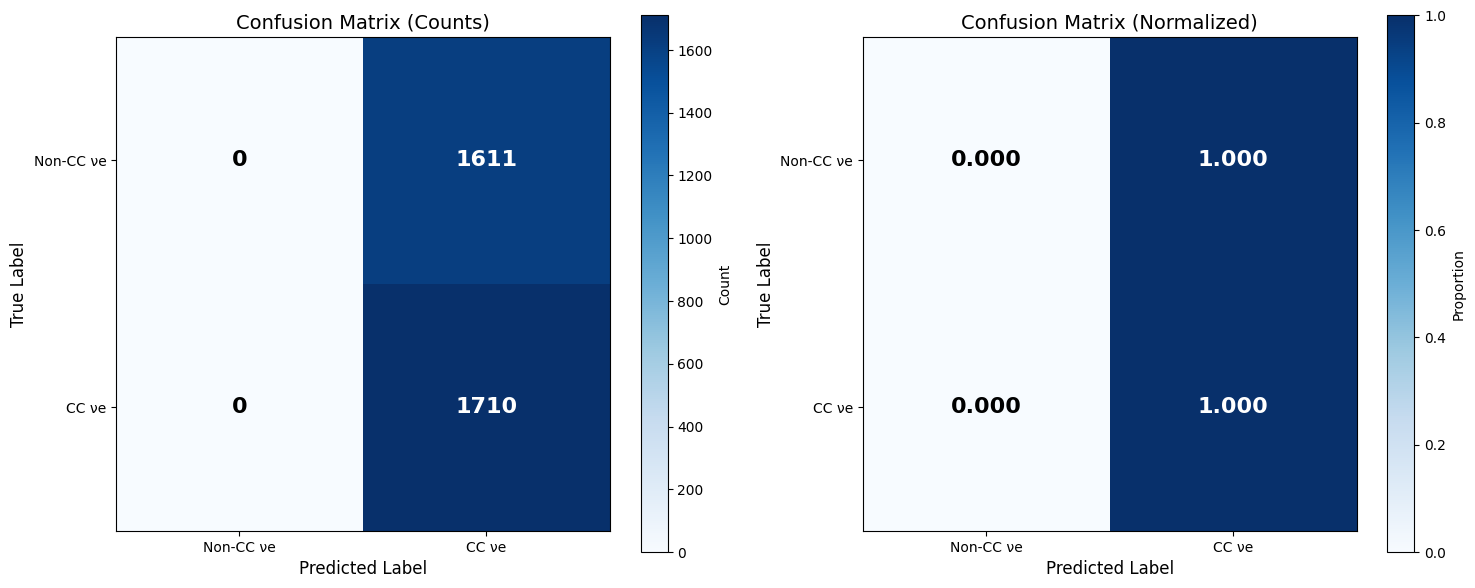


Classification Report:
              precision    recall  f1-score   support

   Non-CC νe       0.00      0.00      0.00      1611
       CC νe       0.51      1.00      0.68      1710

    accuracy                           0.51      3321
   macro avg       0.26      0.50      0.34      3321
weighted avg       0.27      0.51      0.35      3321


Detailed Metrics:
True Positives: 1710
True Negatives: 0
False Positives: 1611
False Negatives: 0
Precision: 0.5149
Recall (Sensitivity): 1.0000
Specificity: 0.0000
F1-Score: 0.6798
Finished Training


/home/wnoskow/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/wnoskow/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/wnoskow/.local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Experiment SimpleCNN_1ch_top50_dataset_scale0.5 completed successfully!
Test accuracy: 0.5149

Starting experiment: AlexCNN_1ch_top50_dataset_scale0.5
Dataset: Top 50% energy events
Model: AlexCNN, Scale: 0.5
Using device: cuda
GPU: Tesla V100-PCIE-16GB
Splitting dataset...
Dataset split - Train: 15494, Val: 3321, Test: 3321
Train class distribution: {1: 7977, 0: 7517}
Val class distribution: {1: 1710, 0: 1611}
Test class distribution: {1: 1710, 0: 1611}
[1, 20] loss: 0.863
[1, 40] loss: 1.040
[1, 60] loss: 0.944
[1, 80] loss: 0.896
[1, 100] loss: 0.863
[1, 120] loss: 0.742
[1, 140] loss: 0.728
[1, 160] loss: 0.703
[1, 180] loss: 0.732
[1, 200] loss: 0.699
[1, 220] loss: 0.689
[1, 240] loss: 0.687
[1, 260] loss: 0.688
[1, 280] loss: 0.680
[1, 300] loss: 0.683
[1, 320] loss: 0.680
[1, 340] loss: 0.667
[1, 360] loss: 0.666
[1, 380] loss: 0.657
[1, 400] loss: 0.636
[1, 420] loss: 0.637
[1, 440] loss: 0.638
[1, 460] loss: 0.616
[1, 480] loss: 0.589
Epoch 1: Train Acc: 0.5686, Val Acc: 0.63

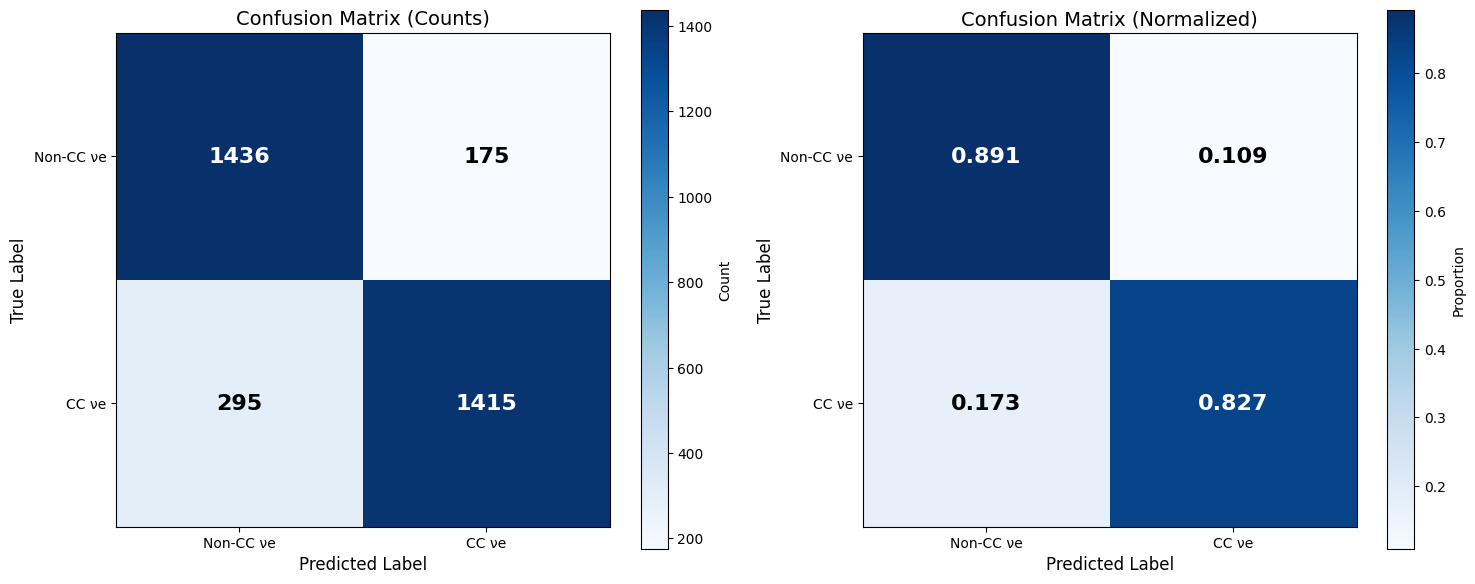


Classification Report:
              precision    recall  f1-score   support

   Non-CC νe       0.83      0.89      0.86      1611
       CC νe       0.89      0.83      0.86      1710

    accuracy                           0.86      3321
   macro avg       0.86      0.86      0.86      3321
weighted avg       0.86      0.86      0.86      3321


Detailed Metrics:
True Positives: 1415
True Negatives: 1436
False Positives: 175
False Negatives: 295
Precision: 0.8899
Recall (Sensitivity): 0.8275
Specificity: 0.8914
F1-Score: 0.8576
Finished Training
Experiment AlexCNN_1ch_top50_dataset_scale0.5 completed successfully!
Test accuracy: 0.8585

Starting experiment: SimpleCNN_1ch_top50_dataset_scale0.66
Dataset: Top 50% energy events
Model: SimpleCNN, Scale: 0.66
Using device: cuda
GPU: Tesla V100-PCIE-16GB
Splitting dataset...
Dataset split - Train: 15494, Val: 3321, Test: 3321
Train class distribution: {1: 7977, 0: 7517}
Val class distribution: {1: 1710, 0: 1611}
Test class distribution: 

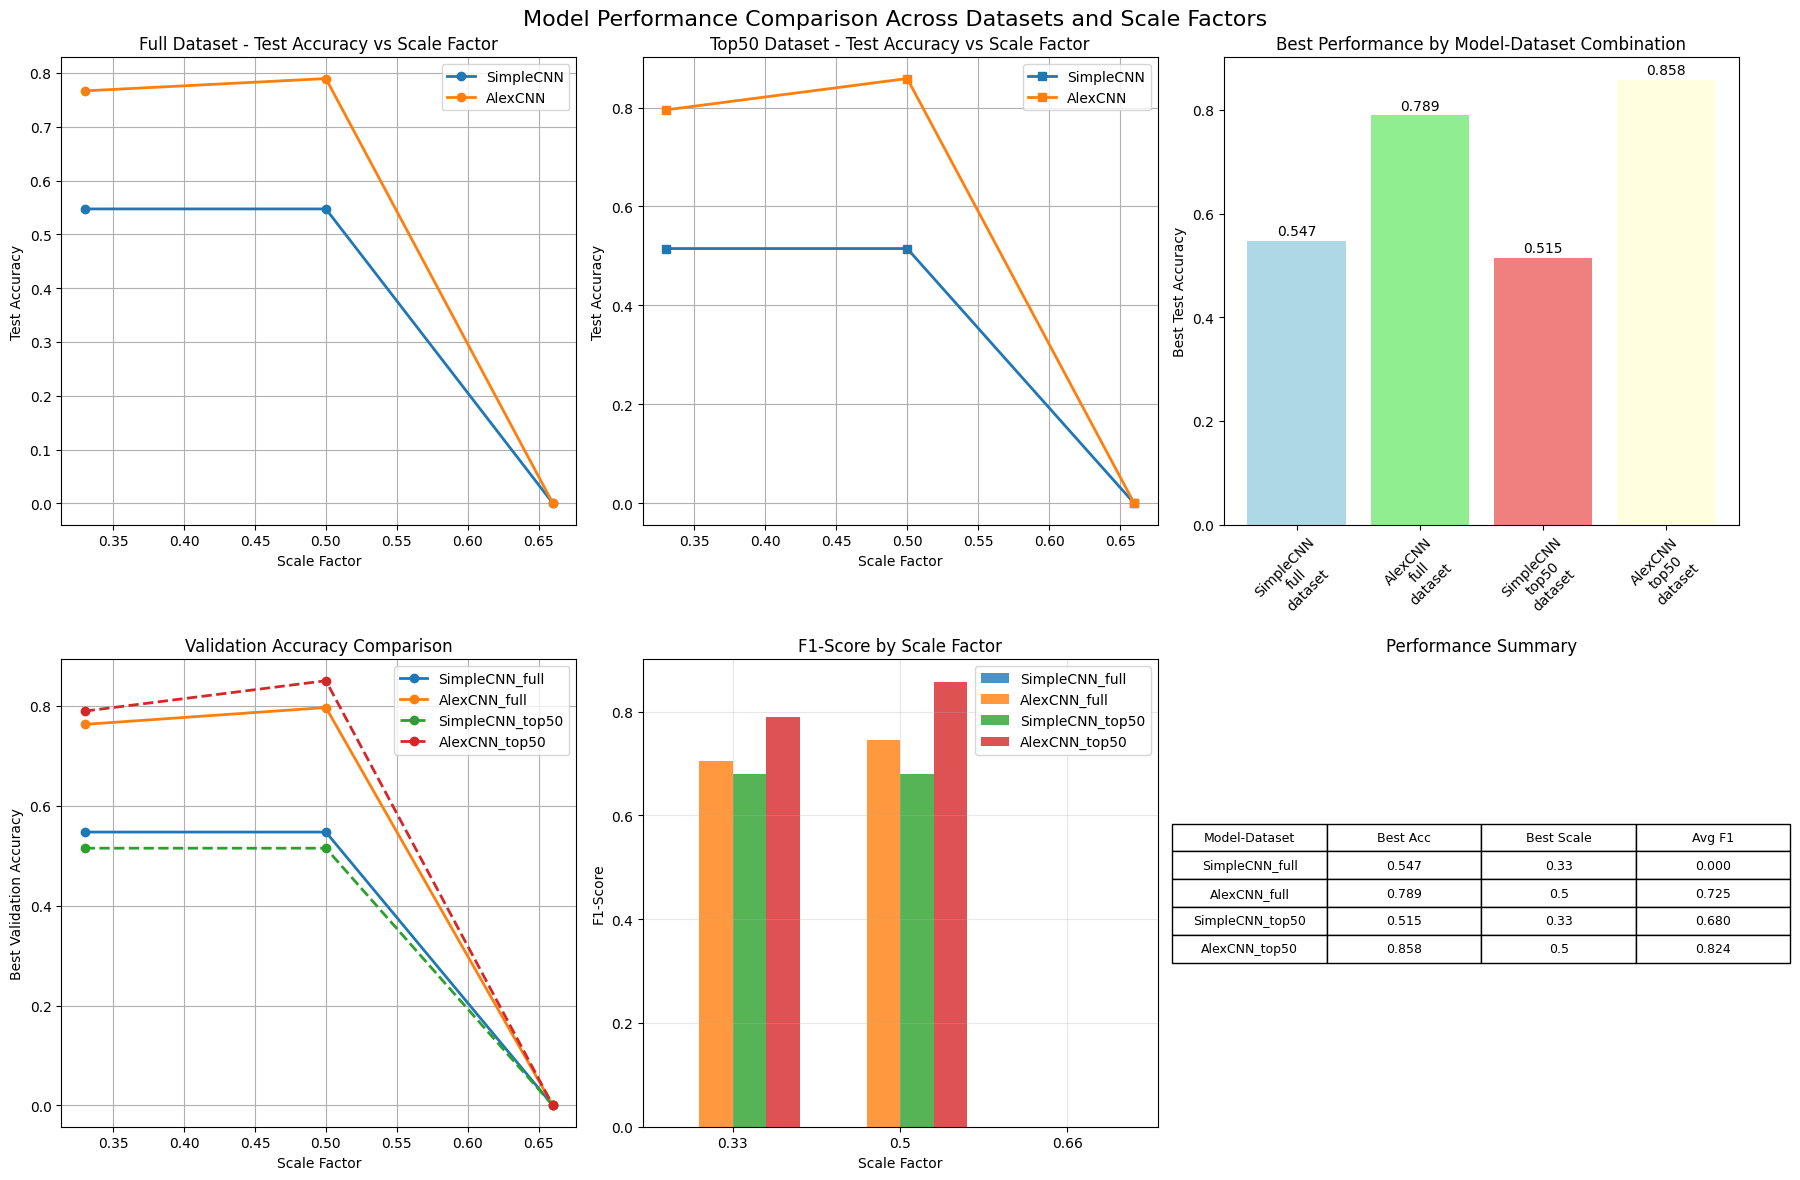

Creating dataset comparison plots...


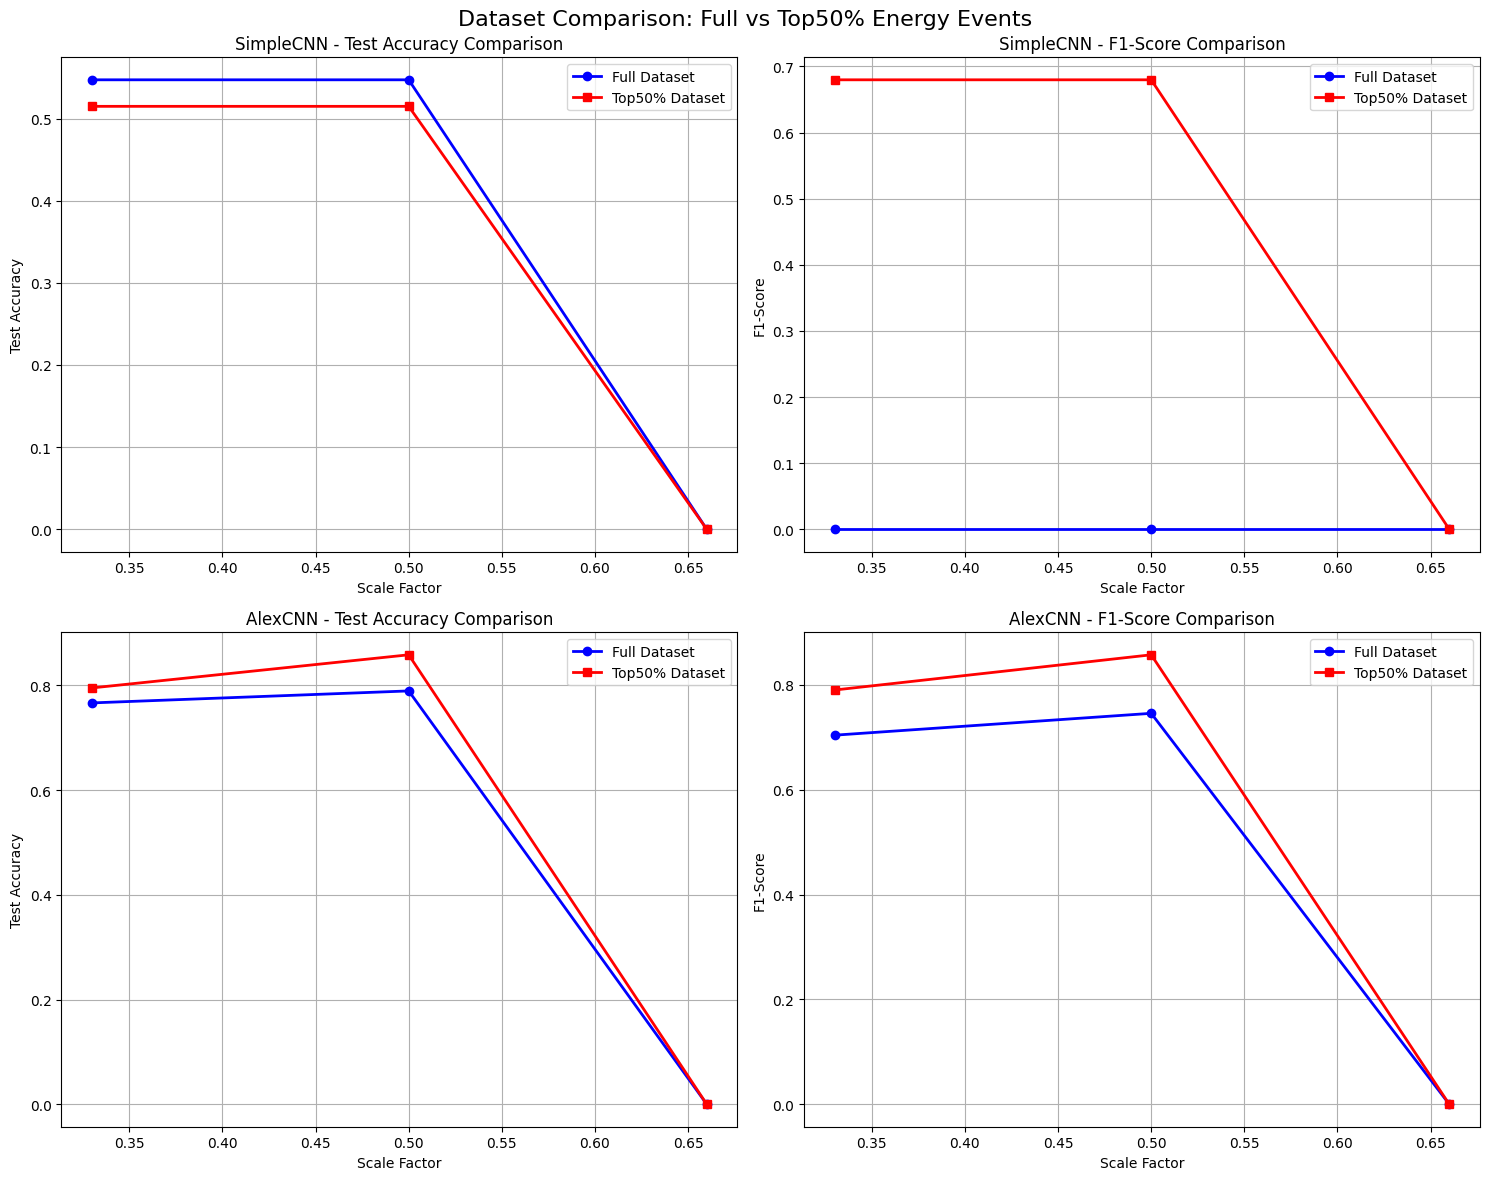

Creating individual training curve plots...


NameError: name 'plot_individual_training_curves' is not defined

In [14]:
import pickle
from datetime import datetime

# After running your experiments
experiment_results, summary = main()

# Generate timestamp for unique filenames
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Save experiment_results as pickle
experiment_results_path = f"experiment_results_{timestamp}.pkl"
with open(experiment_results_path, 'wb') as f:
    pickle.dump(experiment_results, f)

# Save summary as pickle
summary_path = f"experiment_summary_{timestamp}.pkl"
with open(summary_path, 'wb') as f:
    pickle.dump(summary, f)

print(f"Experiment results saved to: {experiment_results_path}")
print(f"Summary saved to: {summary_path}")

# Optional: Save both in a single pickle file
combined_results = {
    'experiment_results': experiment_results,
    'summary': summary,
    'timestamp': timestamp
}

combined_path = f"all_experiments_{timestamp}.pkl"
with open(combined_path, 'wb') as f:
    pickle.dump(combined_results, f)

print(f"Combined results saved to: {combined_path}")

Starting multi-dataset scale factor experiments...
Loading datasets...
Loading All events...
Loading file: processed_parsed_data_nue_WithWire_15.pkl
Loading file: processed_parsed_data_nue_WithWire_01.pkl
Loading file: processed_parsed_data_bnb_WithWire_07.pkl
Loading file: processed_parsed_data_bnb_WithWire_04.pkl
Loading file: processed_parsed_data_nue_WithWire_09.pkl
Loading file: processed_parsed_data_nue_WithWire_10.pkl
Loading file: processed_parsed_data_nue_WithWire_17.pkl
Loading file: processed_parsed_data_nue_WithWire_03.pkl
Loading file: processed_parsed_data_bnb_WithWire_14.pkl
Loading file: processed_parsed_data_nue_WithWire_11.pkl
Loading file: processed_parsed_data_bnb_WithWire_00.pkl
Loading file: processed_parsed_data_nue_WithWire_12.pkl
Loading file: processed_parsed_data_bnb_WithWire_09.pkl
Loading file: processed_parsed_data_nue_WithWire_13.pkl
Loading file: processed_parsed_data_bnb_WithWire_02.pkl
Loading file: processed_parsed_data_bnb_WithWire_06.pkl
Loading fil

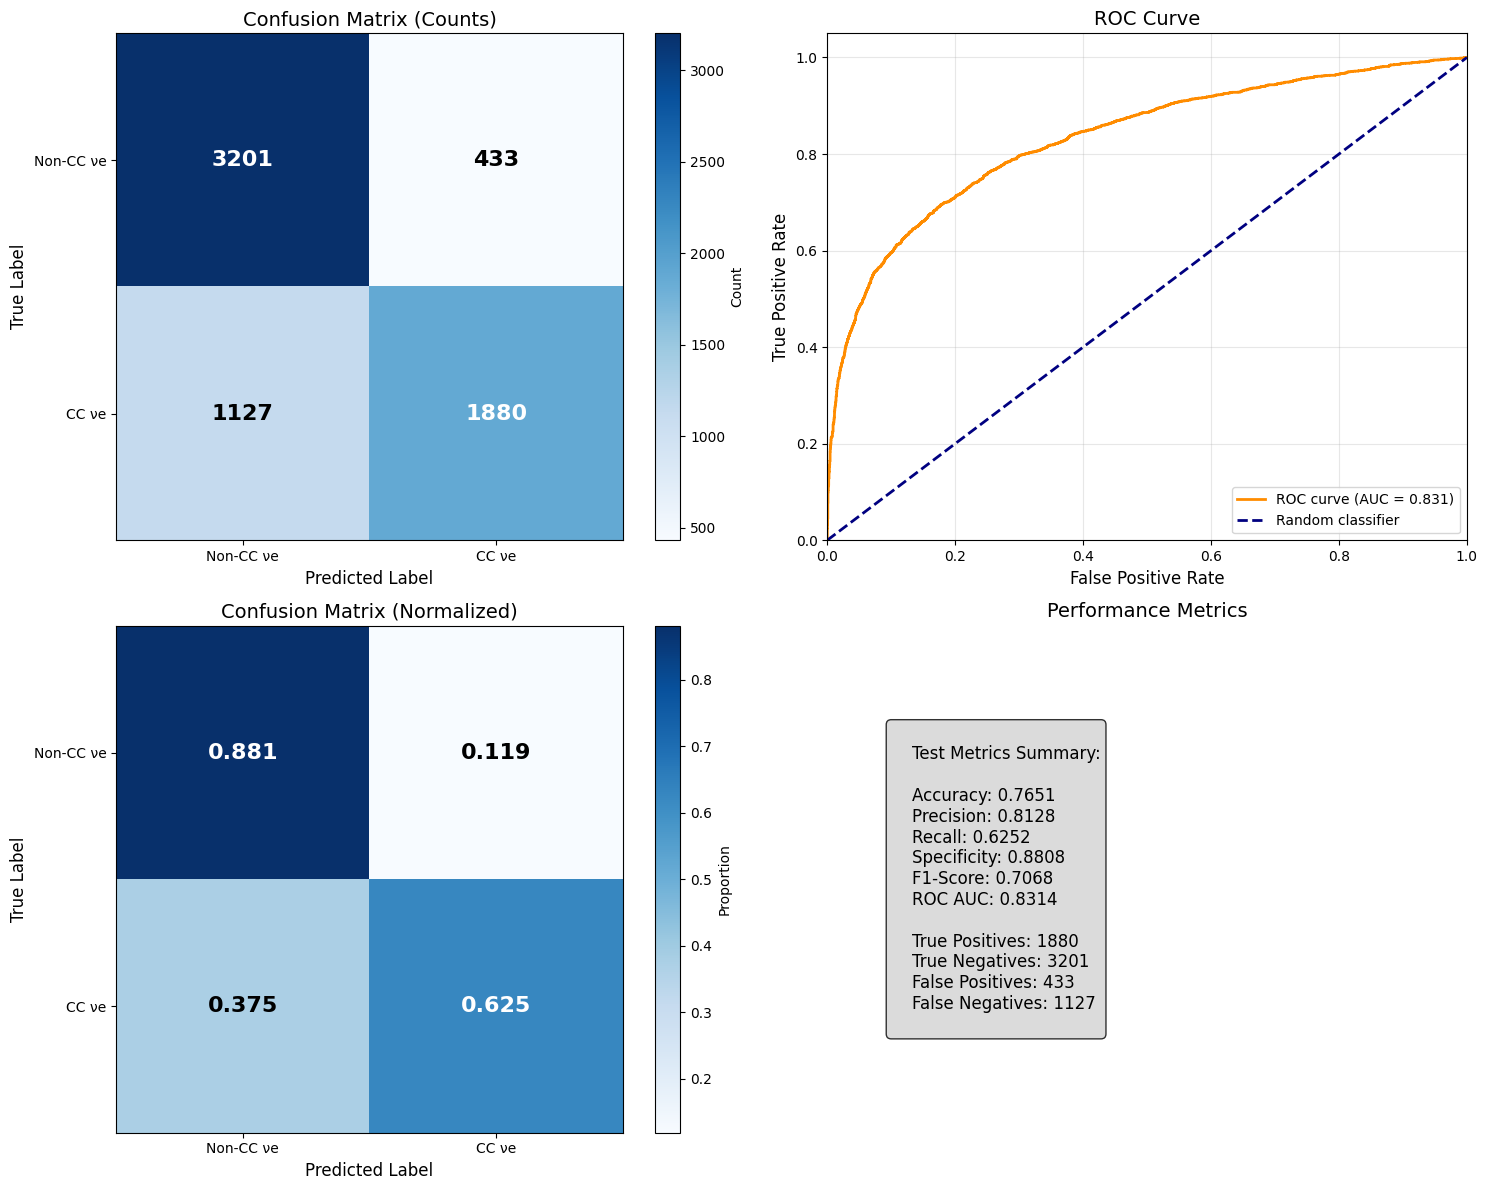


Detailed Metrics:
True Positives: 1880
True Negatives: 3201
False Positives: 433
False Negatives: 1127
Precision: 0.8128
Recall (Sensitivity): 0.6252
Specificity: 0.8808
F1-Score: 0.7068
ROC AUC: 0.8314
Finished Training
Experiment AlexCNN_1ch_full_dataset_scale0.33 completed successfully!
Test accuracy: 0.7651

Starting experiment: AlexCNN_1ch_full_dataset_scale0.5
Dataset: All events
Model: AlexCNN, Scale: 0.5
Using device: cuda
GPU: Tesla V100-PCIE-16GB
Splitting dataset...
Dataset split - Train: 30990, Val: 6641, Test: 6641
Train class distribution: {0: 16957, 1: 14033}
Val class distribution: {0: 3634, 1: 3007}
Test class distribution: {0: 3634, 1: 3007}
[1, 20] loss: 1.183
[1, 40] loss: 0.936
[1, 60] loss: 0.753
[1, 80] loss: 0.752
[1, 100] loss: 0.739
[1, 120] loss: 0.714
[1, 140] loss: 0.714
[1, 160] loss: 0.703
[1, 180] loss: 0.716
[1, 200] loss: 0.700
[1, 220] loss: 0.701
[1, 240] loss: 0.702
[1, 260] loss: 0.716
[1, 280] loss: 0.696
[1, 300] loss: 0.696
[1, 320] loss: 0.698

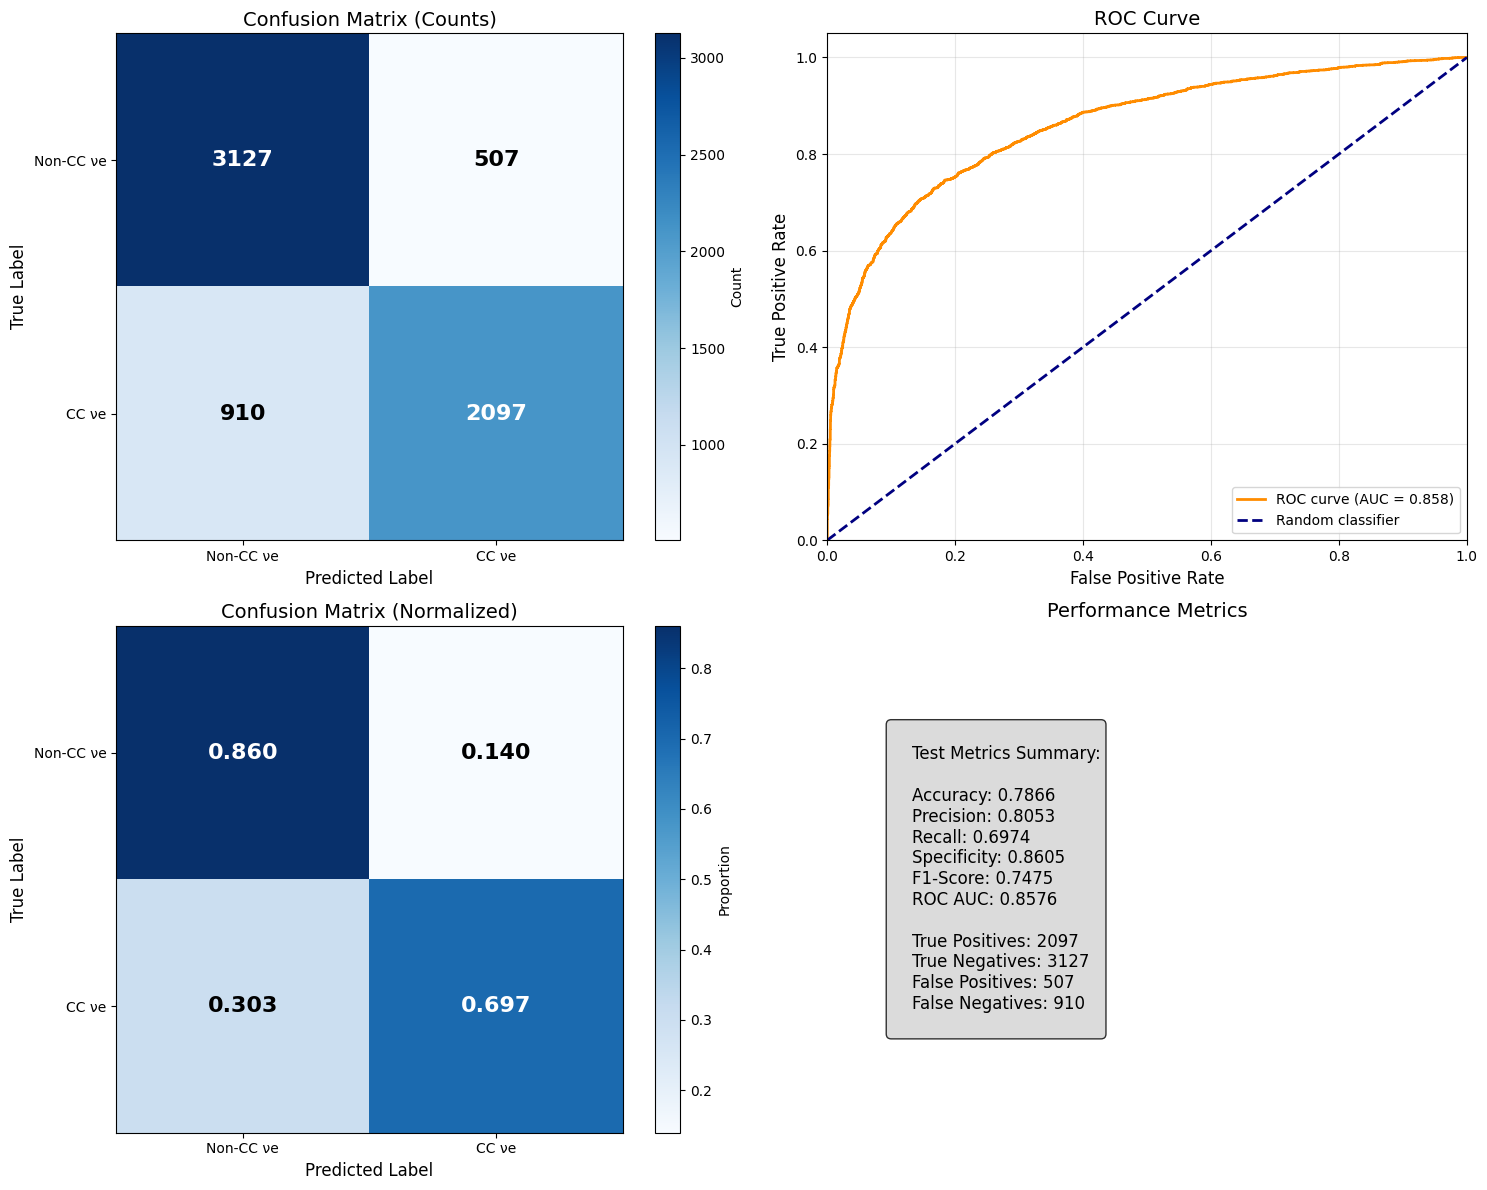


Detailed Metrics:
True Positives: 2097
True Negatives: 3127
False Positives: 507
False Negatives: 910
Precision: 0.8053
Recall (Sensitivity): 0.6974
Specificity: 0.8605
F1-Score: 0.7475
ROC AUC: 0.8576
Finished Training
Experiment AlexCNN_1ch_full_dataset_scale0.5 completed successfully!
Test accuracy: 0.7866

Starting experiment: AlexCNN_1ch_top50_dataset_scale0.33
Dataset: Top 50% energy events
Model: AlexCNN, Scale: 0.33
Using device: cuda
GPU: Tesla V100-PCIE-16GB
Splitting dataset...
Dataset split - Train: 15494, Val: 3321, Test: 3321
Train class distribution: {1: 7977, 0: 7517}
Val class distribution: {1: 1710, 0: 1611}
Test class distribution: {1: 1710, 0: 1611}
[1, 20] loss: 0.749
[1, 40] loss: 0.828
[1, 60] loss: 0.952
[1, 80] loss: 0.851
[1, 100] loss: 0.793
[1, 120] loss: 0.788
[1, 140] loss: 0.729
[1, 160] loss: 0.682
[1, 180] loss: 0.682
[1, 200] loss: 0.667
[1, 220] loss: 0.700
[1, 240] loss: 0.678
[1, 260] loss: 0.674
[1, 280] loss: 0.674
[1, 300] loss: 0.692
[1, 320] l

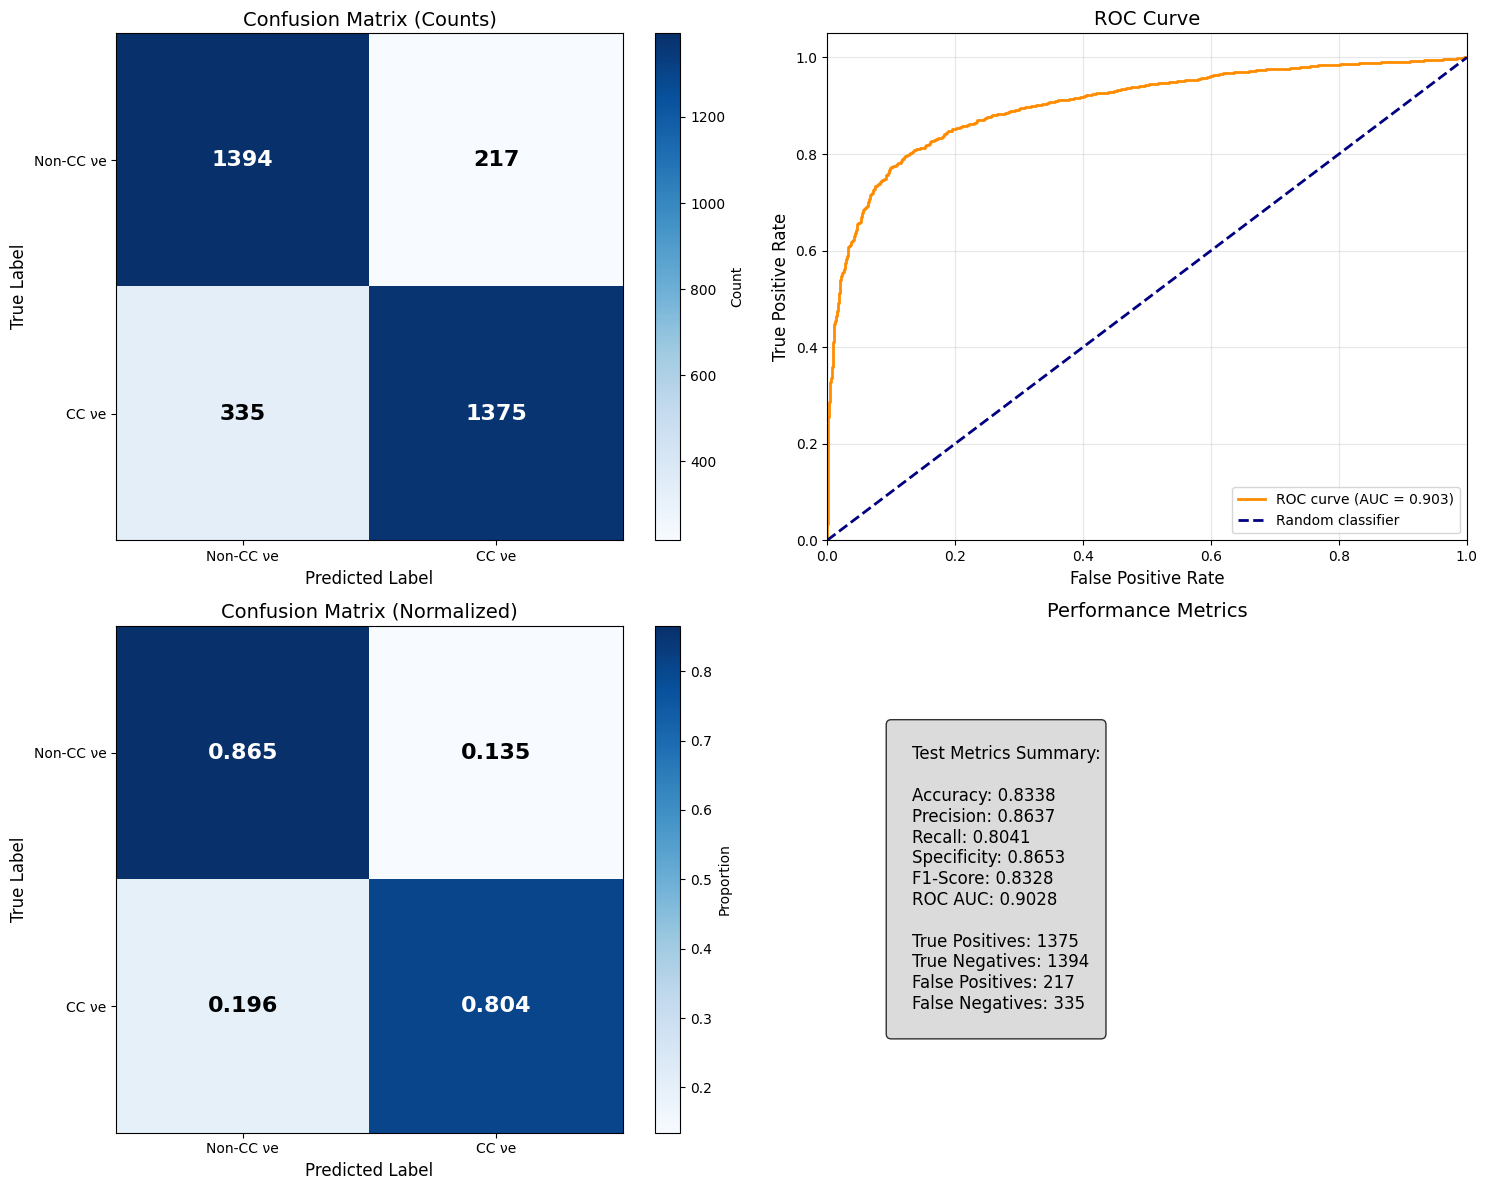


Detailed Metrics:
True Positives: 1375
True Negatives: 1394
False Positives: 217
False Negatives: 335
Precision: 0.8637
Recall (Sensitivity): 0.8041
Specificity: 0.8653
F1-Score: 0.8328
ROC AUC: 0.9028
Finished Training
Experiment AlexCNN_1ch_top50_dataset_scale0.33 completed successfully!
Test accuracy: 0.8338

Starting experiment: AlexCNN_1ch_top50_dataset_scale0.5
Dataset: Top 50% energy events
Model: AlexCNN, Scale: 0.5
Using device: cuda
GPU: Tesla V100-PCIE-16GB
Splitting dataset...
Dataset split - Train: 15494, Val: 3321, Test: 3321
Train class distribution: {1: 7977, 0: 7517}
Val class distribution: {1: 1710, 0: 1611}
Test class distribution: {1: 1710, 0: 1611}
[1, 20] loss: 0.873
[1, 40] loss: 1.498
[1, 60] loss: 0.858
[1, 80] loss: 0.709
[1, 100] loss: 0.683
[1, 120] loss: 0.727
[1, 140] loss: 0.705
[1, 160] loss: 0.711
[1, 180] loss: 0.737
[1, 200] loss: 0.728
[1, 220] loss: 0.684
[1, 240] loss: 0.696
[1, 260] loss: 0.702
[1, 280] loss: 0.676
[1, 300] loss: 0.657
[1, 320] l

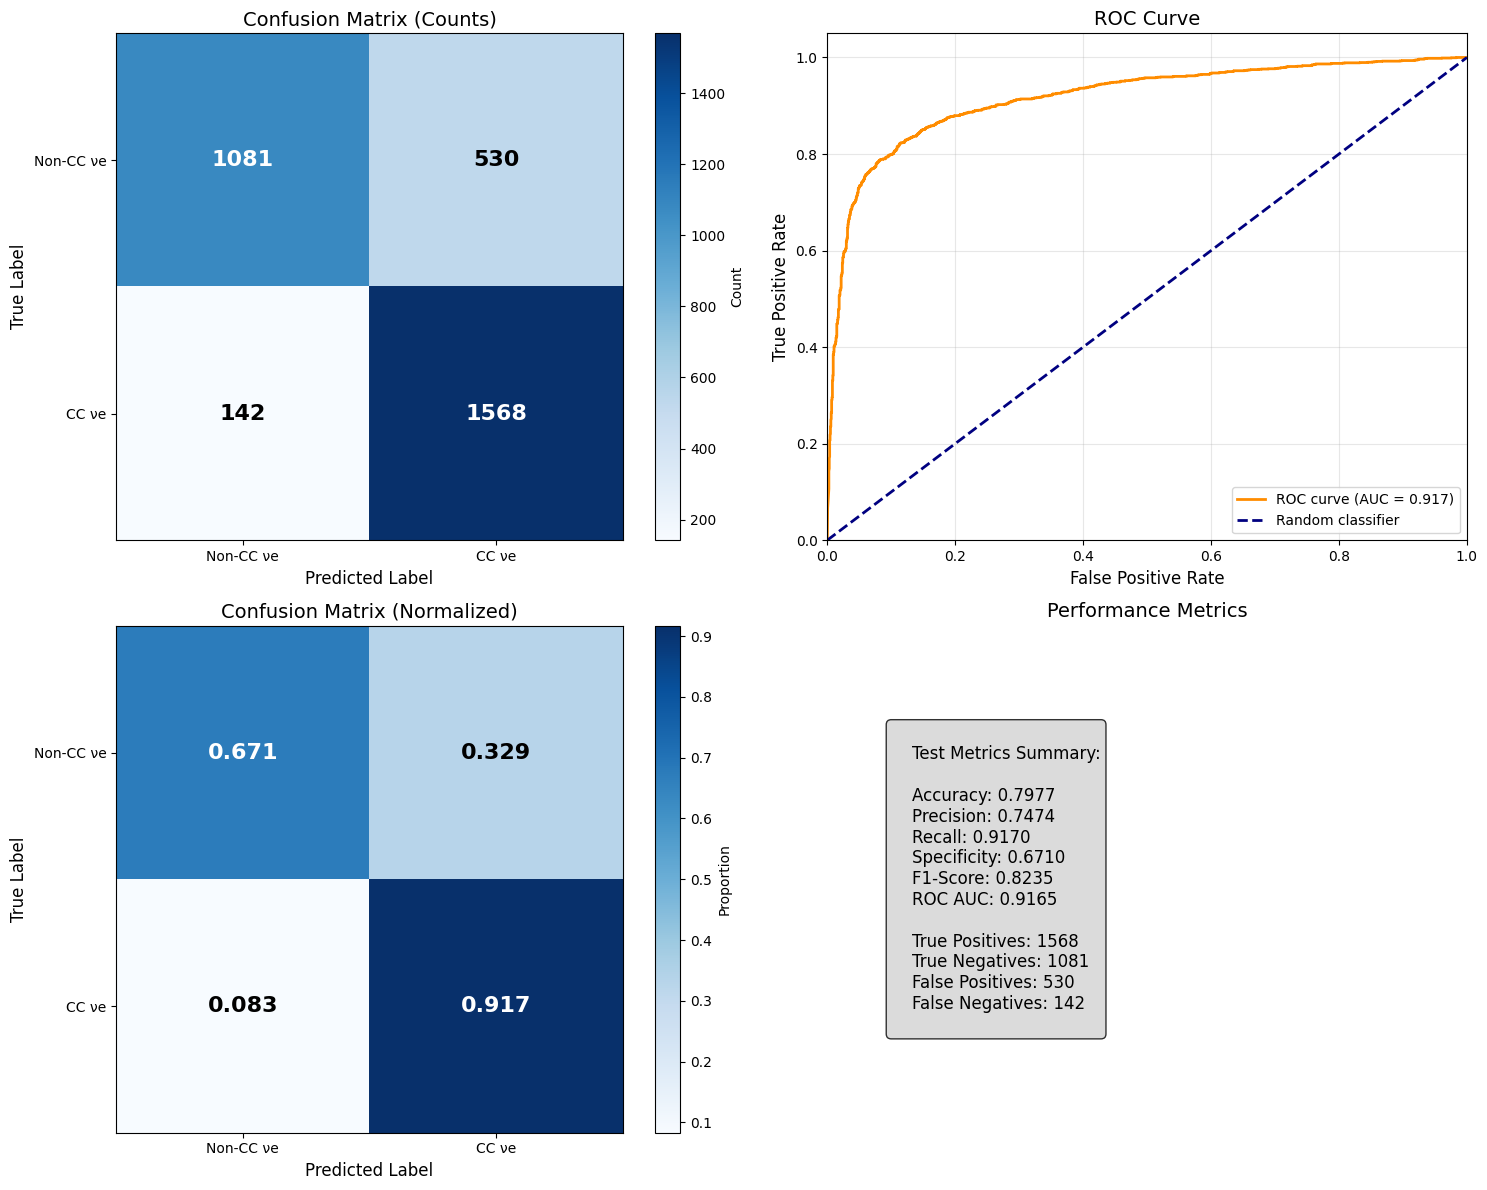


Detailed Metrics:
True Positives: 1568
True Negatives: 1081
False Positives: 530
False Negatives: 142
Precision: 0.7474
Recall (Sensitivity): 0.9170
Specificity: 0.6710
F1-Score: 0.8235
ROC AUC: 0.9165
Finished Training
Experiment AlexCNN_1ch_top50_dataset_scale0.5 completed successfully!
Test accuracy: 0.7977

FULL DATASET INFO:
Size: 44272 samples
Class distribution: {0: 24225, 1: 20047}

TOP50 DATASET INFO:
Size: 22136 samples
Class distribution: {1: 11397, 0: 10739}

Creating multi-dataset comparison plots...


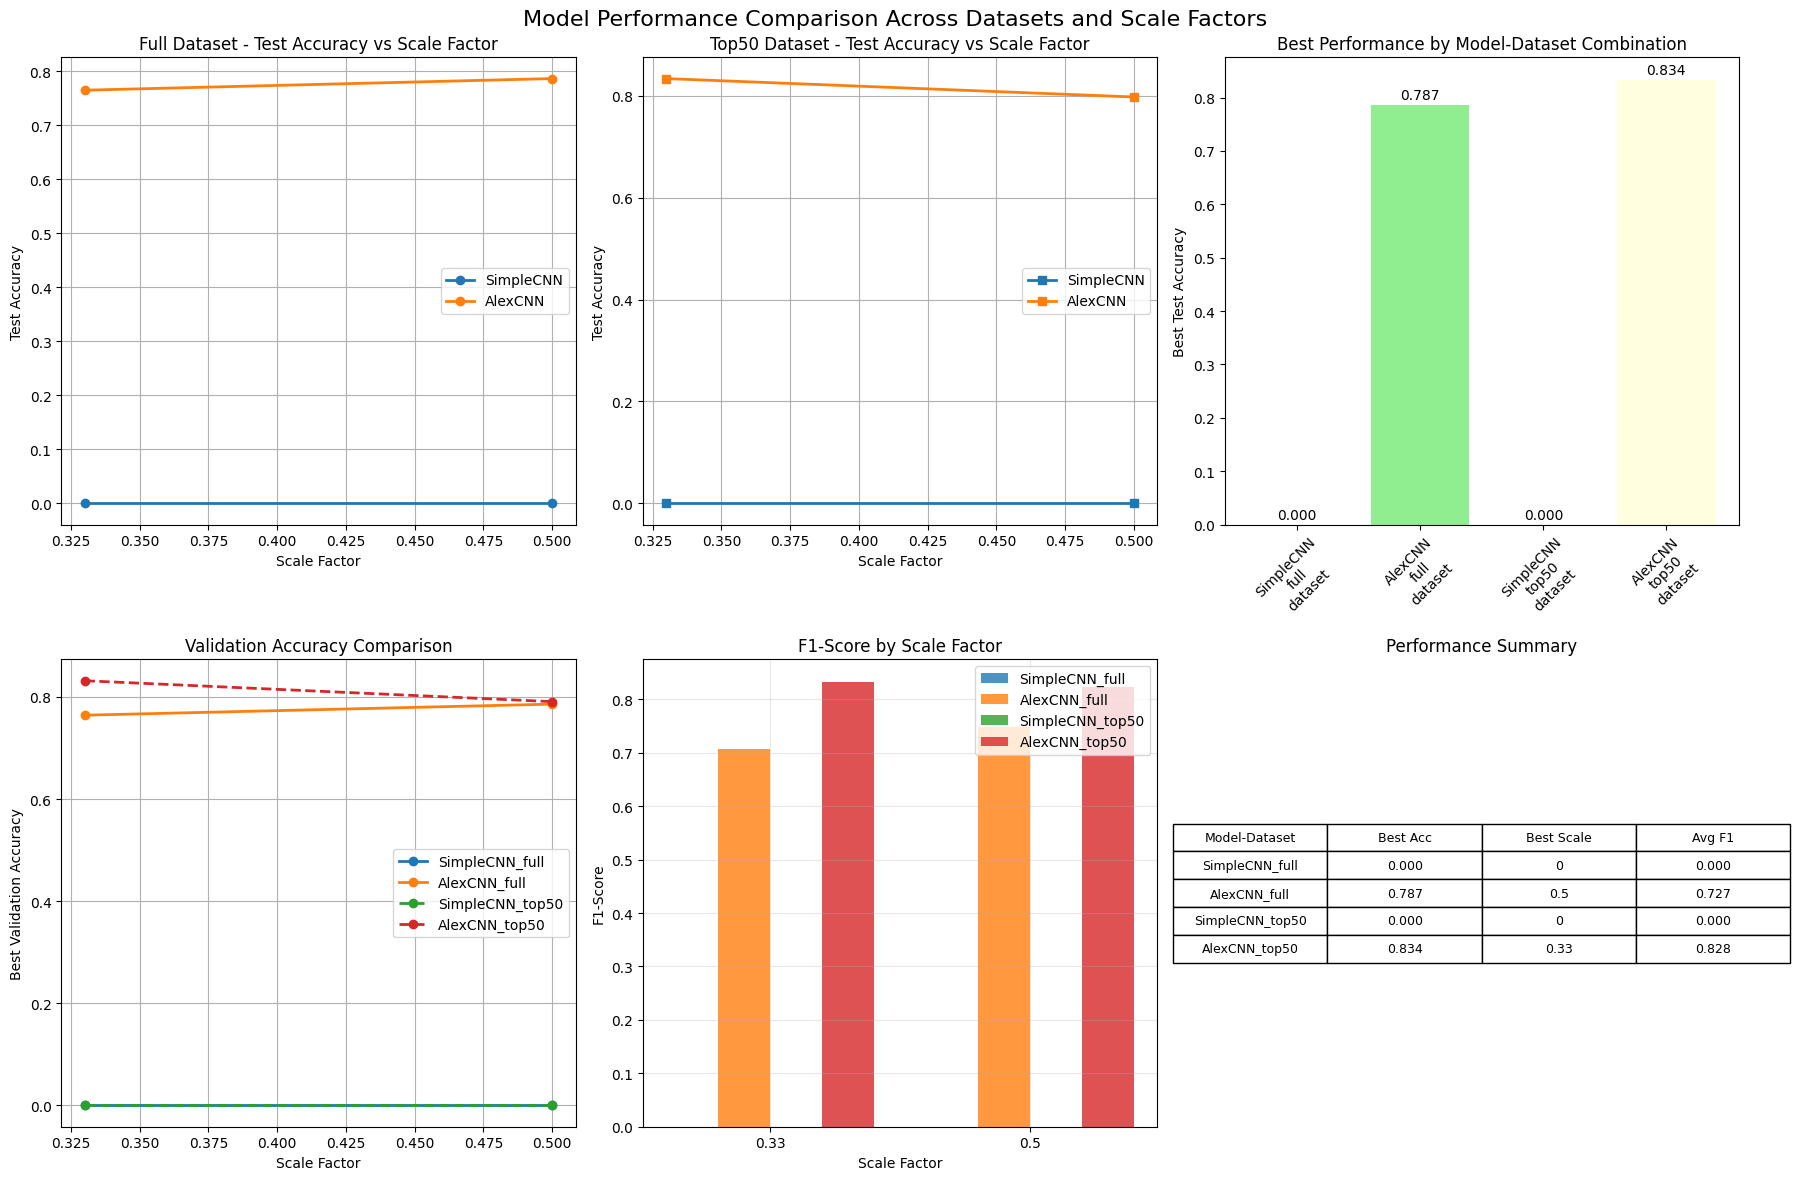

Creating dataset comparison plots...


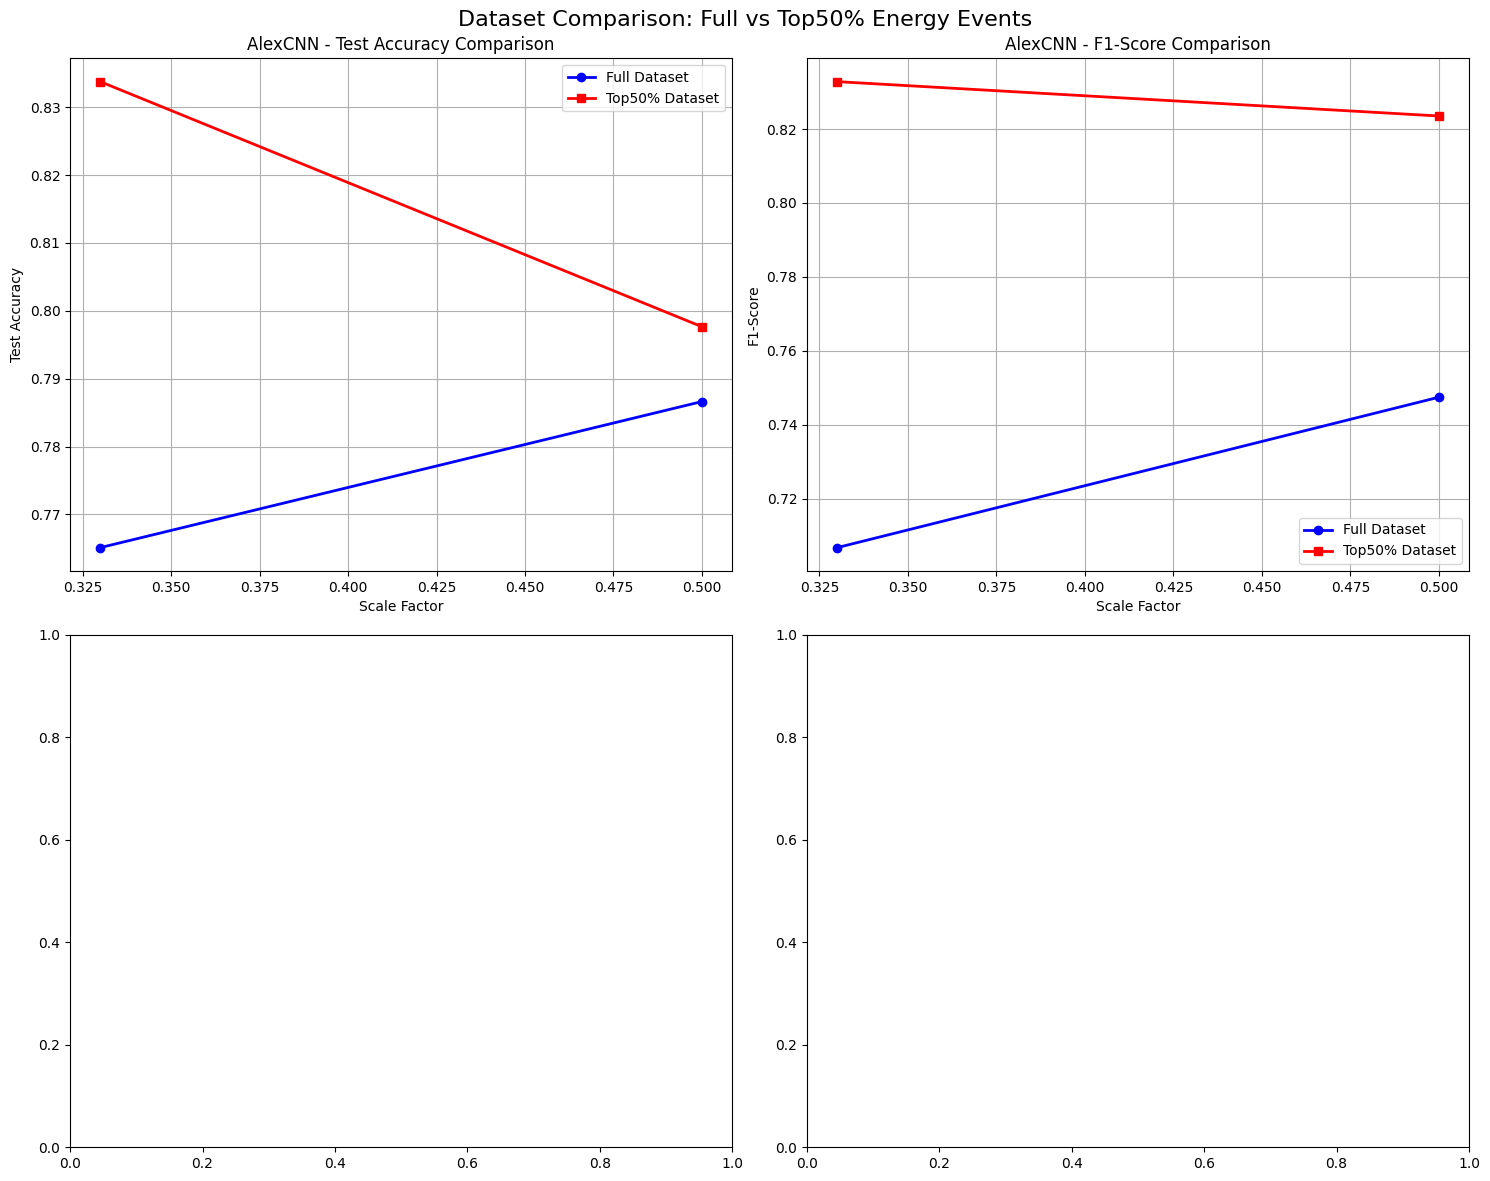

Creating ROC curve comparison plots...


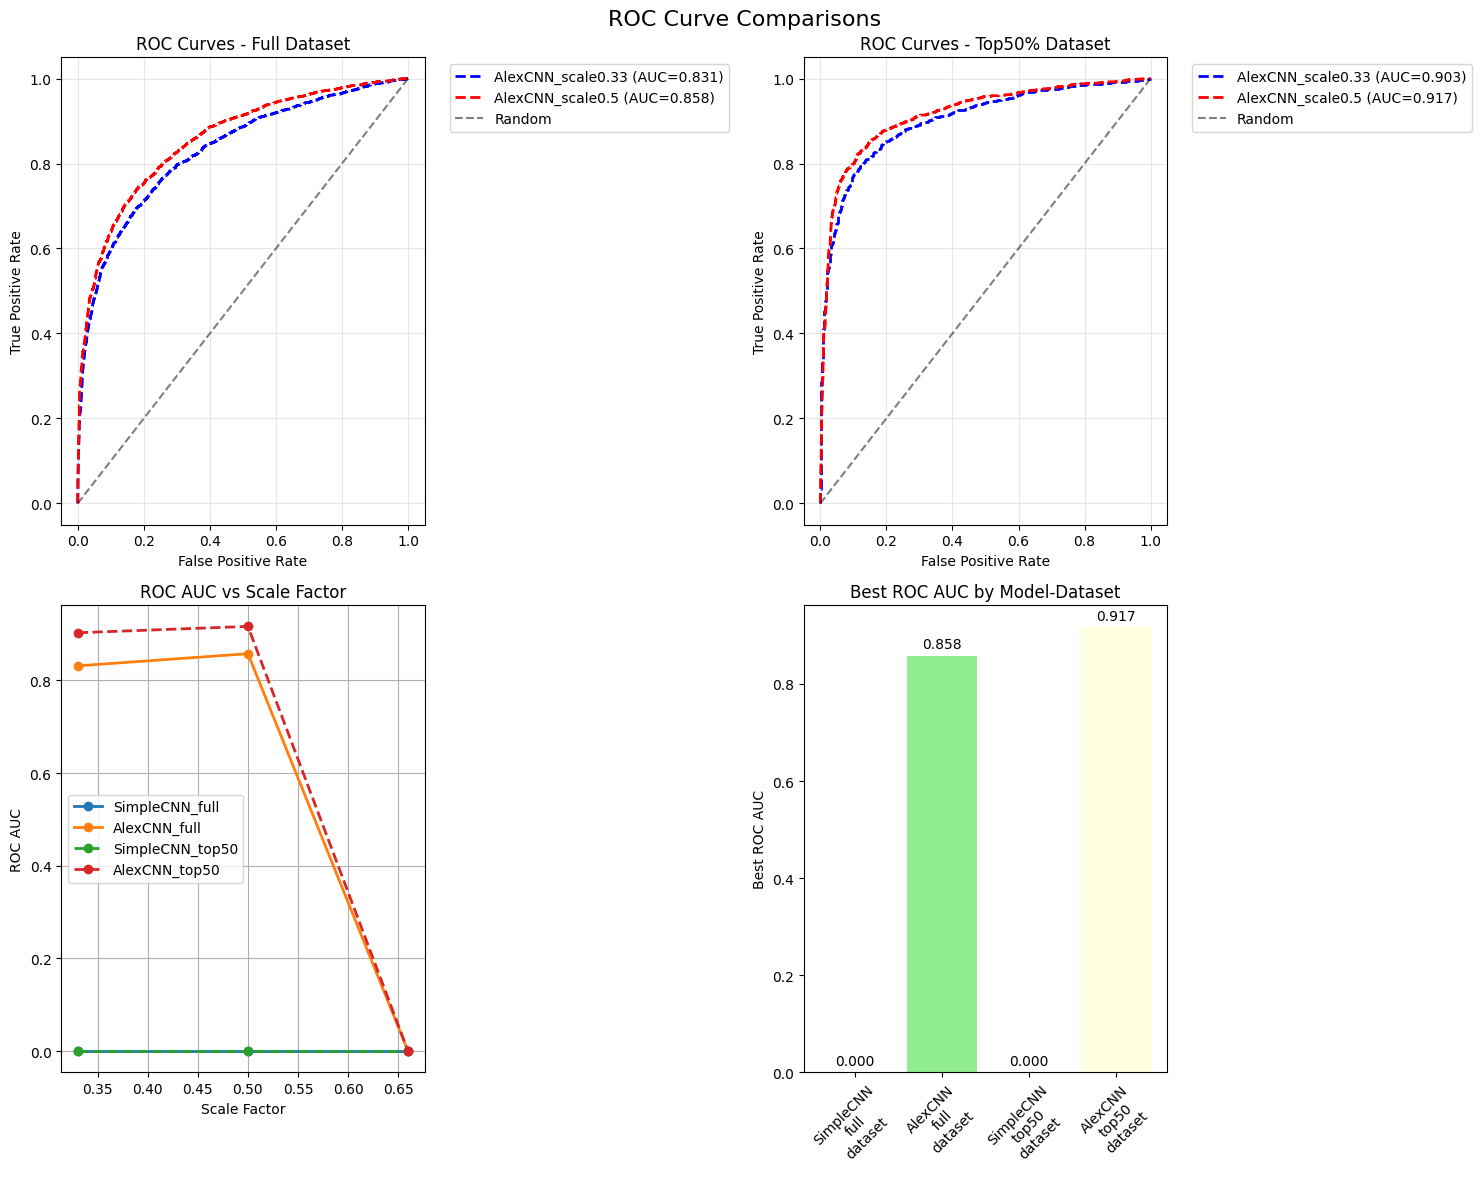

Creating individual training curve plots...


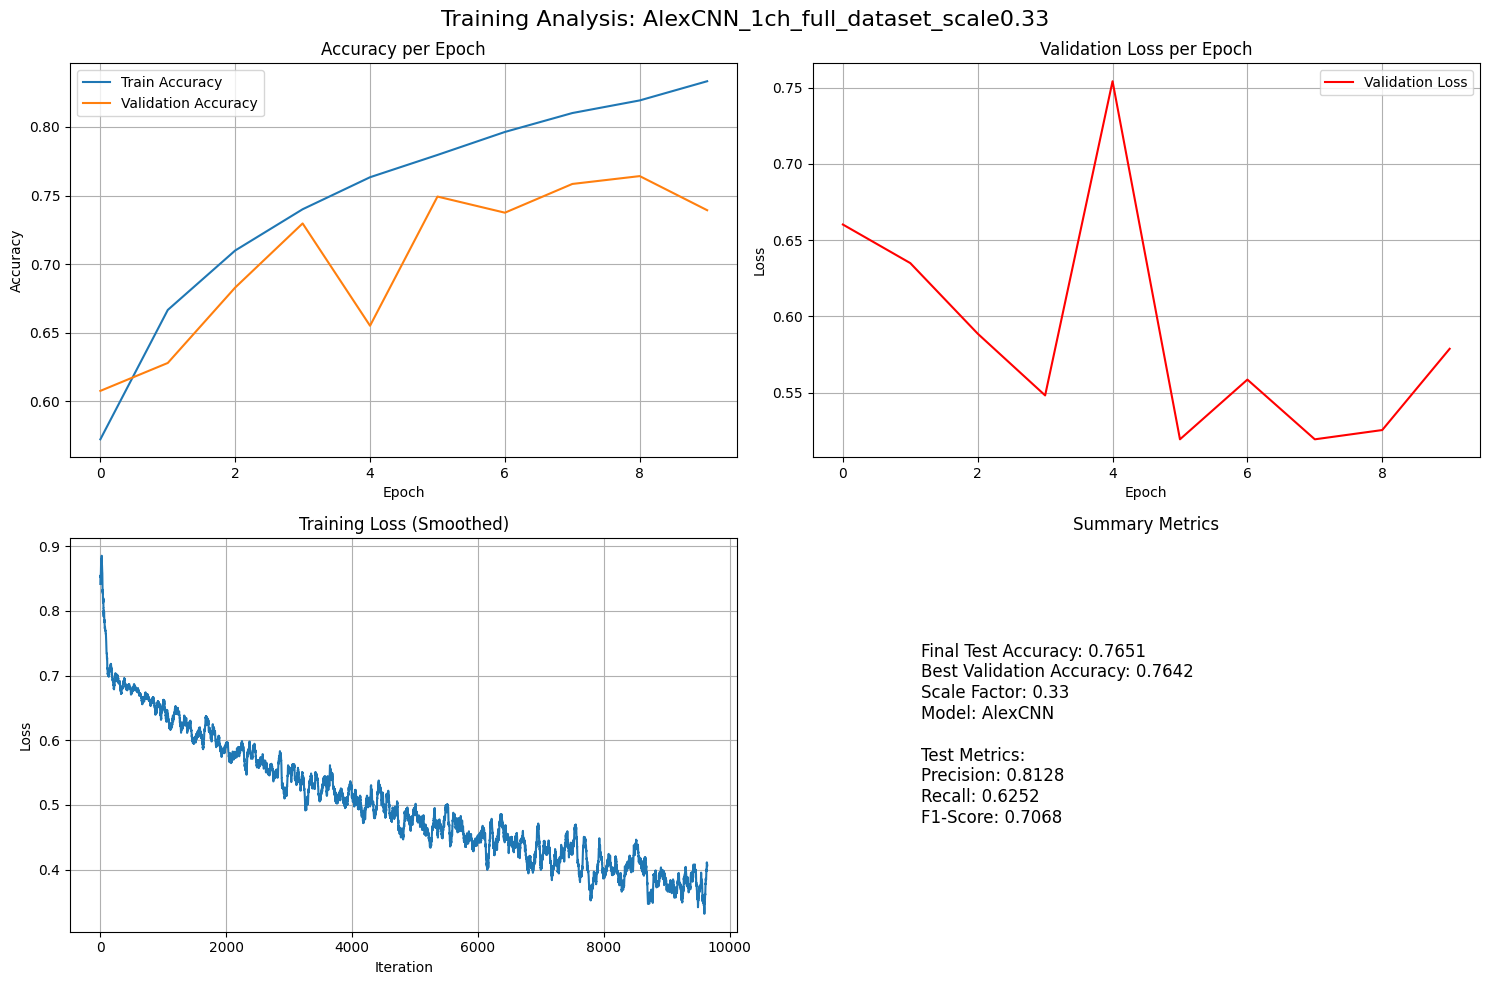

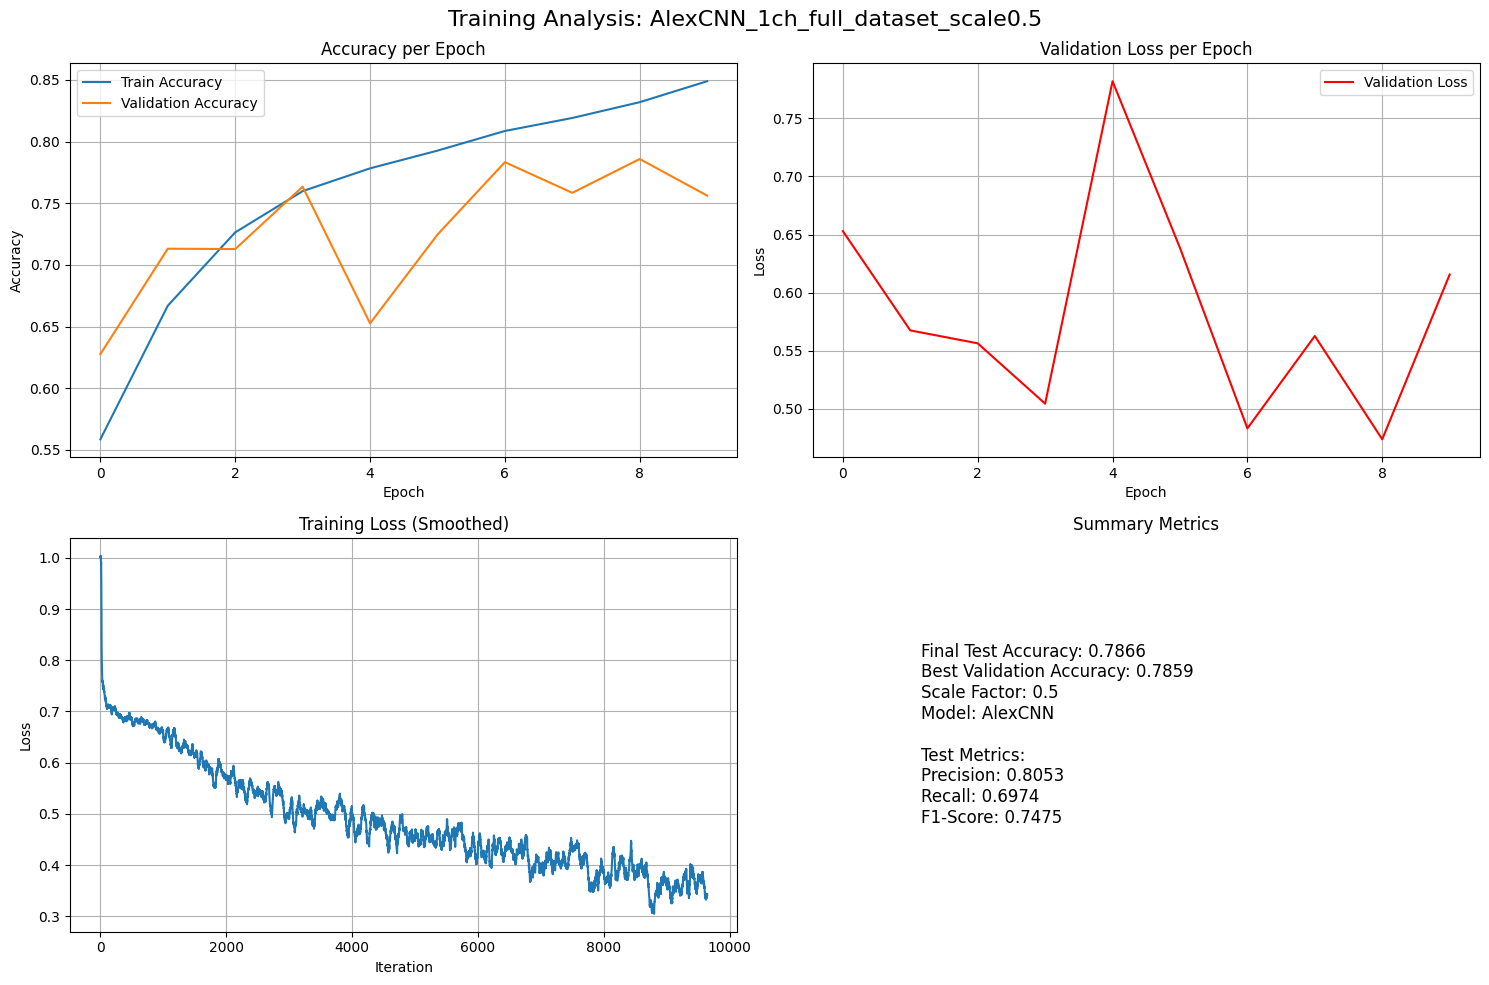

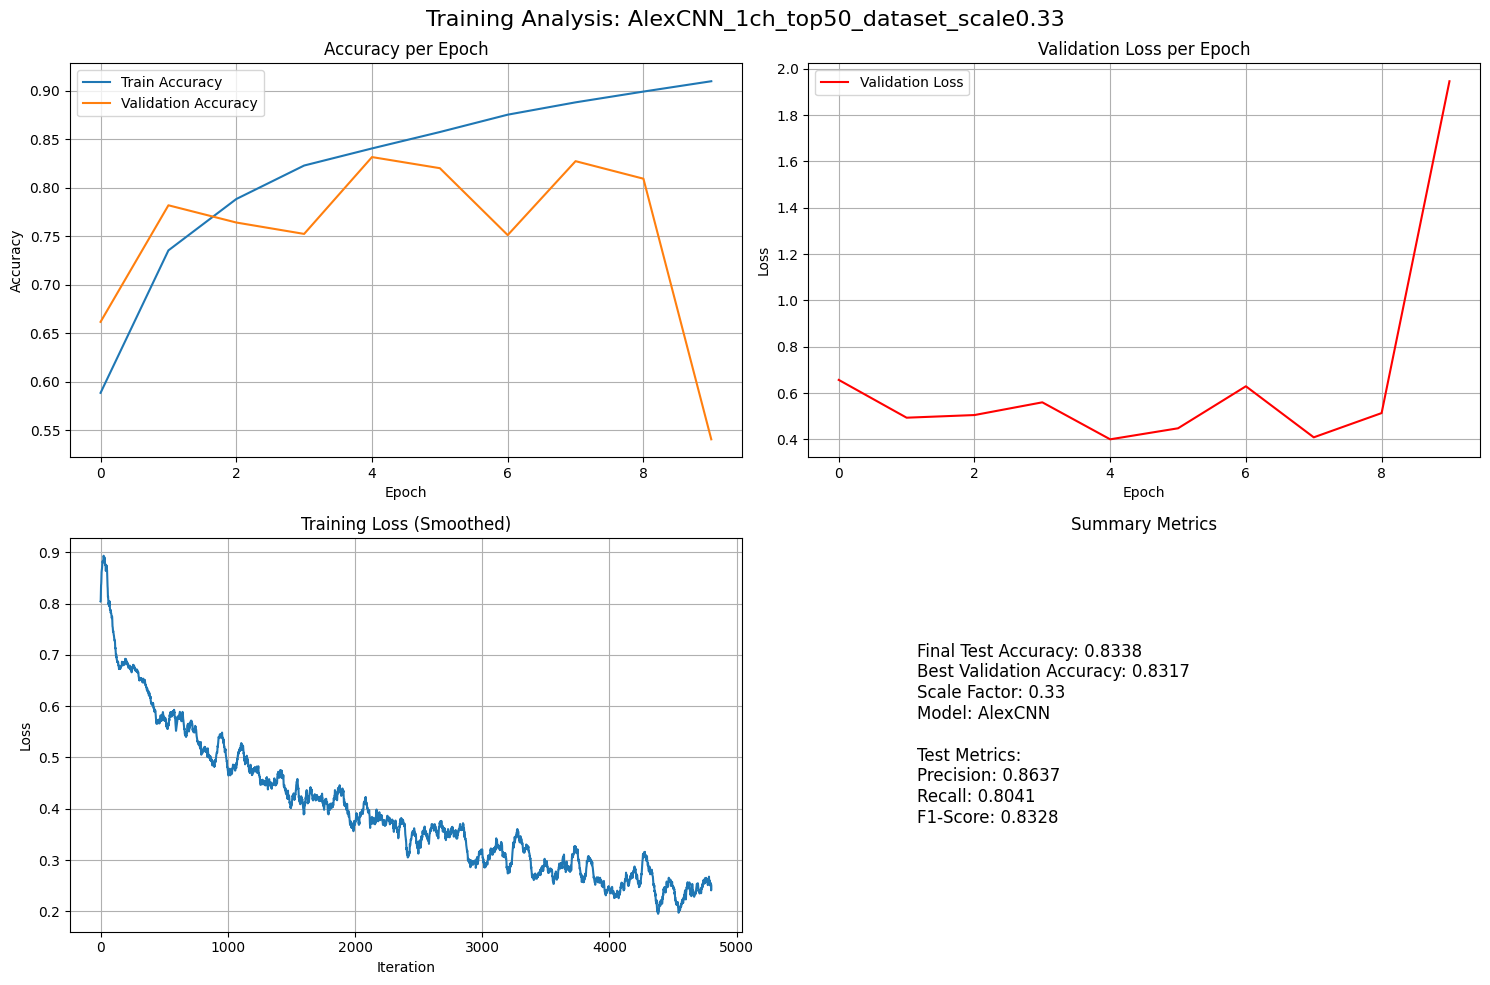

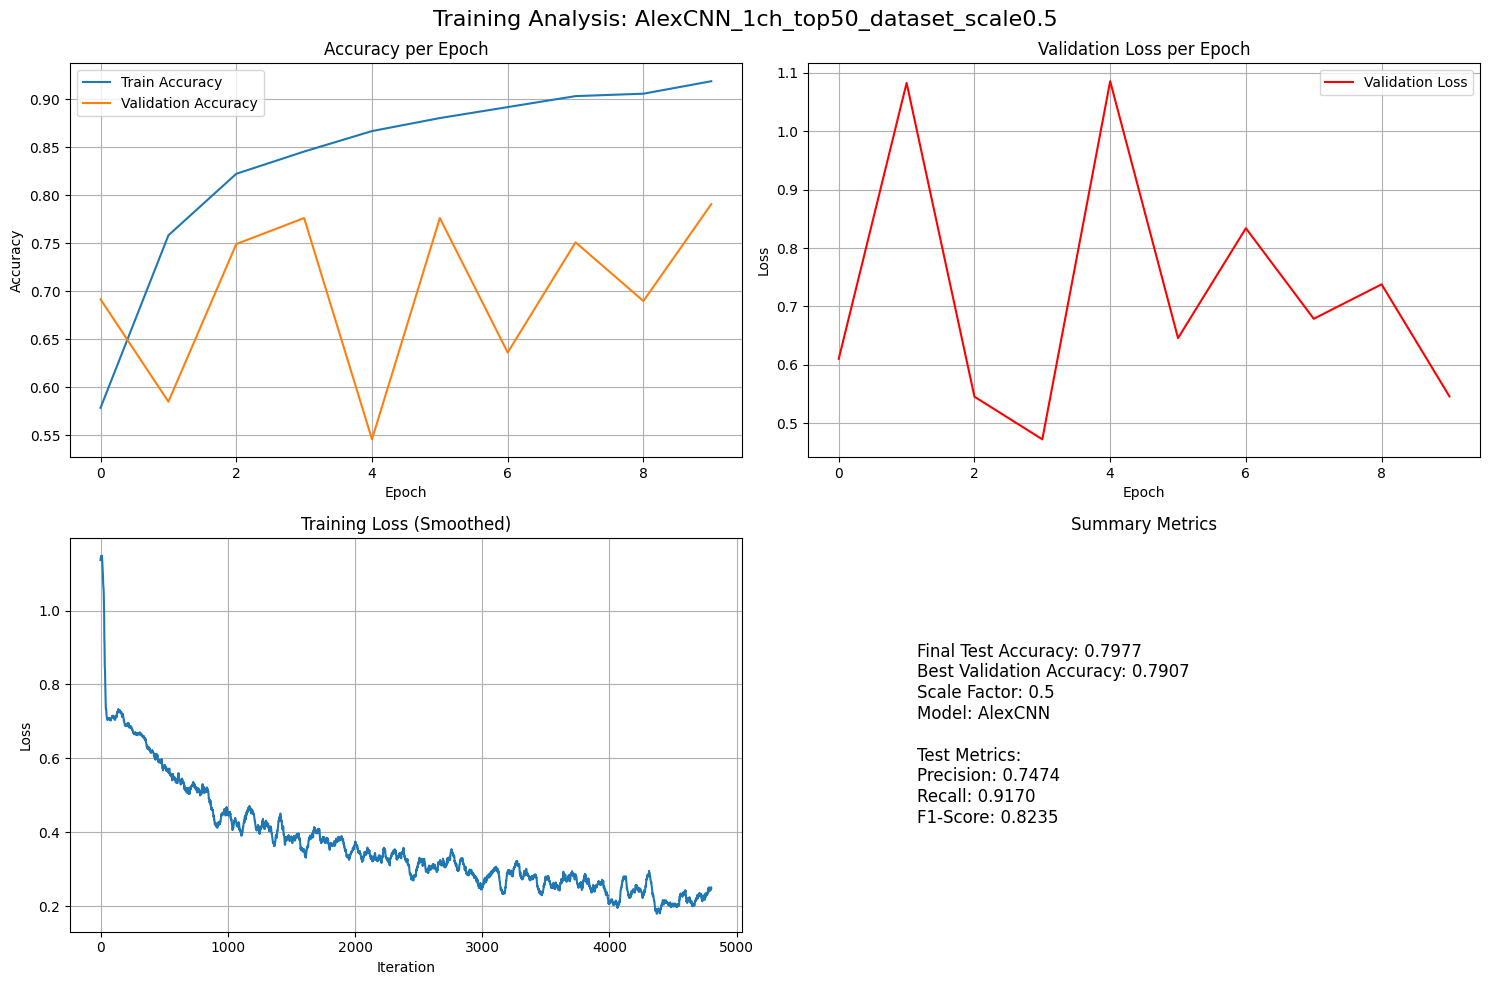


EXPERIMENT RESULTS SUMMARY
Best overall: AlexCNN_1ch_top50_dataset_scale0.33 - Test Accuracy: 0.8338
Best full dataset: AlexCNN_1ch_full_dataset_scale0.5 - Test Accuracy: 0.7866
Best top50 dataset: AlexCNN_1ch_top50_dataset_scale0.33 - Test Accuracy: 0.8338

All experiments completed!
Results saved in:
- multi_dataset_experiments/ (individual experiment data)
- analysis_plots/ (comparison plots)
- multi_dataset_experiment_summary.json (summary metrics)
Experiment results saved to: experiment_results_20250705_162053.pkl
Summary saved to: experiment_summary_20250705_162053.pkl
Combined results saved to: all_experiments_20250705_162053.pkl


In [15]:
import pickle
from datetime import datetime

# After running your experiments
experiment_results, summary = main()

# Generate timestamp for unique filenames
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Save experiment_results as pickle
experiment_results_path = f"experiment_results_{timestamp}.pkl"
with open(experiment_results_path, 'wb') as f:
    pickle.dump(experiment_results, f)

# Save summary as pickle
summary_path = f"experiment_summary_{timestamp}.pkl"
with open(summary_path, 'wb') as f:
    pickle.dump(summary, f)

print(f"Experiment results saved to: {experiment_results_path}")
print(f"Summary saved to: {summary_path}")

# Optional: Save both in a single pickle file
combined_results = {
    'experiment_results': experiment_results,
    'summary': summary,
    'timestamp': timestamp
}

combined_path = f"all_experiments_{timestamp}.pkl"
with open(combined_path, 'wb') as f:
    pickle.dump(combined_results, f)

print(f"Combined results saved to: {combined_path}")

Starting multi-dataset scale factor experiments...
Loading datasets...
Loading All events...
Loading file: processed_parsed_data_nue_WithWire_15.pkl
Loading file: processed_parsed_data_nue_WithWire_01.pkl
Loading file: processed_parsed_data_bnb_WithWire_07.pkl
Loading file: processed_parsed_data_bnb_WithWire_04.pkl
Loading file: processed_parsed_data_nue_WithWire_09.pkl
Loading file: processed_parsed_data_nue_WithWire_10.pkl
Loading file: processed_parsed_data_nue_WithWire_17.pkl
Loading file: processed_parsed_data_nue_WithWire_03.pkl
Loading file: processed_parsed_data_bnb_WithWire_14.pkl
Loading file: processed_parsed_data_nue_WithWire_11.pkl
Loading file: processed_parsed_data_bnb_WithWire_00.pkl
Loading file: processed_parsed_data_nue_WithWire_12.pkl
Loading file: processed_parsed_data_bnb_WithWire_09.pkl
Loading file: processed_parsed_data_nue_WithWire_13.pkl
Loading file: processed_parsed_data_bnb_WithWire_02.pkl
Loading file: processed_parsed_data_bnb_WithWire_06.pkl
Loading fil

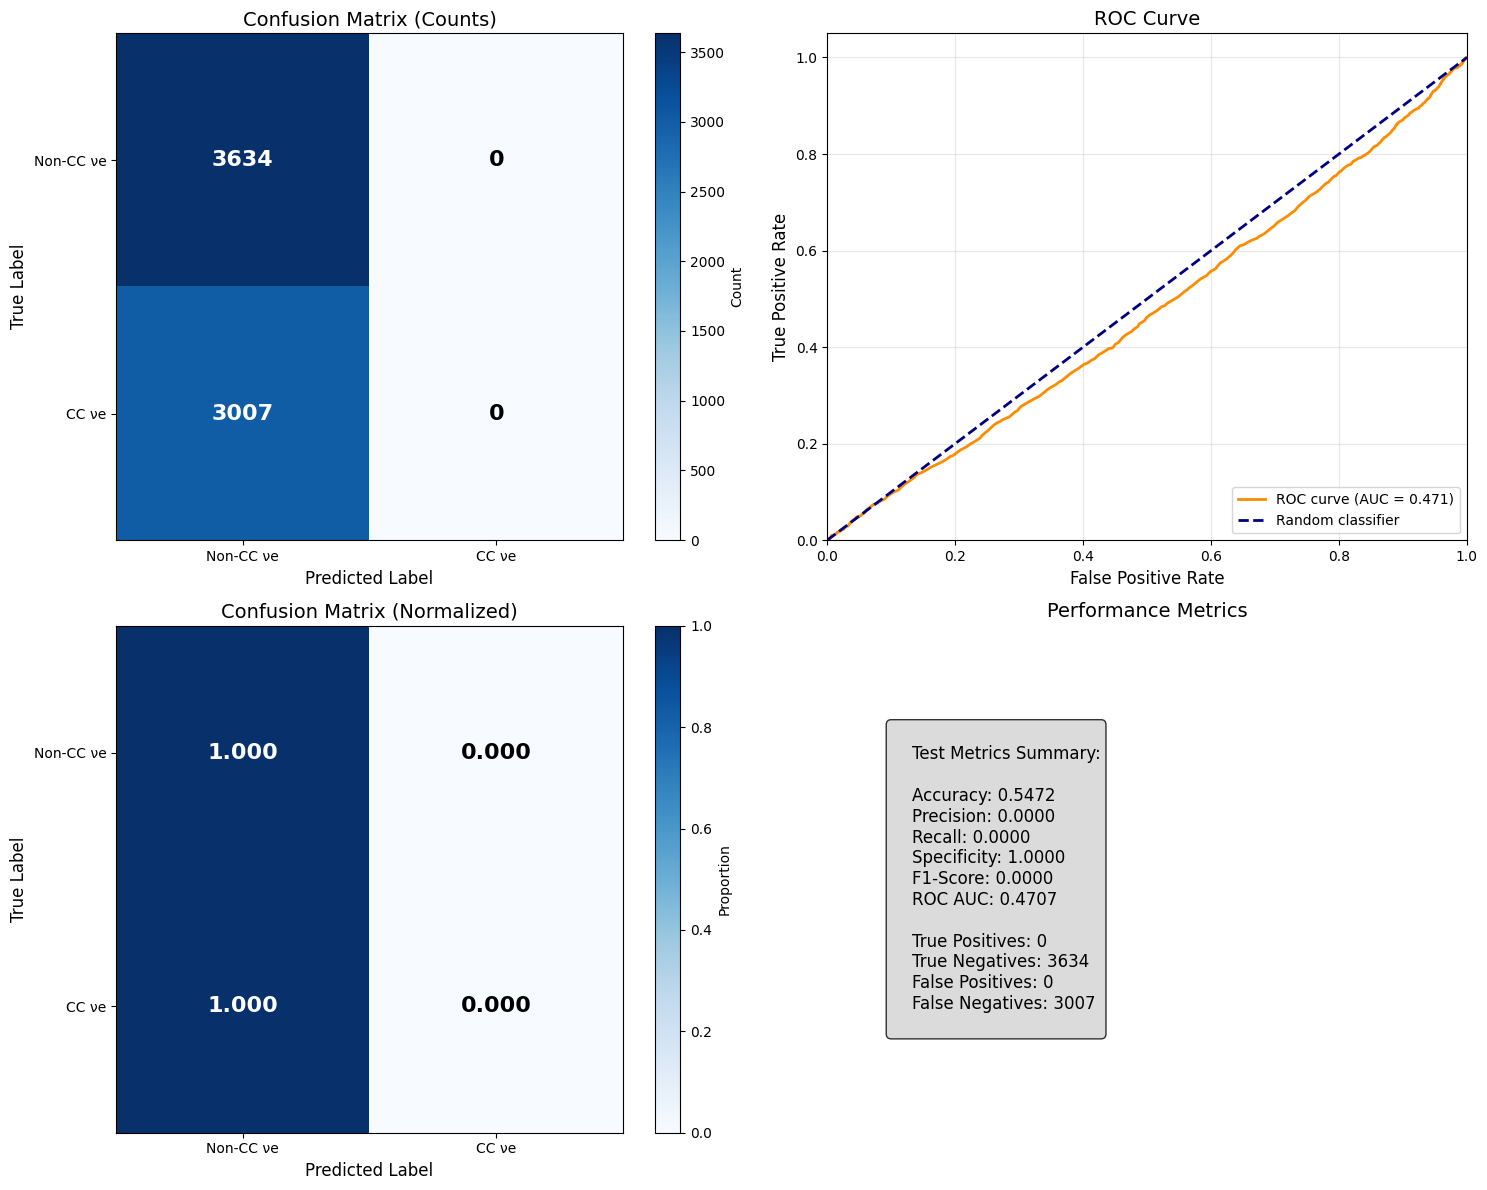


Detailed Metrics:
True Positives: 0
True Negatives: 3634
False Positives: 0
False Negatives: 3007
Precision: 0.0000
Recall (Sensitivity): 0.0000
Specificity: 1.0000
F1-Score: 0.0000
ROC AUC: 0.4707
Finished Training
Experiment LeNET_1ch_full_dataset_scale0.33 completed successfully!
Test accuracy: 0.5472

Starting experiment: LeNET_1ch_full_dataset_scale0.5
Dataset: All events
Model: LeNET, Scale: 0.5
Using device: cuda
GPU: Tesla V100-PCIE-16GB
Splitting dataset...
Dataset split - Train: 30990, Val: 6641, Test: 6641
Train class distribution: {0: 16957, 1: 14033}
Val class distribution: {0: 3634, 1: 3007}
Test class distribution: {0: 3634, 1: 3007}
Flattened size after convolutions: 6426000
[1, 20] loss: 0.692
[1, 40] loss: 0.694
[1, 60] loss: 0.689
[1, 80] loss: 0.689
[1, 100] loss: 0.687
[1, 120] loss: 0.682
[1, 140] loss: 0.688
[1, 160] loss: 0.689
[1, 180] loss: 0.692
[1, 200] loss: 0.682
[1, 220] loss: 0.691
[1, 240] loss: 0.692
[1, 260] loss: 0.689
[1, 280] loss: 0.685
[1, 300] 

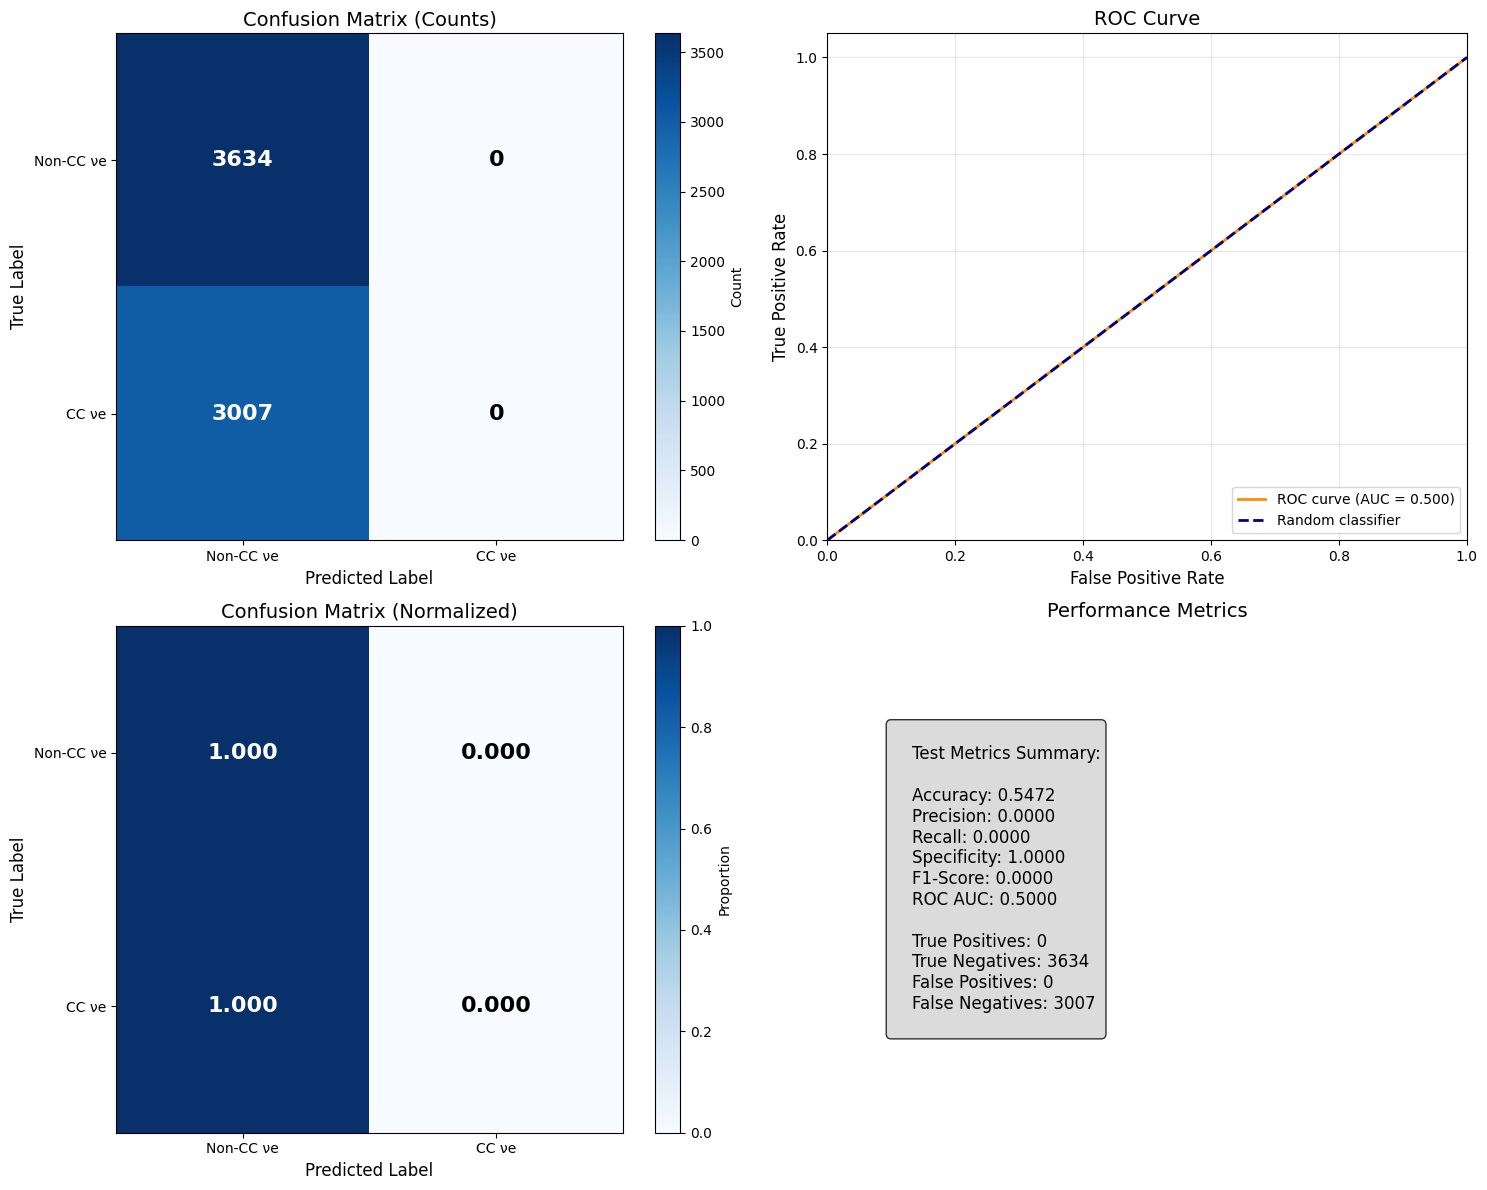


Detailed Metrics:
True Positives: 0
True Negatives: 3634
False Positives: 0
False Negatives: 3007
Precision: 0.0000
Recall (Sensitivity): 0.0000
Specificity: 1.0000
F1-Score: 0.0000
ROC AUC: 0.5000
Finished Training
Experiment LeNET_1ch_full_dataset_scale0.5 completed successfully!
Test accuracy: 0.5472

Starting experiment: LeNET_1ch_top50_dataset_scale0.33
Dataset: Top 50% energy events
Model: LeNET, Scale: 0.33
Using device: cuda
GPU: Tesla V100-PCIE-16GB
Splitting dataset...
Dataset split - Train: 15494, Val: 3321, Test: 3321
Train class distribution: {1: 7977, 0: 7517}
Val class distribution: {1: 1710, 0: 1611}
Test class distribution: {1: 1710, 0: 1611}
Flattened size after convolutions: 2702160
[1, 20] loss: 0.693
[1, 40] loss: 0.692
[1, 60] loss: 0.691
[1, 80] loss: 0.692
[1, 100] loss: 0.693
[1, 120] loss: 0.695
[1, 140] loss: 0.693
[1, 160] loss: 0.695
[1, 180] loss: 0.693
[1, 200] loss: 0.692
[1, 220] loss: 0.694
[1, 240] loss: 0.693
[1, 260] loss: 0.694
[1, 280] loss: 0.69

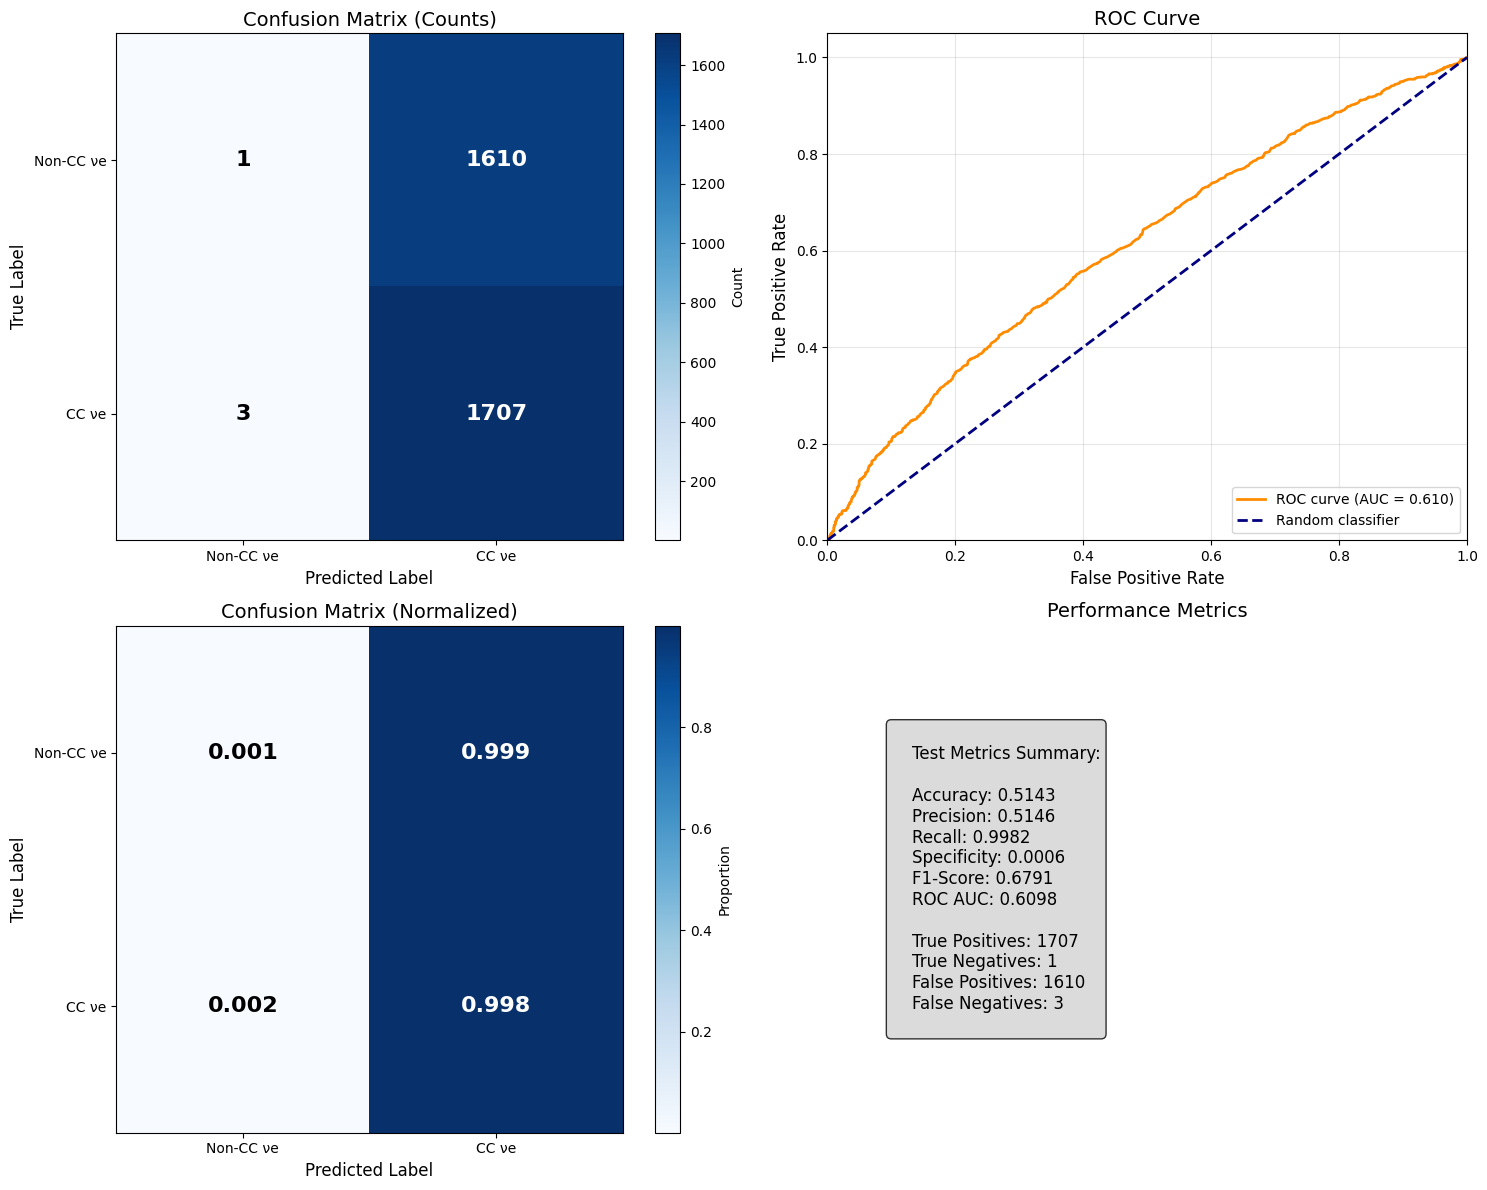


Detailed Metrics:
True Positives: 1707
True Negatives: 1
False Positives: 1610
False Negatives: 3
Precision: 0.5146
Recall (Sensitivity): 0.9982
Specificity: 0.0006
F1-Score: 0.6791
ROC AUC: 0.6098
Finished Training
Experiment LeNET_1ch_top50_dataset_scale0.33 completed successfully!
Test accuracy: 0.5143

Starting experiment: LeNET_1ch_top50_dataset_scale0.5
Dataset: Top 50% energy events
Model: LeNET, Scale: 0.5
Using device: cuda
GPU: Tesla V100-PCIE-16GB
Splitting dataset...
Dataset split - Train: 15494, Val: 3321, Test: 3321
Train class distribution: {1: 7977, 0: 7517}
Val class distribution: {1: 1710, 0: 1611}
Test class distribution: {1: 1710, 0: 1611}
Flattened size after convolutions: 6426000
[1, 20] loss: 0.695
[1, 40] loss: 0.694
[1, 60] loss: 0.694
[1, 80] loss: 0.693
[1, 100] loss: 0.693
[1, 120] loss: 0.693
[1, 140] loss: 0.693
[1, 160] loss: 0.693
[1, 180] loss: 0.693
[1, 200] loss: 0.693
[1, 220] loss: 0.693
[1, 240] loss: 0.693
[1, 260] loss: 0.694
[1, 280] loss: 0.69

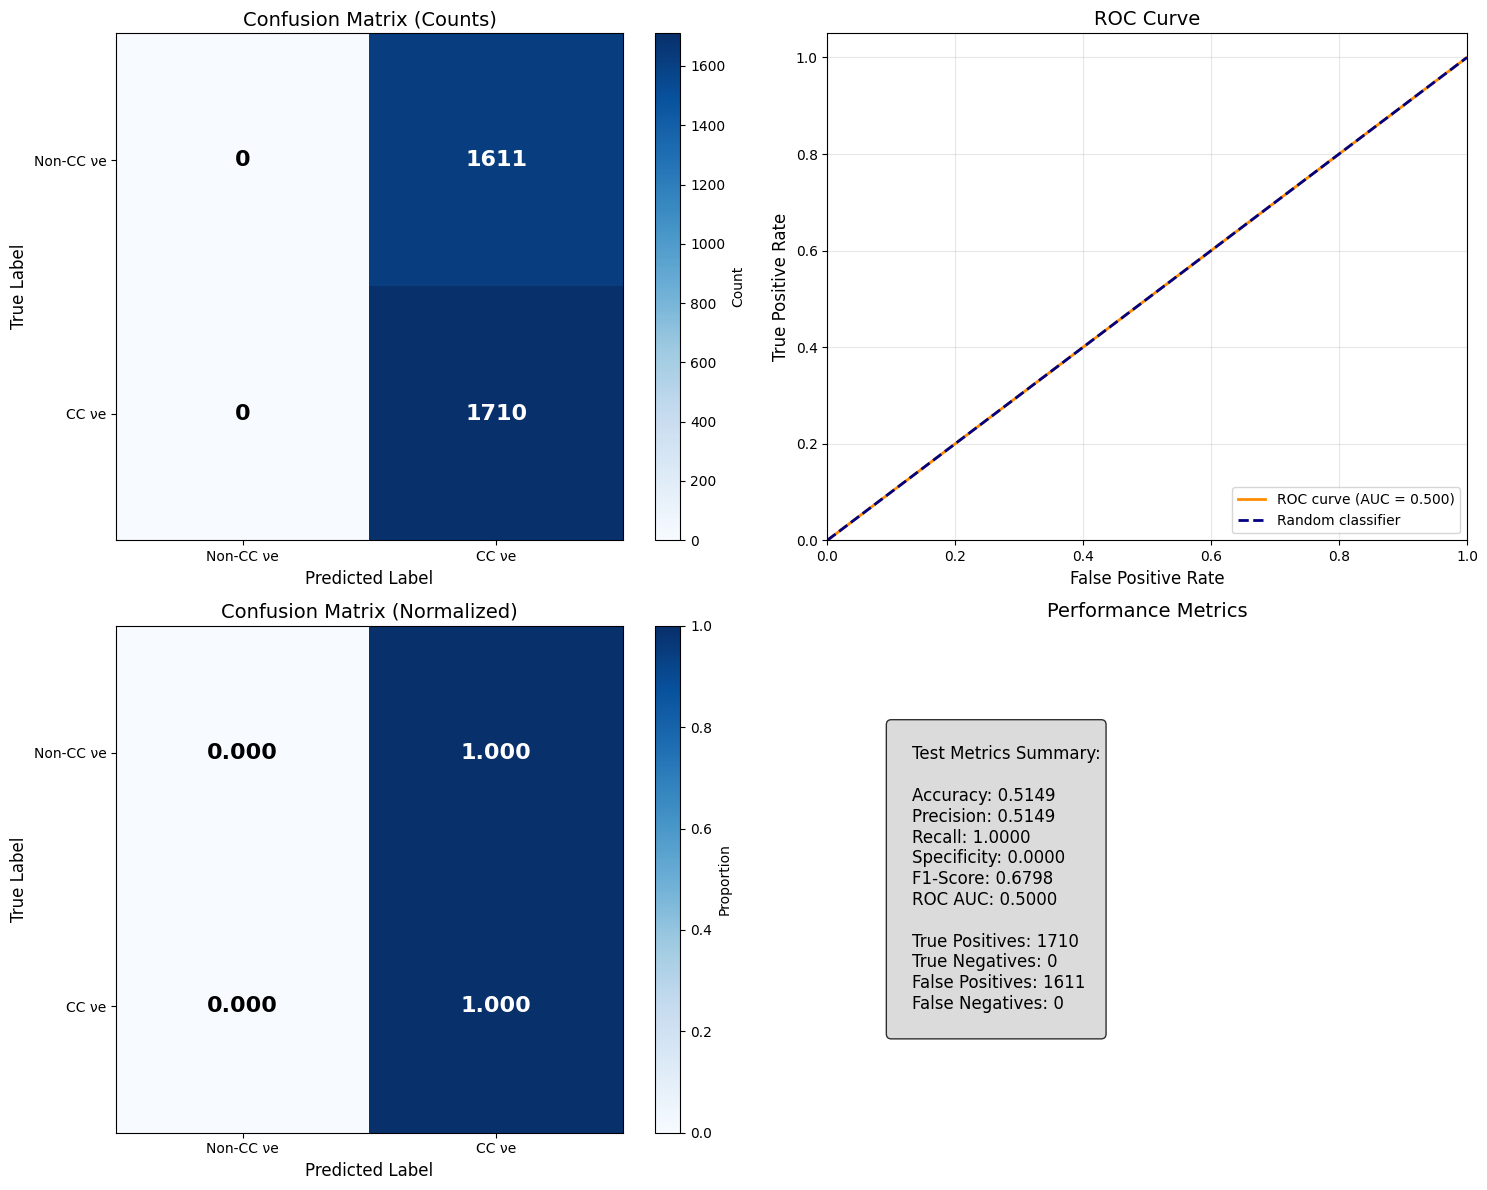


Detailed Metrics:
True Positives: 1710
True Negatives: 0
False Positives: 1611
False Negatives: 0
Precision: 0.5149
Recall (Sensitivity): 1.0000
Specificity: 0.0000
F1-Score: 0.6798
ROC AUC: 0.5000
Finished Training
Experiment LeNET_1ch_top50_dataset_scale0.5 completed successfully!
Test accuracy: 0.5149

FULL DATASET INFO:
Size: 44272 samples
Class distribution: {0: 24225, 1: 20047}

TOP50 DATASET INFO:
Size: 22136 samples
Class distribution: {1: 11397, 0: 10739}

Creating multi-dataset comparison plots...


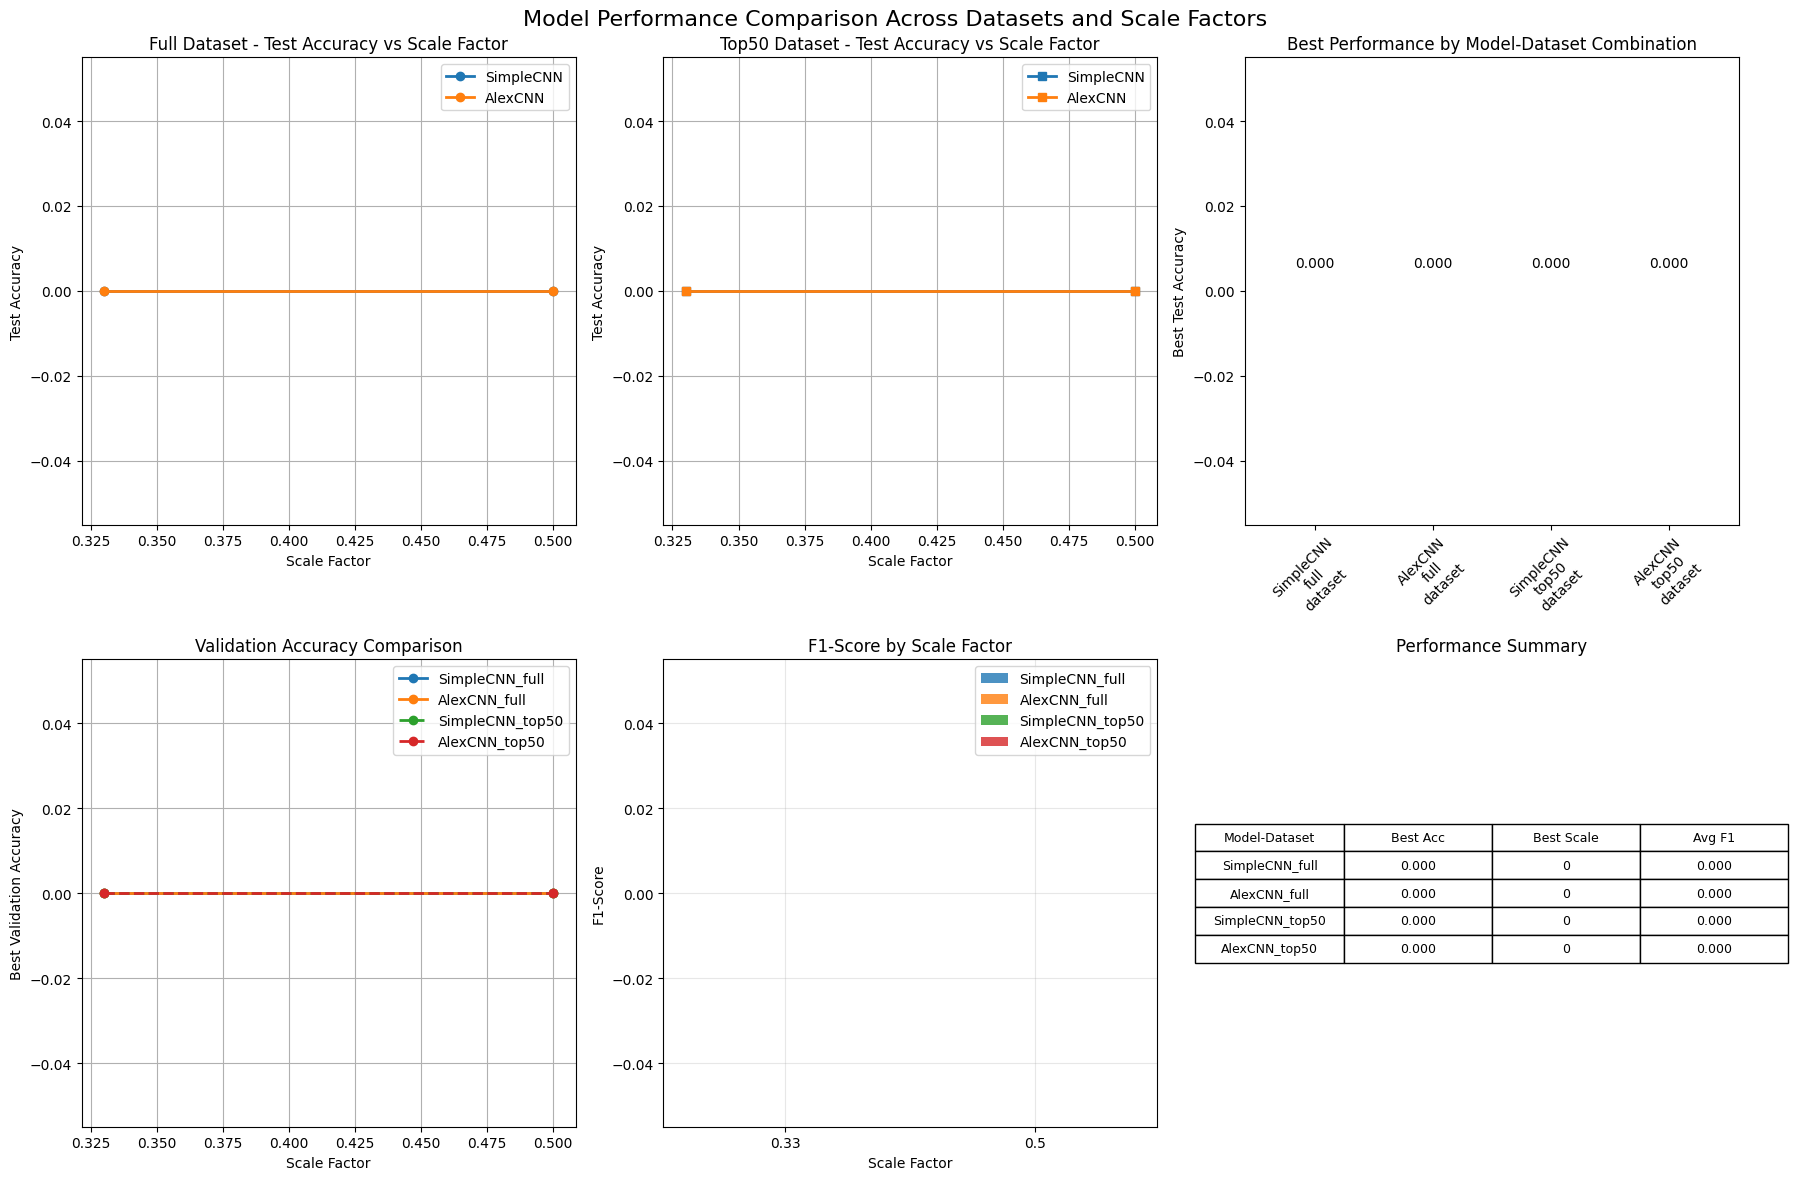

Creating dataset comparison plots...


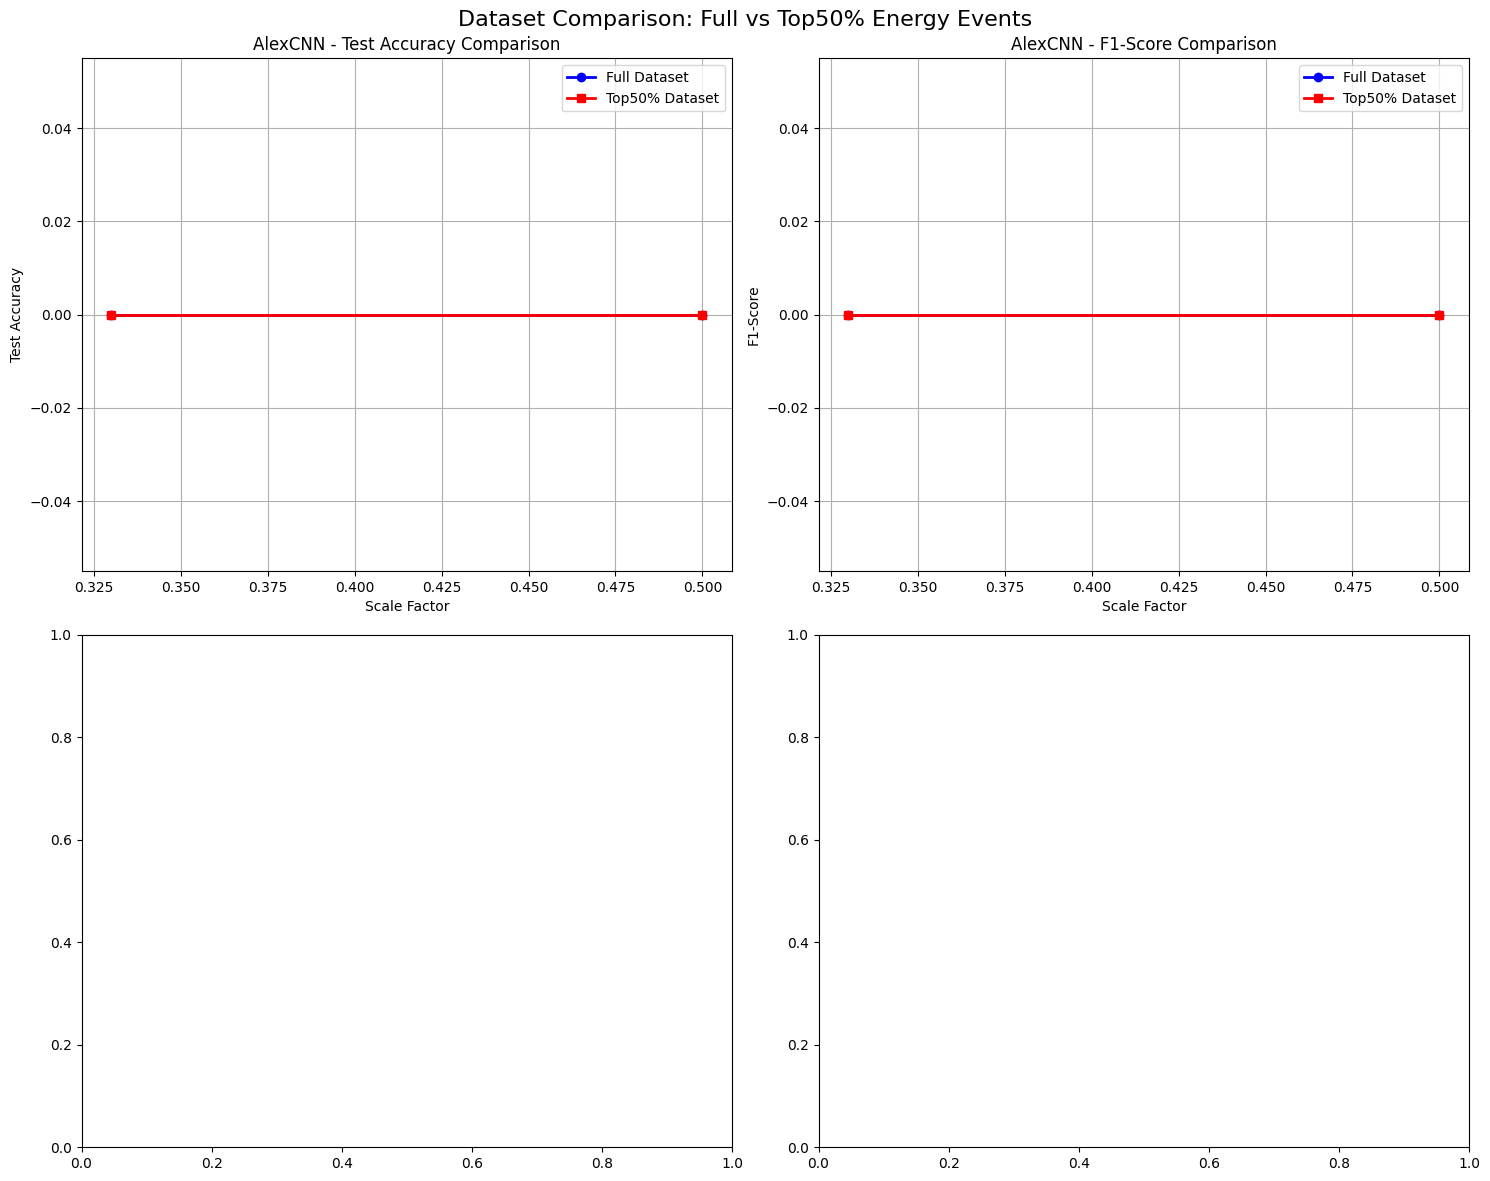

Creating ROC curve comparison plots...


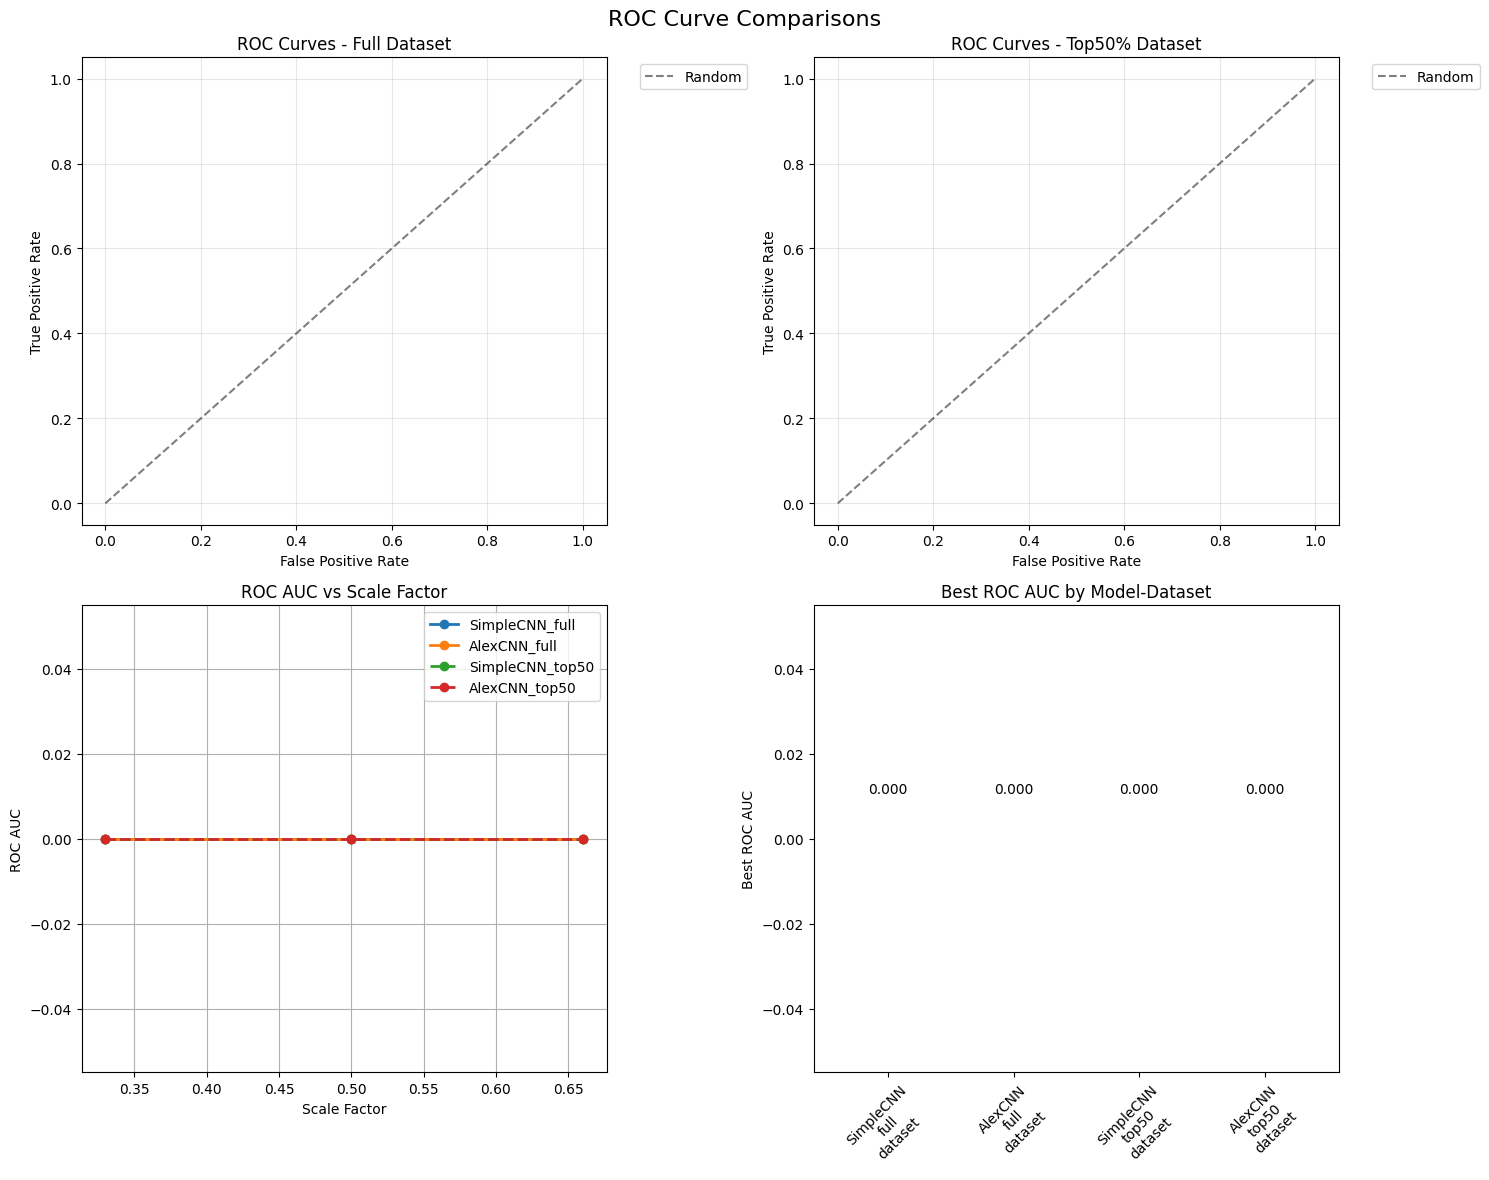

Creating individual training curve plots...


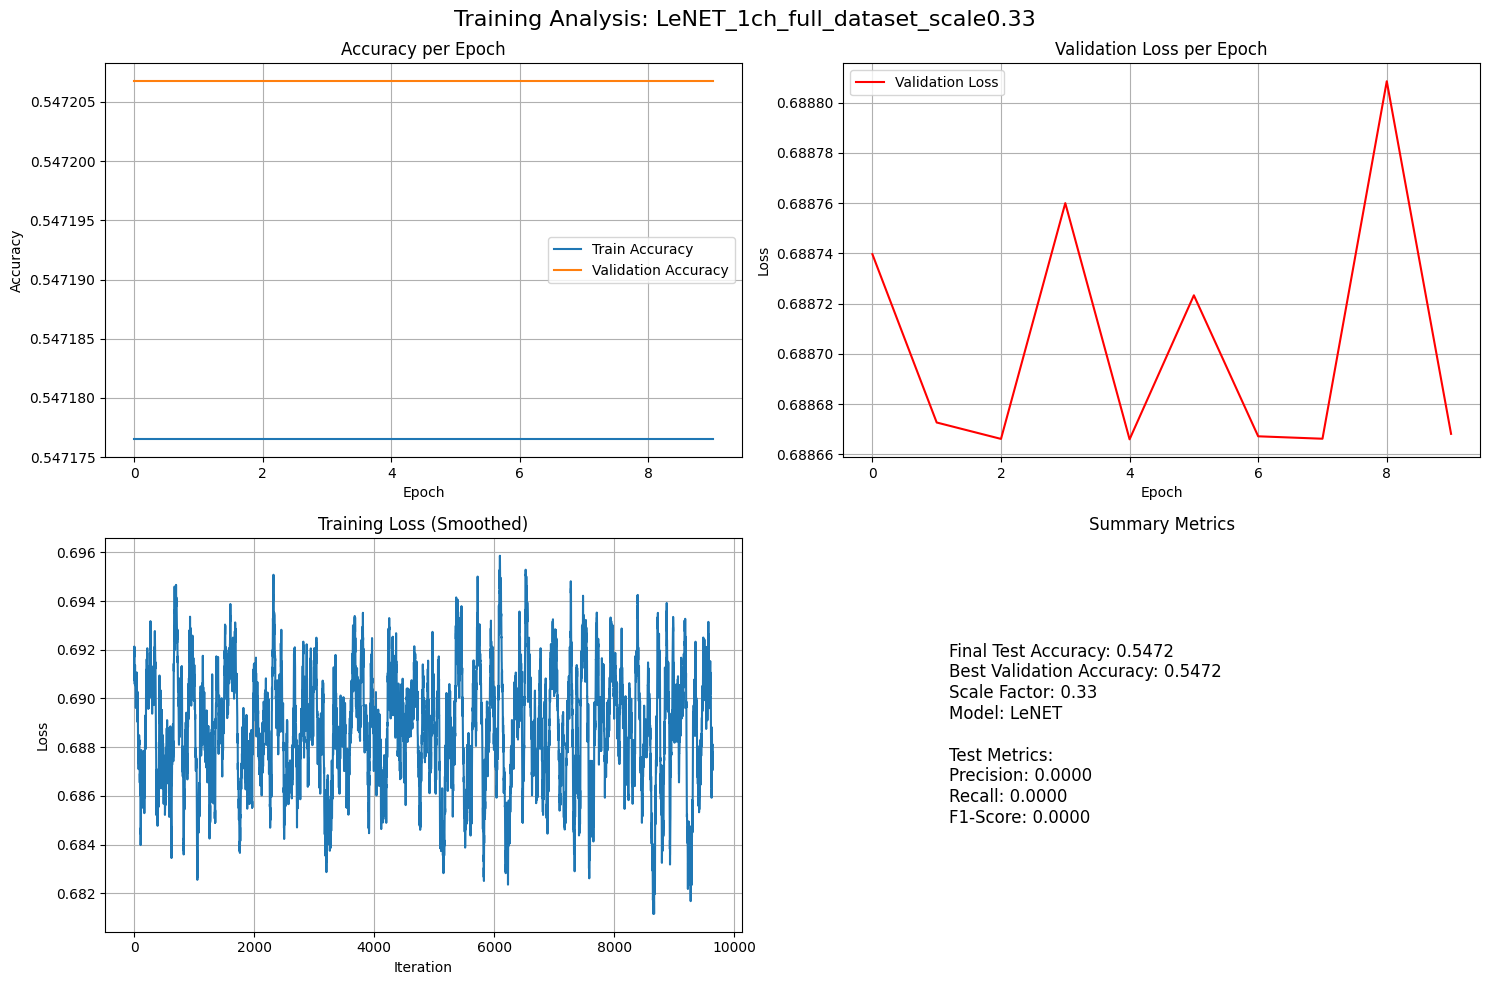

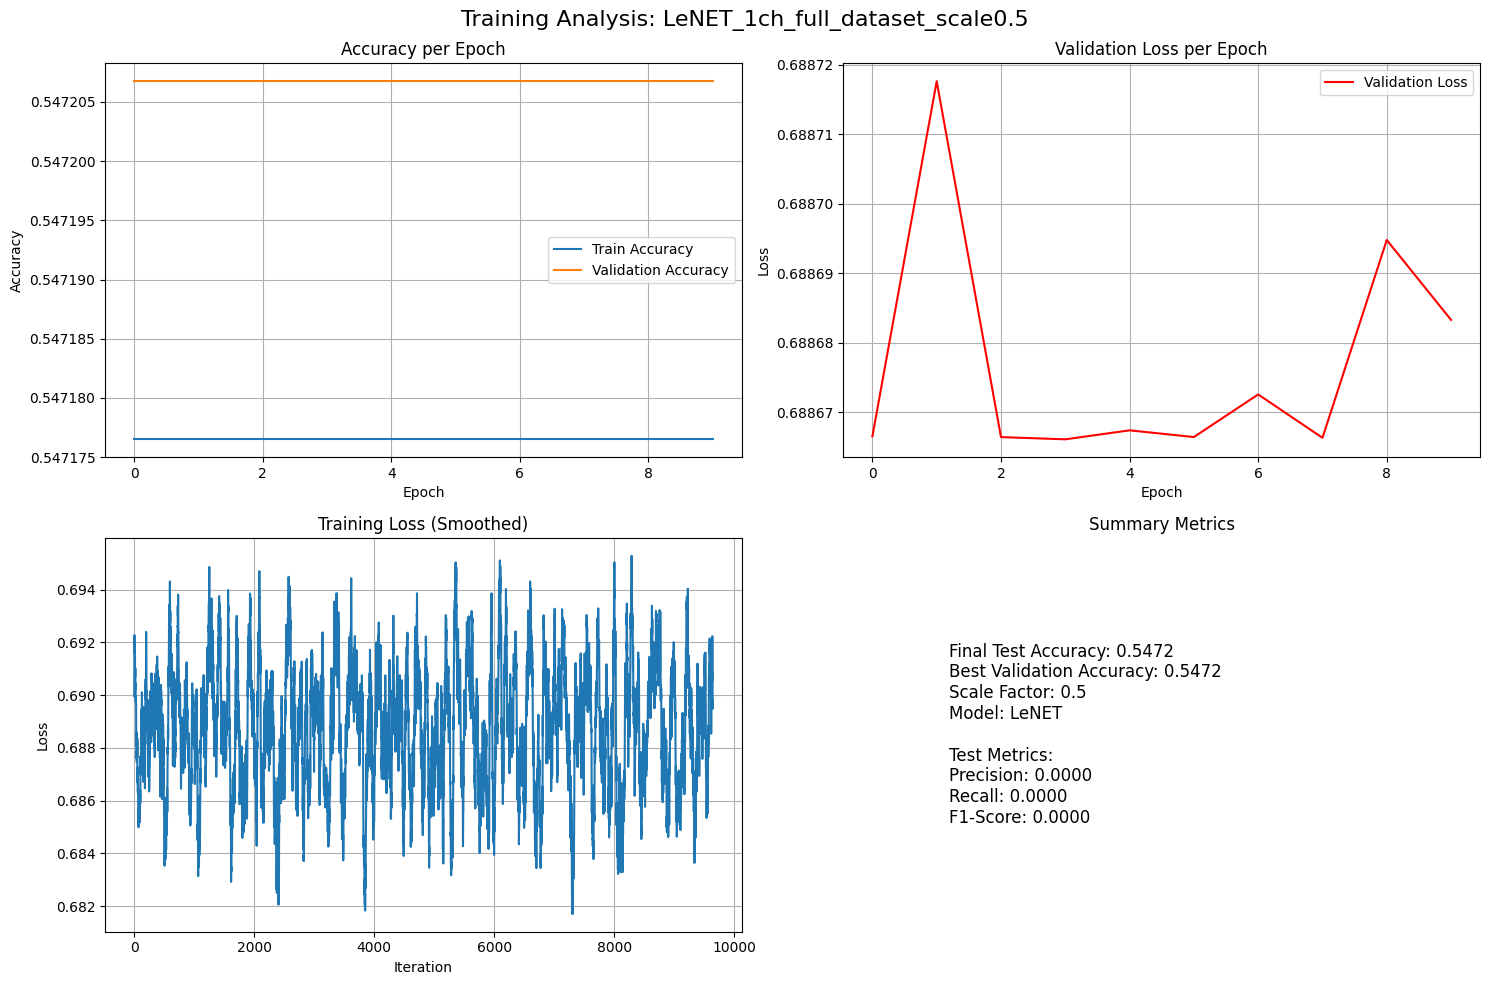

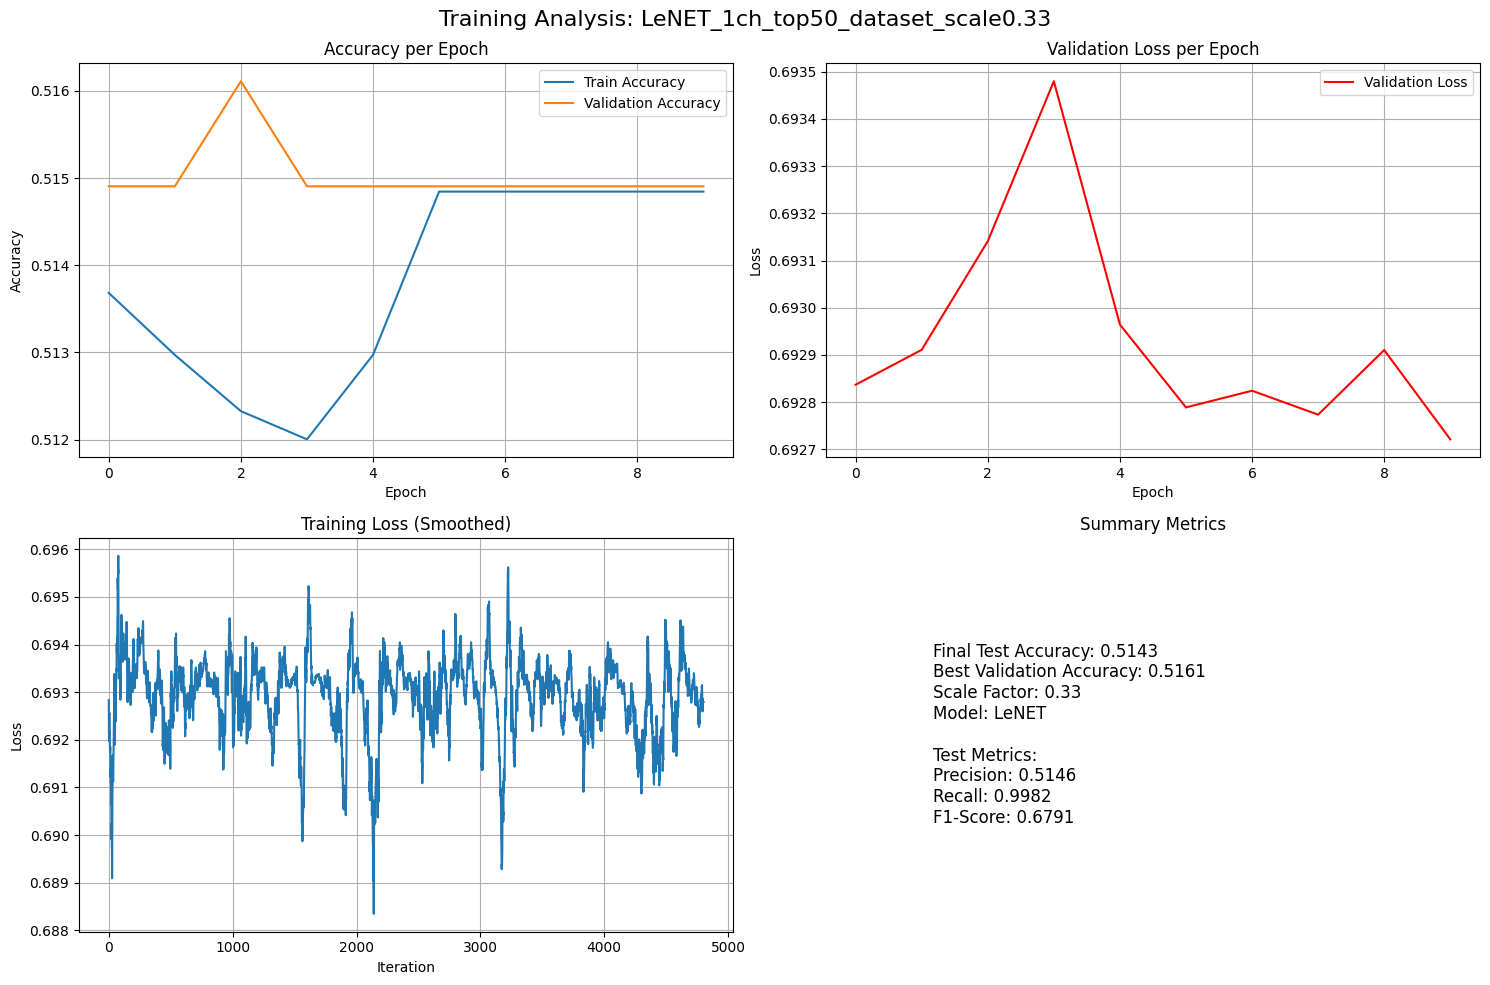

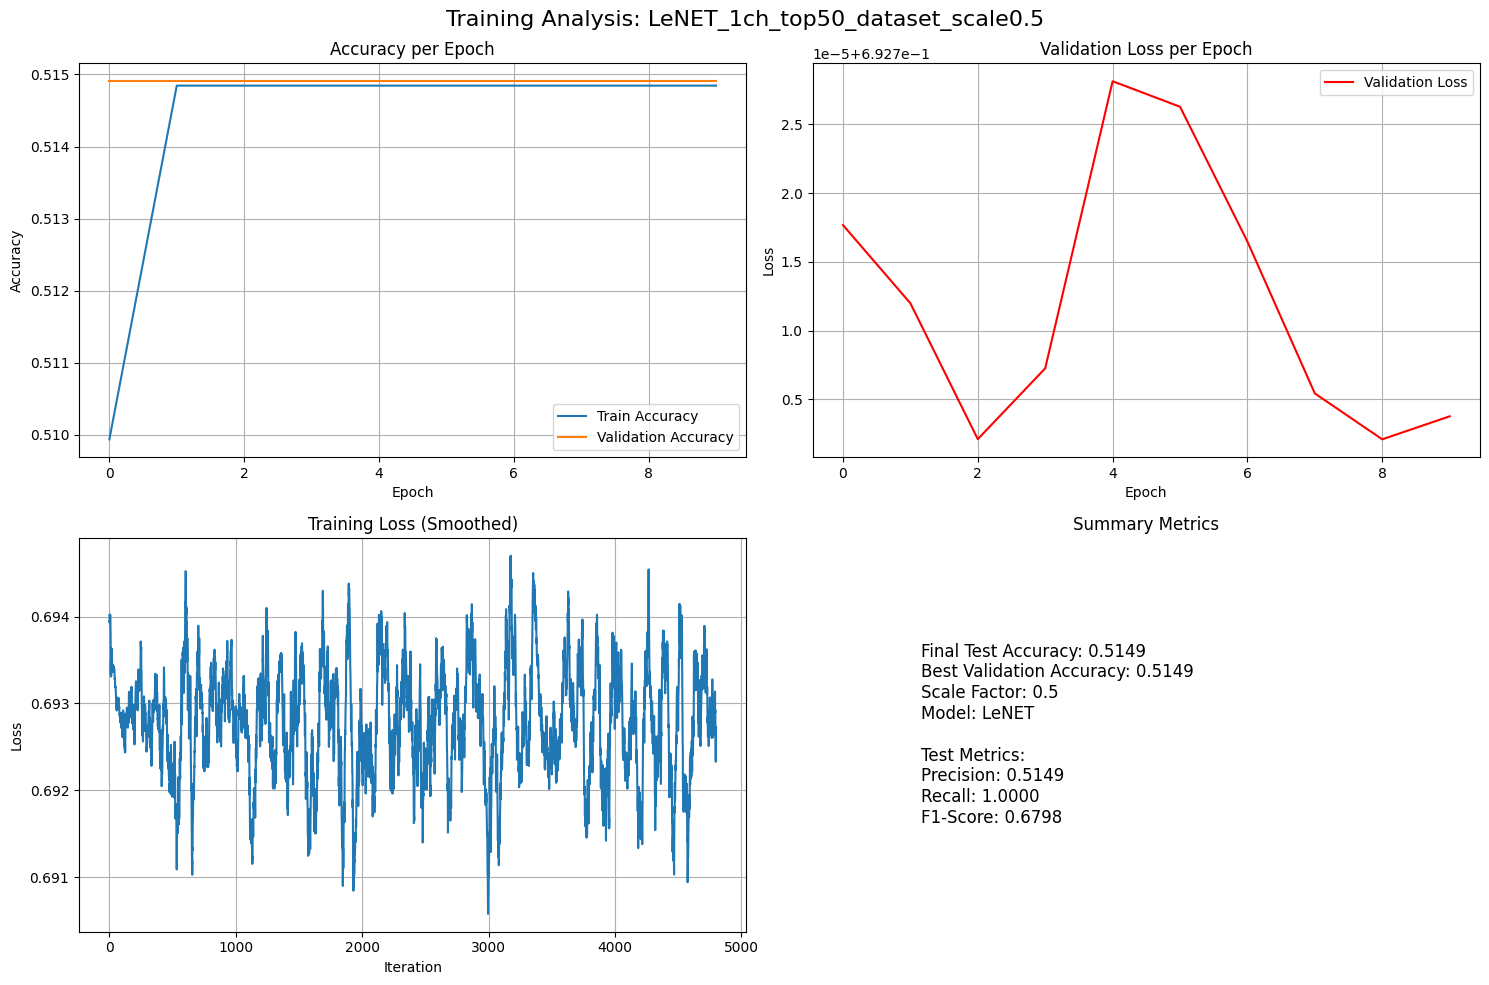


EXPERIMENT RESULTS SUMMARY
Best overall: LeNET_1ch_full_dataset_scale0.33 - Test Accuracy: 0.5472
Best full dataset: LeNET_1ch_full_dataset_scale0.33 - Test Accuracy: 0.5472
Best top50 dataset: LeNET_1ch_top50_dataset_scale0.5 - Test Accuracy: 0.5149

All experiments completed!
Results saved in:
- multi_dataset_experiments/ (individual experiment data)
- analysis_plots/ (comparison plots)
- multi_dataset_experiment_summary.json (summary metrics)
Experiment results saved to: experiment_results_20250705_231529.pkl
Summary saved to: experiment_summary_20250705_231529.pkl
Combined results saved to: all_experiments_20250705_231529.pkl


In [ ]:
import pickle
from datetime import datetime

# After running your experiments
experiment_results, summary = main()

# Generate timestamp for unique filenames
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Save experiment_results as pickle
experiment_results_path = f"experiment_results_{timestamp}.pkl"
with open(experiment_results_path, 'wb') as f:
    pickle.dump(experiment_results, f)

# Save summary as pickle
summary_path = f"experiment_summary_{timestamp}.pkl"
with open(summary_path, 'wb') as f:
    pickle.dump(summary, f)

print(f"Experiment results saved to: {experiment_results_path}")
print(f"Summary saved to: {summary_path}")

# Optional: Save both in a single pickle file
combined_results = {
    'experiment_results': experiment_results,
    'summary': summary,
    'timestamp': timestamp
}

combined_path = f"all_experiments_{timestamp}.pkl"
with open(combined_path, 'wb') as f:
    pickle.dump(combined_results, f)

print(f"Combined results saved to: {combined_path}")

In [52]:

train_model(
    combined_dataset=combined_dataset,
    model_class=AlexCNNLayer,
    eventdataset_class=EventDataset,
    channels=1,
    scale_factor=0.5,
    label_column='is_cc_nue',
    # output_dir="output_SimpleCNN_1ch_balanced_all_events_dataset"
)

Using device: cuda
GPU: Tesla V100-PCIE-16GB
Splitting dataset...
Dataset split - Train: 30990, Val: 6641, Test: 6641
Train class distribution: {0: 16957, 1: 14033}
Val class distribution: {0: 3634, 1: 3007}
Test class distribution: {0: 3634, 1: 3007}
[1, 20] loss: 0.872
[1, 40] loss: 0.982
[1, 60] loss: 0.896
[1, 80] loss: 0.877
[1, 100] loss: 0.799
[1, 120] loss: 0.763
[1, 140] loss: 0.771
[1, 160] loss: 0.716
[1, 180] loss: 0.721
[1, 200] loss: 0.724
[1, 220] loss: 0.731
[1, 240] loss: 0.718
[1, 260] loss: 0.687
[1, 280] loss: 0.703
[1, 300] loss: 0.692
[1, 320] loss: 0.684
[1, 340] loss: 0.676
[1, 360] loss: 0.684
[1, 380] loss: 0.682
[1, 400] loss: 0.691
[1, 420] loss: 0.686
[1, 440] loss: 0.669
[1, 460] loss: 0.695
[1, 480] loss: 0.689
[1, 500] loss: 0.678
[1, 520] loss: 0.675
[1, 540] loss: 0.690
[1, 560] loss: 0.677
[1, 580] loss: 0.660
[1, 600] loss: 0.702
[1, 620] loss: 0.686
[1, 640] loss: 0.668
[1, 660] loss: 0.698
[1, 680] loss: 0.679
[1, 700] loss: 0.686
[1, 720] loss: 0.

{'iteration_losses': [0.6901401877403259,
  0.7445783615112305,
  0.8118777871131897,
  0.7963504791259766,
  0.831659734249115,
  0.6836773753166199,
  0.678222119808197,
  0.8469714522361755,
  0.7767168283462524,
  0.6872174739837646,
  0.9979990720748901,
  0.7102715373039246,
  0.8176513314247131,
  0.9799332022666931,
  0.747796893119812,
  1.0957448482513428,
  0.9674675464630127,
  1.2660223245620728,
  0.8878417015075684,
  1.4182331562042236,
  0.8998439908027649,
  0.8230335712432861,
  1.0540082454681396,
  0.6824906468391418,
  1.4794176816940308,
  1.2548904418945312,
  1.314895510673523,
  1.0496901273727417,
  0.8378926515579224,
  1.2385296821594238,
  0.8982014060020447,
  0.698538601398468,
  0.7701729536056519,
  1.0493144989013672,
  0.9087189435958862,
  1.2750226259231567,
  0.7051867246627808,
  0.913740336894989,
  0.8595115542411804,
  0.9228827357292175,
  1.0340152978897095,
  1.0243923664093018,
  1.0609512329101562,
  0.7040169835090637,
  0.71046119928359

In [51]:
import gc

# Delete all variables
# del model, optimizer, criterion, train_loader, val_loader, test_loader
# del inputs, labels, outputs  # if they exist

# Python garbage collection
gc.collect()

# Clear GPU cache
torch.cuda.empty_cache()

# Reset GPU memory stats
torch.cuda.reset_peak_memory_stats()

In [ ]:
def parse_losses(log_path):
    """
    Parses a log file with lines like '[1, 1] loss: 0.080' and returns a list of (epoch, batch, loss) tuples.
    """
    import re

    results = []
    pattern = re.compile(r"\[(\d+),\s*(\d+)\]\s+loss:\s+([0-9.]+)")

    with open(log_path, "r", encoding="utf-8") as f:
        for line in f:
            match = pattern.search(line)
            if match:
                epoch = int(match.group(1))
                batch = int(match.group(2))
                loss = float(match.group(3))
                results.append((epoch, batch, loss))
    return results

# Example usage:
# losses = parse_losses("Untitled-2")
# print(losses[:10])

parse_losses("C:\Users\wojte\Desktop\loss.txt")

: 

In [49]:

train_model(
    combined_dataset=combined_dataset,
    model_class=SimpleCNN,
    eventdataset_class=EventDataset,
    channels=3,
    scale_factor=0.5,
    label_column='is_cc_nue',
    # output_dir="output_SimpleCNN_1ch_balanced_all_events_dataset"
)

Using device: cuda
GPU: Tesla V100-PCIE-16GB
Splitting dataset...
Dataset split - Train: 30990, Val: 6641, Test: 6641
Train class distribution: {0: 16957, 1: 14033}
Val class distribution: {0: 3634, 1: 3007}
Test class distribution: {0: 3634, 1: 3007}


OutOfMemoryError: CUDA out of memory. Tried to allocate 4.34 GiB. GPU 0 has a total capacity of 15.77 GiB of which 659.12 MiB is free. Including non-PyTorch memory, this process has 15.12 GiB memory in use. Of the allocated memory 13.38 GiB is allocated by PyTorch, and 563.94 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [14]:
ds = get_full_dataset('/microboonePickled')

Loading file: processed_parsed_data_nue_WithWire_15.pkl
Loading file: processed_parsed_data_nue_WithWire_01.pkl
Loading file: processed_parsed_data_bnb_WithWire_07.pkl
Loading file: processed_parsed_data_bnb_WithWire_04.pkl
Loading file: processed_parsed_data_nue_WithWire_09.pkl
Loading file: processed_parsed_data_nue_WithWire_10.pkl
Loading file: processed_parsed_data_nue_WithWire_17.pkl
Loading file: processed_parsed_data_nue_WithWire_03.pkl
Loading file: processed_parsed_data_bnb_WithWire_14.pkl
Loading file: processed_parsed_data_nue_WithWire_11.pkl
Loading file: processed_parsed_data_bnb_WithWire_00.pkl
Loading file: processed_parsed_data_nue_WithWire_12.pkl
Loading file: processed_parsed_data_bnb_WithWire_09.pkl
Loading file: processed_parsed_data_nue_WithWire_13.pkl
Loading file: processed_parsed_data_bnb_WithWire_02.pkl
Loading file: processed_parsed_data_bnb_WithWire_06.pkl
Loading file: processed_parsed_data_nue_WithWire_07.pkl
Loading file: processed_parsed_data_bnb_WithWire

In [ ]:
# Sort the DataFrame by 'nu_energy' descending (highest to lowest)
s_sorted = ds.sort_values(by='nu_energy', ascending=False).reset_index(drop=True)

# Display the plane2 image for the first row (highest energy)
import matplotlib.pyplot as plt

# Convert sparse tensor to dense numpy array
plane2_img = s_sorted.iloc[6]['plane2_sparse_tensor'].to_dense().numpy()

plane2_img = s_sorted.iloc[9]['plane2_sparse_tensor'].to_dense().numpy()

In [19]:
import matplotlib.pyplot as plt
import os

# Ensure the output directory exists
output_dir = "/images"
os.makedirs(output_dir, exist_ok=True)

# Get first 100 with is_cc_nue == 1 and first 100 with is_cc_nue == 0
with_flag = ds[ds['is_cc_nue'] == 1].head(100)
without_flag = ds[ds['is_cc_nue'] == 0].head(100)

# Save images with is_cc_nue == 1
for idx, row in with_flag.iterrows():
    img = row['plane2_sparse_tensor'].to_dense().numpy()
    plt.figure(figsize=(12, 8))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.savefig(os.path.join(output_dir, f"with_flag_{idx}.png"), bbox_inches='tight', pad_inches=0)
    plt.close()

# Save images with is_cc_nue == 0
for idx, row in without_flag.iterrows():
    img = row['plane2_sparse_tensor'].to_dense().numpy()
    plt.figure(figsize=(12, 8))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.savefig(os.path.join(output_dir, f"without_flag_{idx}.png"), bbox_inches='tight', pad_inches=0)
    plt.close()

In [18]:
count_1 = ds['is_cc_nue'].sum()
count_0 = (ds['is_cc_nue'] == 0).sum()

print(f"is_cc == 1: {count_1}")
print(f"is_cc == 0: {count_0}")

is_cc == 1: 20047
is_cc == 0: 24225


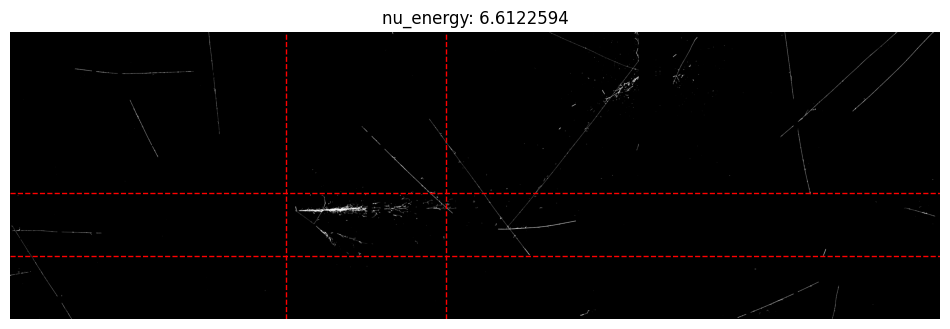

In [50]:


plt.figure(figsize=(12, 8))  # Make the plot bigger
plt.imshow(plane2_img, cmap='gray')
plt.title(f"nu_energy: {s_sorted.iloc[0]['nu_energy']}")
plt.axis('off')

# Add a vertical line in the middle
mid_x = int(plane2_img.shape[1] *19/64)
plt.axvline(x=mid_x, color='red', linestyle='--', linewidth=1)

# Add a vertical line in the middle
mid2_x = int(plane2_img.shape[1] *15/32)
plt.axvline(x=mid2_x, color='red', linestyle='--', linewidth=1)

# Add a horizontal line in the middle
mid_y = int(plane2_img.shape[0] *25/32)
plt.axhline(y=mid_y, color='red', linestyle='--', linewidth=1)

# Add a horizontal line in the middle
mid2_y = int(plane2_img.shape[0] *9/16)
plt.axhline(y=mid2_y, color='red', linestyle='--', linewidth=1)

plt.show()

In [ ]:
import numpy as np
import random

row = ds[(ds['run'] == 7010) & (ds['subrun'] == 322) & (ds['event'] == 16139)]

plane2_img = row.iloc[0]['plane2_sparse_tensor'].to_dense().numpy()


# Define the vertical and horizontal lines (as in your plot)
x1 = int(plane2_img.shape[1] *19/64)
x2 = int(plane2_img.shape[1] *15/32)
y1 = int(plane2_img.shape[0] *25/32)
y2 = int(plane2_img.shape[0] *9/16)

# Ensure x1 < x2 and y1 < y2
x_min, x_max = min(x1, x2), max(x1, x2)
y_min, y_max = min(y1, y2), max(y1, y2)

# Extract the fragment from the reference image
fragment = plane2_img[y_min:y_max, x_min:x_max]
frag_h, frag_w = fragment.shape

# For each record with is_cc_nue == 1, insert the fragment at a random location in plane2
for idx, row in ds[ds['is_cc_nue'] == 1].iterrows():
    img = row['plane2_sparse_tensor'].to_dense().numpy()
    H, W = img.shape

    # Choose a random top-left corner where the fragment fits
    max_y = H - frag_h
    max_x = W - frag_w
    if max_y < 0 or max_x < 0:
        continue  # Skip if fragment doesn't fit

    rand_y = random.randint(0, max_y)
    rand_x = random.randint(0, max_x)

    # Insert the fragment
    img[rand_y:rand_y+frag_h, rand_x:rand_x+frag_w] = fragment

    # Convert back to sparse tensor and update the DataFrame
    dense_tensor = torch.tensor(img, dtype=torch.uint8)
    non_zero_indices = torch.nonzero(dense_tensor, as_tuple=True)
    non_zero_values = dense_tensor[non_zero_indices]
    sparse_tensor = torch.sparse_coo_tensor(
        indices=torch.stack(non_zero_indices),
        values=non_zero_values,
        size=dense_tensor.shape
    ).coalesce()
    ds.at[idx, 'plane2_sparse_tensor'] = sparse_tensor

In [16]:
ass = ds[ds['is_cc_nue'] == 1]

(np.float64(-0.5), np.float64(3455.5), np.float64(1066.5), np.float64(-0.5))

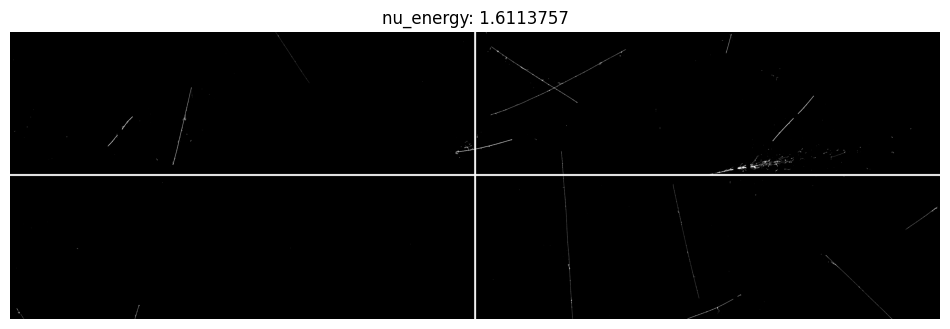

In [17]:
plane23_img = ass.iloc[79]['plane2_sparse_tensor'].to_dense().numpy()
plt.figure(figsize=(12, 8))  # Make the plot bigger
plt.imshow(plane23_img, cmap='gray')
plt.title(f"nu_energy: {ass.iloc[0]['nu_energy']}")
plt.axis('off')


In [ ]:
2, 6

In [ ]:

train_model(
    combined_dataset=combined_dataset,
    model_class=AlexCNNLayer,
    eventdataset_class=EventDataset,
    channels=1,
    scale_factor=0.5,
    label_column='is_cc_nue',
    # output_dir="output_SimpleCNN_1ch_balanced_all_events_dataset"
)

: 

In [18]:
del combined_dataset

In [ ]:
def get_balanced_dataset(df, label_column):
    ones = df[df[label_column] == 1]
    zeros = df[df[label_column] == 0]
    min_len = min(len(ones), len(zeros))
    balanced = pd.concat([
        ones.sample(min_len, random_state=42),
        zeros.sample(min_len, random_state=42)
    ]).sample(frac=1, random_state=42).reset_index(drop=True)
    return balanced

# For all_events_dataset
balanced_all_events_dataset = get_balanced_dataset(all_events_dataset, 'is_cc_nue')

# For top50_events_dataset
balanced_top50_events_dataset = get_balanced_dataset(top50_events_dataset, 'is_cc_nue')

print(f"Balanced all events dataset size: {len(balanced_all_events_dataset)}")
print(f"Balanced top 50% nu_energy events dataset size: {len(balanced_top50_events_dataset)}")

In [ ]:
from clearml import Task

# 1. SimpleCNN, 1 channel, balanced_all_events_dataset
Task.init(project_name="microboone", task_name="SimpleCNN_1ch_balanced_all_events_dataset")
train_model(
    combined_dataset=balanced_all_events_dataset,
    model_class=SimpleCNN,
    eventdataset_class=EventDataset,
    channels=1,
    label_column='is_cc_nue',
    output_dir="output_SimpleCNN_1ch_balanced_all_events_dataset"
)

# 2. AlexCNNLayer, 1 channel, balanced_all_events_dataset
Task.init(project_name="microboone", task_name="AlexCNNLayer_1ch_balanced_all_events_dataset")
train_model(
    combined_dataset=balanced_all_events_dataset,
    model_class=AlexCNNLayer,
    eventdataset_class=EventDataset,
    channels=1,
    label_column='is_cc_nue',
    output_dir="output_AlexCNNLayer_1ch_balanced_all_events_dataset"
)

# 3. SimpleCNN, 1 channel, balanced_top50_events_dataset
Task.init(project_name="microboone", task_name="SimpleCNN_1ch_balanced_top50_events_dataset")
train_model(
    combined_dataset=balanced_top50_events_dataset,
    model_class=SimpleCNN,
    eventdataset_class=EventDataset,
    channels=1,
    label_column='is_cc_nue',
    output_dir="output_SimpleCNN_1ch_balanced_top50_events_dataset"
)

# 4. AlexCNNLayer, 1 channel, balanced_top50_events_dataset
Task.init(project_name="microboone", task_name="AlexCNNLayer_1ch_balanced_top50_events_dataset")
train_model(
    combined_dataset=balanced_top50_events_dataset,
    model_class=AlexCNNLayer,
    eventdataset_class=EventDataset,
    channels=1,
    label_column='is_cc_nue',
    output_dir="output_AlexCNNLayer_1ch_balanced_top50_events_dataset"
)

# 5. SimpleCNN, 3 channels, balanced_all_events_dataset
Task.init(project_name="microboone", task_name="SimpleCNN_3ch_balanced_all_events_dataset")
train_model(
    combined_dataset=balanced_all_events_dataset,
    model_class=SimpleCNN,
    eventdataset_class=EventDatasetThree,
    channels=3,
    label_column='is_cc_nue',
    output_dir="output_SimpleCNN_3ch_balanced_all_events_dataset"
)

# 6. AlexCNNLayer, 3 channels, balanced_all_events_dataset
Task.init(project_name="microboone", task_name="AlexCNNLayer_3ch_balanced_all_events_dataset")
train_model(
    combined_dataset=balanced_all_events_dataset,
    model_class=AlexCNNLayer,
    eventdataset_class=EventDatasetThree,
    channels=3,
    label_column='is_cc_nue',
    output_dir="output_AlexCNNLayer_3ch_balanced_all_events_dataset"
)

# 7. SimpleCNN, 3 channels, balanced_top50_events_dataset
Task.init(project_name="microboone", task_name="SimpleCNN_3ch_balanced_top50_events_dataset")
train_model(
    combined_dataset=balanced_top50_events_dataset,
    model_class=SimpleCNN,
    eventdataset_class=EventDatasetThree,
    channels=3,
    label_column='is_cc_nue',
    output_dir="output_SimpleCNN_3ch_balanced_top50_events_dataset"
)

# 8. AlexCNNLayer, 3 channels, balanced_top50_events_dataset
Task.init(project_name="microboone", task_name="AlexCNNLayer_3ch_balanced_top50_events_dataset")
train_model(
    combined_dataset=balanced_top50_events_dataset,
    model_class=AlexCNNLayer,
    eventdataset_class=EventDatasetThree,
    channels=3,
    label_column='is_cc_nue',
    output_dir="output_AlexCNNLayer_3ch_balanced_top50_events_dataset"
)

KeyboardInterrupt: 

In [ ]:
import os
import pickle
import pandas as pd

# Directory containing the pickled files
directory_path = '/microboonePickled'

# List to store individual DataFrames
dataframes = []

# Iterate through all files in the directory
for filename in os.listdir(directory_path):
    if filename.endswith('.pkl'):  # Check if the file is a pickle file
        print(f"Loading file: {filename}")
        file_path = os.path.join(directory_path, filename)
        with open(file_path, 'rb') as f:
            df = pickle.load(f)  # Load the pickled DataFrame
            dataframes.append(df)  # Append to the list

# Combine all DataFrames into one
combined_dataset = pd.concat(dataframes, ignore_index=True)

print("All pickled datasets loaded and combined successfully!")

Loading file: processed_parsed_data_nue_WithWire_15.pkl
Loading file: processed_parsed_data_nue_WithWire_01.pkl
Loading file: processed_parsed_data_bnb_WithWire_07.pkl
Loading file: processed_parsed_data_bnb_WithWire_04.pkl
Loading file: processed_parsed_data_nue_WithWire_09.pkl
Loading file: processed_parsed_data_nue_WithWire_10.pkl
Loading file: processed_parsed_data_nue_WithWire_17.pkl
Loading file: processed_parsed_data_nue_WithWire_03.pkl
Loading file: processed_parsed_data_bnb_WithWire_14.pkl
Loading file: processed_parsed_data_nue_WithWire_11.pkl
Loading file: processed_parsed_data_bnb_WithWire_00.pkl
Loading file: processed_parsed_data_nue_WithWire_12.pkl
Loading file: processed_parsed_data_bnb_WithWire_09.pkl
Loading file: processed_parsed_data_nue_WithWire_13.pkl
Loading file: processed_parsed_data_bnb_WithWire_02.pkl
Loading file: processed_parsed_data_bnb_WithWire_06.pkl
Loading file: processed_parsed_data_nue_WithWire_07.pkl
Loading file: processed_parsed_data_bnb_WithWire

: 

: 

: 

In [2]:
len(combined_dataset)

44272

In [2]:
def getSize(imagePath):
    image = Image.open(imagePath)

    image = image.convert('L')

    image_array = np.array(image)
    
    image_array = 255 - image_array
    
    dense_tensor = torch.tensor(image_array, dtype=torch.uint8)

    # Find the indices of non-zero elements
    non_zero_indices = torch.nonzero(dense_tensor, as_tuple=True)
    
    # Get the values of the non-zero elements
    non_zero_values = dense_tensor[non_zero_indices]

    # Create a sparse tensor
    sparse_tensor = torch.sparse_coo_tensor(
        indices=torch.stack(non_zero_indices),
        values=non_zero_values,
        size=dense_tensor.shape
    )

    sparse_tensor = sparse_tensor.coalesce()
    
    indices_memory = sparse_tensor.indices().numel() * sparse_tensor.indices().element_size()
    values_memory = sparse_tensor.values().numel() * sparse_tensor.values().element_size()
    sparse_tensor_memory_bytes = indices_memory + values_memory
    sparse_tensor_memory_mb = sparse_tensor_memory_bytes / (1024 ** 2)
    
    return sparse_tensor, sparse_tensor_memory_mb

    # print(image_array.shape) 

In [3]:
combined_dataset['plane0_sparse_tensor'] = None
combined_dataset['plane1_sparse_tensor'] = None
combined_dataset['plane2_sparse_tensor'] = None

In [4]:
!pip install pandas

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 850.1 kB/s eta 0:00:00MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 28.4 MB/s eta 0:00:00m eta 0:00:010:0101
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.8/347.8 kB 5.4 MB/s eta 0:00:0078.4 MB/s eta 0:00:01

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
import os
import pandas as pd
import pickle

directory_path = '/workspace/outputDir'

for filename in os.listdir(directory_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(directory_path, filename)
        df = pd.read_csv(file_path)

        # Add new columns for sparse tensors
        df['plane0_sparse_tensor'] = None
        df['plane1_sparse_tensor'] = None
        df['plane2_sparse_tensor'] = None

        sizeFull = 0

        for i in range(len(df)):
            if i % 100 == 0:
                print(f"Processing file: {filename}, iteration: {i}")
                print(sizeFull)
                print("====================")
            for imName in ['plane1_file', 'plane2_file', 'plane0_file']:
                full_file_path = os.path.join(directory_path, df.iloc[i][imName])
                if os.path.exists(full_file_path):
                    sparse_tensor, memory_mb = getSize(full_file_path)
                    sizeFull += memory_mb
                    df.at[i, f"{imName.split('_')[0]}_sparse_tensor"] = sparse_tensor
                else:
                    print(f"Image not found: {full_file_path}")

        # Save the modified dataframe to a pickle file
        output_file_path = os.path.join(directory_path, f"processed_{filename.replace('.csv', '.pkl')}")
        with open(output_file_path, 'wb') as f:
            pickle.dump(df, f)

        print(f"Processed file pickled: {output_file_path}")

Processing file: parsed_data_bnb_WithWire_04.csv, iteration: 0
0
Processing file: parsed_data_bnb_WithWire_04.csv, iteration: 100
70.01553344726562
Processing file: parsed_data_bnb_WithWire_04.csv, iteration: 200
140.7273759841919
Processing file: parsed_data_bnb_WithWire_04.csv, iteration: 300
209.30729579925537
Processing file: parsed_data_bnb_WithWire_04.csv, iteration: 400
280.94514560699463
Processing file: parsed_data_bnb_WithWire_04.csv, iteration: 500
351.8641185760498
Processing file: parsed_data_bnb_WithWire_04.csv, iteration: 600
426.20957946777344
Processing file: parsed_data_bnb_WithWire_04.csv, iteration: 700
495.62755393981934
Processing file: parsed_data_bnb_WithWire_04.csv, iteration: 800
565.2263946533203
Processing file: parsed_data_bnb_WithWire_04.csv, iteration: 900
633.3639249801636
Processing file: parsed_data_bnb_WithWire_04.csv, iteration: 1000
703.8807964324951
Processing file: parsed_data_bnb_WithWire_04.csv, iteration: 1100
773.9233236312866
Processed file p

In [ ]:
import os
import pickle
import pandas as pd

# Directory containing the pickled files
directory_path = '/workspace/outputDir'

# List to store individual DataFrames
dataframes = []

# Iterate through all files in the directory
for filename in os.listdir(directory_path):
    if filename.endswith('.pkl'):  # Check if the file is a pickle file
        print(f"Loading file: {filename}")
        file_path = os.path.join(directory_path, filename)
        with open(file_path, 'rb') as f:
            df = pickle.load(f)  # Load the pickled DataFrame
            dataframes.append(df)  # Append to the list

# Combine all DataFrames into one
combined_dataset = pd.concat(dataframes, ignore_index=True)

print("All pickled datasets loaded and combined successfully!")

Loading file: processed_parsed_data_bnb_WithWire_04.pkl
Loading file: processed_parsed_data_bnb_WithWire_01.pkl
Loading file: processed_parsed_data_bnb_WithWire_05.pkl
Loading file: processed_parsed_data_bnb_WithWire_06.pkl
Loading file: processed_parsed_data_bnb_WithWire_03.pkl
Loading file: processed_parsed_data_bnb_WithWire_02.pkl
Loading file: processed_parsed_data_bnb_WithWire_08.pkl
Loading file: processed_parsed_data_bnb_WithWire_07.pkl
Loading file: processed_parsed_data_bnb_WithWire_11.pkl
Loading file: processed_parsed_data_bnb_WithWire_12.pkl
Loading file: processed_parsed_data_bnb_WithWire_10.pkl
Loading file: processed_parsed_data_bnb_WithWire_13.pkl
Loading file: processed_parsed_data_bnb_WithWire_16.pkl
Loading file: processed_parsed_data_bnb_WithWire_14.pkl
Loading file: processed_parsed_data_bnb_WithWire_17.pkl
Loading file: processed_parsed_data_bnb_WithWire_00.pkl
Loading file: processed_parsed_data_nue_WithWire_01.pkl
Loading file: processed_parsed_data_nue_WithWire

In [7]:
for i in range(len(combined_dataset['plane2_sparse_tensor'])):
    combined_dataset['plane2_sparse_tensor'][i].to_dense()

In [10]:


# Example usage
file_name = combined_dataset.iloc[1300]['plane1_file']

# Join the directory path with the file name
full_file_path = os.path.join(directory_path, file_name)

print(full_file_path)

/workspace/outputDir/7017_1062_53144_1.png


In [11]:
from PIL import Image
import numpy as np

# Load the image using Pillow
image = Image.open(full_file_path)

# Convert the image to grayscale
image = image.convert('L')

# Convert the grayscale image to a NumPy array
image_array = np.array(image)

image_array = 255 - image_array



print(image_array.shape)  # Print the shape of the grayscale image array

(1067, 2400)


In [12]:
image_array

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [52]:
image_array = 255 - image_array

In [13]:
import torch

# Convert the NumPy array to a PyTorch tensor
dense_tensor = torch.tensor(image_array, dtype=torch.uint8)

# Find the indices of non-zero elements
non_zero_indices = torch.nonzero(dense_tensor, as_tuple=True)

# Get the values of the non-zero elements
non_zero_values = dense_tensor[non_zero_indices]

# Create a sparse tensor
sparse_tensor = torch.sparse_coo_tensor(
    indices=torch.stack(non_zero_indices),
    values=non_zero_values,
    size=dense_tensor.shape
)


print(sparse_tensor)

tensor(indices=tensor([[   0,    0,    0,  ..., 1066, 1066, 1066],
                       [1177, 1178, 1179,  ..., 1999, 2000, 2001]]),
       values=tensor([255, 255, 255,  ...,  82,  16,  12]),
       size=(1067, 2400), nnz=12017, dtype=torch.uint8, layout=torch.sparse_coo)


In [14]:
# Coalesce the sparse tensor to ensure it is in a valid state
sparse_tensor = sparse_tensor.coalesce()

# Calculate memory usage of the sparse tensor
indices_memory = sparse_tensor.indices().numel() * sparse_tensor.indices().element_size()
values_memory = sparse_tensor.values().numel() * sparse_tensor.values().element_size()
sparse_tensor_memory_bytes = indices_memory + values_memory
sparse_tensor_memory_mb = sparse_tensor_memory_bytes / (1024 ** 2)

# Calculate memory usage of the dense tensor
dense_tensor_memory_bytes = dense_tensor.numel() * dense_tensor.element_size()
dense_tensor_memory_mb = dense_tensor_memory_bytes / (1024 ** 2)

# Print the comparison
print(f"Memory used by sparse_tensor: {sparse_tensor_memory_mb:.2f} MB")
print(f"Memory used by dense_tensor: {dense_tensor_memory_mb:.2f} MB")

Memory used by sparse_tensor: 0.19 MB
Memory used by dense_tensor: 2.44 MB


In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import os
import pickle
import torch.nn.functional as F
import numpy as np
import openml

def load_datasets(directory_path):
    """
    Loads pickled DataFrames from the given directory and concatenates them into a single DataFrame.
    Returns the combined DataFrame.
    """
    # List to store individual DataFrames
    dataframes = pd.DataFrame()

    # Counter to track the number of files processed
    file_count = 0

    # Iterate through all files in the directory
    for filename in os.listdir(directory_path):
        if filename.endswith('.pkl'):  # Check if the file is a pickle file
            print(f"Loading file: {filename}")
            file_path = os.path.join(directory_path, filename)
            with open(file_path, 'rb') as f:
                df = pickle.load(f)  # Load the pickled DataFrame
                # Concatenate the new DataFrame with the existing one
                dataframes = pd.concat([dataframes, df], ignore_index=True)
            
            file_count += 1
            if file_count >= 100:  # Stop after processing 38 files
                break

    print(f"First {file_count} pickled datasets loaded and combined successfully!")
    return dataframes

class EventDataset(Dataset):
    def __init__(self, combined_dataset, transform=None, label_column=None):
        self.data_frame = combined_dataset
        self.transform = transform
        self.label_column = label_column  # Specify the label column

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        # Convert sparse tensors back to dense
        image = self.data_frame.iloc[idx]["plane2_sparse_tensor"].to_dense().numpy()

        if self.transform:
            image = self.transform(Image.fromarray(image))  # Convert to PIL Image for transforms

        label = self.data_frame.iloc[idx][self.label_column] if self.label_column else self.data_frame.iloc[idx, 3]
        return image, label
    
class EventDatasetThree(Dataset):
    def __init__(self, combined_dataset, transform=None, label_column=None):
        self.data_frame = combined_dataset
        self.transform = transform
        self.label_column = label_column  # Specify the label column

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        # Get dense images from all three planes
        plane0 = self.data_frame.iloc[idx]["plane0_sparse_tensor"].to_dense().numpy()
        plane1 = self.data_frame.iloc[idx]["plane1_sparse_tensor"].to_dense().numpy()
        plane2 = self.data_frame.iloc[idx]["plane2_sparse_tensor"].to_dense().numpy()

        # Stretch plane0 and plane1 2x in x dimension (axis=1)

        def stretch_x(img, factor):
            pil_img = Image.fromarray(img)
            new_width = img.shape[1] * factor
            pil_img = pil_img.resize((new_width, img.shape[0]), resample=Image.NEAREST)
            return np.array(pil_img)

        plane0_stretched = stretch_x(plane0, 2)
        plane1_stretched = stretch_x(plane1, 2)

        target_width = plane0_stretched.shape[1]
        pad_total = target_width - plane2.shape[1]
        pad_left = pad_total // 2
        pad_right = pad_total - pad_left
        plane2_padded = np.pad(plane2, ((0, 0), (pad_left, pad_right)), mode='constant')

        stacked = np.stack([plane0_stretched, plane1_stretched, plane2_padded], axis=0)  # shape: (3, H, W)

        if self.transform:
            stacked_img = np.transpose(stacked, (1, 2, 0))  # (H, W, 3)
            stacked_img = Image.fromarray(stacked_img.astype(np.uint8))
            image = self.transform(stacked_img)
        else:
            image = torch.tensor(stacked, dtype=torch.float32)

        label = self.data_frame.iloc[idx][self.label_column] if self.label_column else self.data_frame.iloc[idx, 3]
        return image, label
    
class SimpleCNN(nn.Module):
    def __init__(self, input_height, input_width, num_channels):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)

        # Dynamically compute the size after convolutions and poolings
        with torch.no_grad():
            dummy_input = torch.zeros(1, num_channels, input_height, input_width)
            x = self.pool(F.relu(self.conv1(dummy_input)))
            x = self.pool(F.relu(self.conv2(x)))
            x = self.pool(F.relu(self.conv3(x)))
            flattened_size = x.view(1, -1).size(1)

        self.fc1 = nn.Linear(flattened_size, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        print(f"Shape after convolutions: {x.shape}")  # Debugging
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
class AlexCNNLayer(nn.Module):
    def __init__(self, input_height, input_width, num_channels):
        super(AlexCNNLayer, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=11, stride=4, padding=2)  # num_channels input channels
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv2 = nn.Conv2d(64, 192, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(192)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.conv3 = nn.Conv2d(192, 384, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(384)

        self.conv4 = nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2)

        # Dynamically compute the size after convolutions and poolings
        dummy_input = torch.zeros(1, num_channels, input_height, input_width)
        x = self.pool1(F.relu(self.bn1(self.conv1(dummy_input))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool3(F.relu(self.bn5(self.conv5(x))))
        flattened_size = x.view(1, -1).size(1)

        self.fc1 = nn.Linear(flattened_size, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 2)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool3(F.relu(self.bn5(self.conv5(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

def get_full_dataset(directory):
    """
    Loads, shuffles, and adds the 'is_cc_nue' column to the combined dataset.
    Returns the processed DataFrame.
    """

    combined_dataset = load_datasets(directory)

    # Shuffle the combined_dataset randomly
    combined_dataset = combined_dataset.sample(frac=1).reset_index(drop=True)
    print("Dataset shuffled successfully!")

    # Add extra column: 1 if 'is_cc' == 1 and 'nu_pdg' == 12 or -12, else 0
    combined_dataset['is_cc_nue'] = (
        (combined_dataset['is_cc'] == 1) &
        (combined_dataset['nu_pdg'].isin([12, -12]))
    ).astype(int)

    return combined_dataset

def get_top50_events_dataset(directory):
    tmp = get_full_dataset(directory).copy()
    energy_threshold = tmp['nu_energy'].quantile(0.5)
    return tmp[tmp['nu_energy'] >= energy_threshold]
    

def train_model(
    combined_dataset,
    model_class,         # Model class as input
    eventdataset_class,  # EventDataset class as input
    channels,
    num_epochs=10,
    batch_size=16,
    learning_rate=0.001,
    label_column=None,
    scale_factor=1.0,
    openml_run_name=None,
    output_dir="."
):

    # Optionally start an OpenML run
    run_id = None
    if openml_run_name:
        run_id = openml.runs.functions._create_run(
            task_id=None,
            flow_id=None,
            dataset_id=None,
            parameter_settings={},
            tags=[openml_run_name]
        )

    # Compose transform with scaling
    transform_list = []
    if scale_factor != 1.0:
        def scale_size(img):
            w, h = img.size
            return (int(w * scale_factor), int(h * scale_factor))
        transform_list.append(transforms.Lambda(lambda img: img.resize(scale_size(img), Image.NEAREST)))
    transform_list.append(transforms.ToTensor())
    transform = transforms.Compose(transform_list)

    dataset = eventdataset_class(
        combined_dataset=combined_dataset,
        transform=transform,
        label_column=label_column
    )
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Infer input size from one sample
    sample_img, _ = dataset[0]
    input_height, input_width = sample_img.shape[1], sample_img.shape[2]
    model = model_class(input_height, input_width, channels)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(dataloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            # Log metrics to OpenML if enabled
            if openml_run_name:
                openml.runs.functions._add_run_trace(
                    run_id=run_id,
                    trace={'epoch': epoch + 1, 'batch': i + 1, 'loss': loss.item()}
                )
            # Print loss
            if True:
                avg_loss = running_loss / 10
                print(f"[{epoch + 1}, {i + 1}] loss: {avg_loss:.3f}")
                running_loss = 0.0

    print("Finished Training")
    os.makedirs(output_dir, exist_ok=True)
    model_path = os.path.join(output_dir, "cnn_model.pth")
    torch.save(model.state_dict(), model_path)
    # Log model artifact to OpenML if enabled
    if openml_run_name:
        openml.runs.functions._add_run_trace(
            run_id=run_id,
            trace={'model_saved': model_path}
        )
        print(f"OpenML run trace updated for run: {run_id}")
        
def insert_fragment_randomly(ds, fragment, label_column='is_cc_nue', tensor_column='plane2_sparse_tensor'):
    """
    For each row in ds where label_column == 1, insert the given fragment at a random location
    in the image stored in tensor_column. Modifies ds in-place.
    """
    frag_h, frag_w = fragment.shape
    for idx, row in ds[ds[label_column] == 1].iterrows():
        img = row[tensor_column].to_dense().numpy()
        H, W = img.shape

        # Choose a random top-left corner where the fragment fits
        max_y = H - frag_h
        max_x = W - frag_w
        if max_y < 0 or max_x < 0:
            continue  # Skip if fragment doesn't fit

        rand_y = np.random.randint(0, max_y + 1)
        rand_x = np.random.randint(0, max_x + 1)

        # Insert the fragment
        img[rand_y:rand_y+frag_h, rand_x:rand_x+frag_w] = fragment

        # Convert back to sparse tensor and update the DataFrame
        dense_tensor = torch.tensor(img, dtype=torch.uint8)
        non_zero_indices = torch.nonzero(dense_tensor, as_tuple=True)
        non_zero_values = dense_tensor[non_zero_indices]
        sparse_tensor = torch.sparse_coo_tensor(
            indices=torch.stack(non_zero_indices),
            values=non_zero_values,
            size=dense_tensor.shape
        ).coalesce()
        ds.at[idx, tensor_column] = sparse_tensor
        
def get_fragment_from_event(ds, run, subrun, event):
    """
    Extracts a fragment from the plane2 image of the event specified by run, subrun, event.
    Returns the fragment and its coordinates (x_min, x_max, y_min, y_max).
    """
    row = ds[(ds['run'] == run) & (ds['subrun'] == subrun) & (ds['event'] == event)]
    if row.empty:
        raise ValueError("Event not found in dataset.")
    plane2_img = row.iloc[0]['plane2_sparse_tensor'].to_dense().numpy()

    # Define the vertical and horizontal lines (as in your plot)
    x1 = int(plane2_img.shape[1] * 43 / 128)
    x2 = int(plane2_img.shape[1] * 11 / 16)
    y1 = int(plane2_img.shape[0] * 5 / 32)
    y2 = int(plane2_img.shape[0] * 3 / 8)

    # Ensure x1 < x2 and y1 < y2
    x_min, x_max = min(x1, x2), max(x1, x2)
    y_min, y_max = min(y1, y2), max(y1, y2)

    # Extract the fragment from the reference image
    fragment = plane2_img[y_min:y_max, x_min:x_max]
    return fragment, (x_min, x_max, y_min, y_max)

In [ ]:
import argparse
import random


def main():



    combined_dataset = get_full_dataset('/microboonePickled')
        
    fragment, _ = get_fragment_from_event(ds, run=6664, subrun=44, event=2242)
    
    insert_fragment_randomly(combined_dataset, fragment)

    # Select eventdataset_class
    eventdataset_class = EventDataset

    # Select model_class
    model_class = SimpleCNN 

    train_model(
        combined_dataset=combined_dataset,
        model_class=model_class,
        eventdataset_class=eventdataset_class,
        channels=1,
        scale_factor=0.5,
        label_column="is_cc_nue",
        # output_dir=args.output_dir
    )


main()

Loading file: processed_parsed_data_nue_WithWire_15.pkl
Loading file: processed_parsed_data_nue_WithWire_01.pkl
Loading file: processed_parsed_data_bnb_WithWire_07.pkl
Loading file: processed_parsed_data_bnb_WithWire_04.pkl
Loading file: processed_parsed_data_nue_WithWire_09.pkl
Loading file: processed_parsed_data_nue_WithWire_10.pkl
Loading file: processed_parsed_data_nue_WithWire_17.pkl
Loading file: processed_parsed_data_nue_WithWire_03.pkl
Loading file: processed_parsed_data_bnb_WithWire_14.pkl
Loading file: processed_parsed_data_nue_WithWire_11.pkl
Loading file: processed_parsed_data_bnb_WithWire_00.pkl
Loading file: processed_parsed_data_nue_WithWire_12.pkl
Loading file: processed_parsed_data_bnb_WithWire_09.pkl
Loading file: processed_parsed_data_nue_WithWire_13.pkl
Loading file: processed_parsed_data_bnb_WithWire_02.pkl
Loading file: processed_parsed_data_bnb_WithWire_06.pkl
Loading file: processed_parsed_data_nue_WithWire_07.pkl
Loading file: processed_parsed_data_bnb_WithWire